In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zquery","key":"0793add32926e7d0e4fd0390a536c9a4"}'}

In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [6]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.1MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 63.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 52.5MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 14.2MB/s]


In [0]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pylab 

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from scipy.special import boxcox1p
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFECV, SelectFromModel
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_extraction import FeatureHasher
from sklearn.decomposition import PCA, KernelPCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit, Lasso, LassoLarsIC, ElasticNet, ElasticNetCV
from sklearn.linear_model import SGDRegressor, PassiveAggressiveRegressor, HuberRegressor, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

test['SalePrice'] = 0

In [0]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

In [12]:
details = rstr(train, 'SalePrice')
display(details.sort_values(by='corr SalePrice', ascending=False))

Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________


types  counts  distincts  ...  skewness  kurtosis corr SalePrice
SalePrice        int64    1460        663  ...     1.883     6.536          1.000
OverallQual      int64    1460         10  ...     0.217     0.096          0.791
GrLivArea        int64    1460        861  ...     1.367     4.895          0.709
GarageCars       int64    1460          5  ...    -0.343     0.221          0.640
GarageArea       int64    1460        441  ...     0.180     0.917          0.623
TotalBsmtSF      int64    1460        721  ...     1.524    13.250          0.614
1stFlrSF         int64    1460        753  ...     1.377     5.746          0.606
FullBath         int64    1460          4  ...     0.037    -0.857          0.561
TotRmsAbvGrd     int64    1460         12  ...     0.676     0.881          0.534
YearBuilt        int64    1460        112  ...    -0.613    -0.440          0.523
YearRemodAdd     int64    1460         61  ...    -0.504    -1.272          0.507
GarageYrBlt    float64    1379         98  ...    -0.649    -0.418          0.486
MasVnrArea     float64    1452        328  ...     2.669    10.082          0.477
Fireplaces       int64    1460          4  ...     0.650    -0.217          0.467
BsmtFinSF1       int64    1460        637  ...     1.686    11.118          0.386
LotFrontage    float64    1201        111  ...     2.164    17.453          0.352
WoodDeckSF       int64    1460        274  ...     1.541     2.993          0.324
2ndFlrSF         int64    1460        417  ...     0.813    -0.553          0.319
OpenPorchSF      int64    1460        202  ...     2.364     8.490          0.316
HalfBath         int64    1460          3  ...     0.676    -1.077          0.284
LotArea          int64    1460       1073  ...    12.208   203.243          0.264
BsmtFullBath     int64    1460          4  ...     0.596    -0.839          0.227
BsmtUnfSF        int64    1460        780  ...     0.920     0.475          0.214
BedroomAbvGr     int64    1460          8  ...     0.212     2.231          0.168
ScreenPorch      int64    1460         76  ...     4.122    18.439          0.111
PoolArea         int64    1460          8  ...    14.828   223.268          0.092
MoSold           int64    1460         12  ...     0.212    -0.404          0.046
TSsnPorch        int64    1460         20  ...    10.304   123.662          0.045
BsmtFinSF2       int64    1460        144  ...     4.255    20.113         -0.011
BsmtHalfBath     int64    1460          3  ...     4.103    16.397         -0.017
...                ...     ...        ...  ...       ...       ...            ...
RoofStyle       object    1460          6  ...       nan       nan            nan
RoofMatl        object    1460          8  ...       nan       nan            nan
Exterior1st     object    1460         15  ...       nan       nan            nan
Exterior2nd     object    1460         16  ...       nan       nan            nan
MasVnrType      object    1452          5  ...       nan       nan            nan
ExterQual       object    1460          4  ...       nan       nan            nan
ExterCond       object    1460          5  ...       nan       nan            nan
Foundation      object    1460          6  ...       nan       nan            nan
BsmtQual        object    1423          5  ...       nan       nan            nan
BsmtCond        object    1423          5  ...       nan       nan            nan
BsmtExposure    object    1422          5  ...       nan       nan            nan
BsmtFinType1    object    1423          7  ...       nan       nan            nan
BsmtFinType2    object    1422          7  ...       nan       nan            nan
Heating         object    1460          6  ...       nan       nan            nan
HeatingQC       object    1460          5  ...       nan       nan            nan
CentralAir      object    1460          2  ...       nan       nan            nan
Electrical      object    1459          6  ...       nan       nan            nan

In [13]:
display(train.describe().transpose())

count       mean       std  ...        50%        75%        max
MSSubClass    1460.000     56.897    42.301  ...     50.000     70.000    190.000
LotFrontage   1201.000     70.050    24.285  ...     69.000     80.000    313.000
LotArea       1460.000  10516.828  9981.265  ...   9478.500  11601.500 215245.000
OverallQual   1460.000      6.099     1.383  ...      6.000      7.000     10.000
OverallCond   1460.000      5.575     1.113  ...      5.000      6.000      9.000
YearBuilt     1460.000   1971.268    30.203  ...   1973.000   2000.000   2010.000
YearRemodAdd  1460.000   1984.866    20.645  ...   1994.000   2004.000   2010.000
MasVnrArea    1452.000    103.685   181.066  ...      0.000    166.000   1600.000
BsmtFinSF1    1460.000    443.640   456.098  ...    383.500    712.250   5644.000
BsmtFinSF2    1460.000     46.549   161.319  ...      0.000      0.000   1474.000
BsmtUnfSF     1460.000    567.240   441.867  ...    477.500    808.000   2336.000
TotalBsmtSF   1460.000   1057.429   438.705  ...    991.500   1298.250   6110.000
1stFlrSF      1460.000   1162.627   386.588  ...   1087.000   1391.250   4692.000
2ndFlrSF      1460.000    346.992   436.528  ...      0.000    728.000   2065.000
LowQualFinSF  1460.000      5.845    48.623  ...      0.000      0.000    572.000
GrLivArea     1460.000   1515.464   525.480  ...   1464.000   1776.750   5642.000
BsmtFullBath  1460.000      0.425     0.519  ...      0.000      1.000      3.000
BsmtHalfBath  1460.000      0.058     0.239  ...      0.000      0.000      2.000
FullBath      1460.000      1.565     0.551  ...      2.000      2.000      3.000
HalfBath      1460.000      0.383     0.503  ...      0.000      1.000      2.000
BedroomAbvGr  1460.000      2.866     0.816  ...      3.000      3.000      8.000
KitchenAbvGr  1460.000      1.047     0.220  ...      1.000      1.000      3.000
TotRmsAbvGrd  1460.000      6.518     1.625  ...      6.000      7.000     14.000
Fireplaces    1460.000      0.613     0.645  ...      1.000      1.000      3.000
GarageYrBlt   1379.000   1978.506    24.690  ...   1980.000   2002.000   2010.000
GarageCars    1460.000      1.767     0.747  ...      2.000      2.000      4.000
GarageArea    1460.000    472.980   213.805  ...    480.000    576.000   1418.000
WoodDeckSF    1460.000     94.245   125.339  ...      0.000    168.000    857.000
OpenPorchSF   1460.000     46.660    66.256  ...     25.000     68.000    547.000
EnclosedPorch 1460.000     21.954    61.119  ...      0.000      0.000    552.000
TSsnPorch     1460.000      3.410    29.317  ...      0.000      0.000    508.000
ScreenPorch   1460.000     15.061    55.757  ...      0.000      0.000    480.000
PoolArea      1460.000      2.759    40.177  ...      0.000      0.000    738.000
MiscVal       1460.000     43.489   496.123  ...      0.000      0.000  15500.000
MoSold        1460.000      6.322     2.704  ...      6.000      8.000     12.000
YrSold        1460.000   2007.816     1.328  ...   2008.000   2009.000   2010.000
SalePrice     1460.000 180921.196 79442.503  ... 163000.000 214000.000 755000.000

[37 rows x 8 columns]

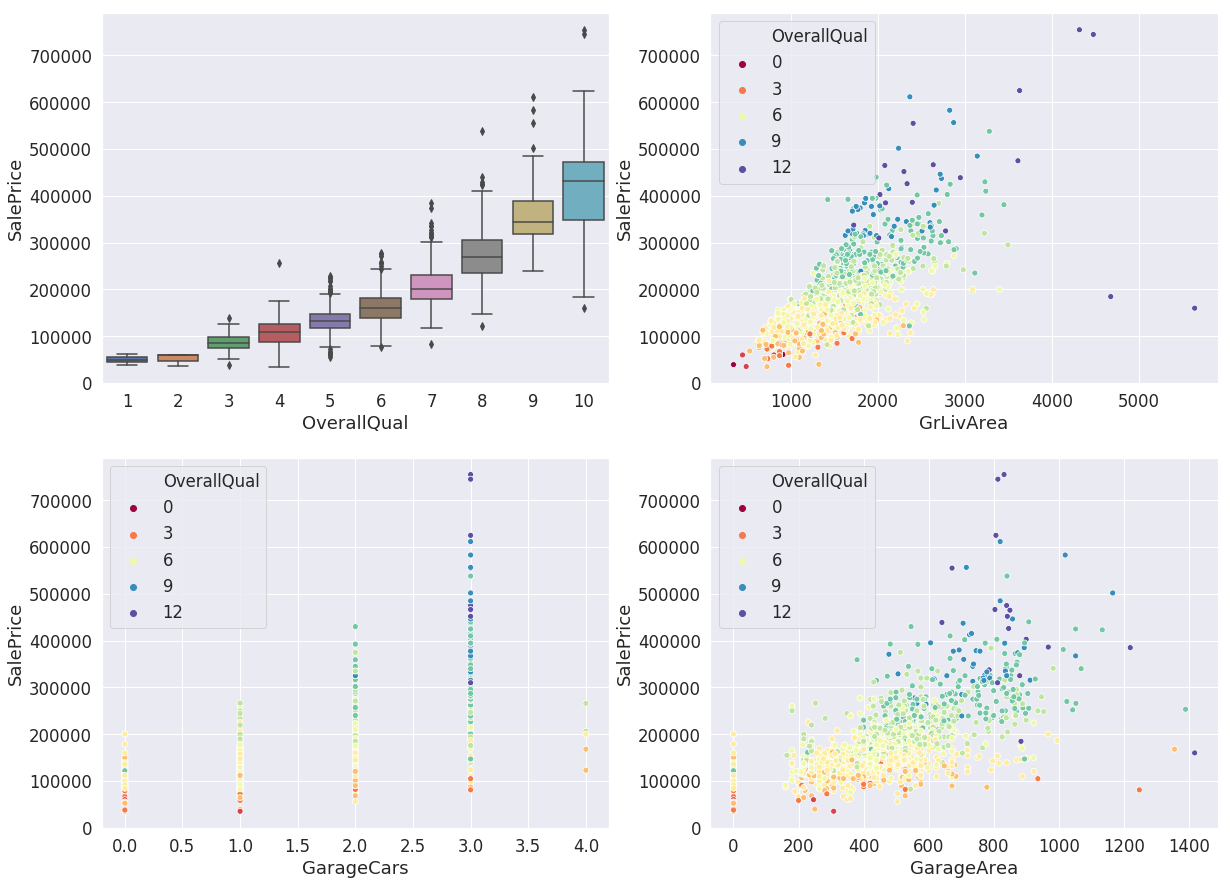

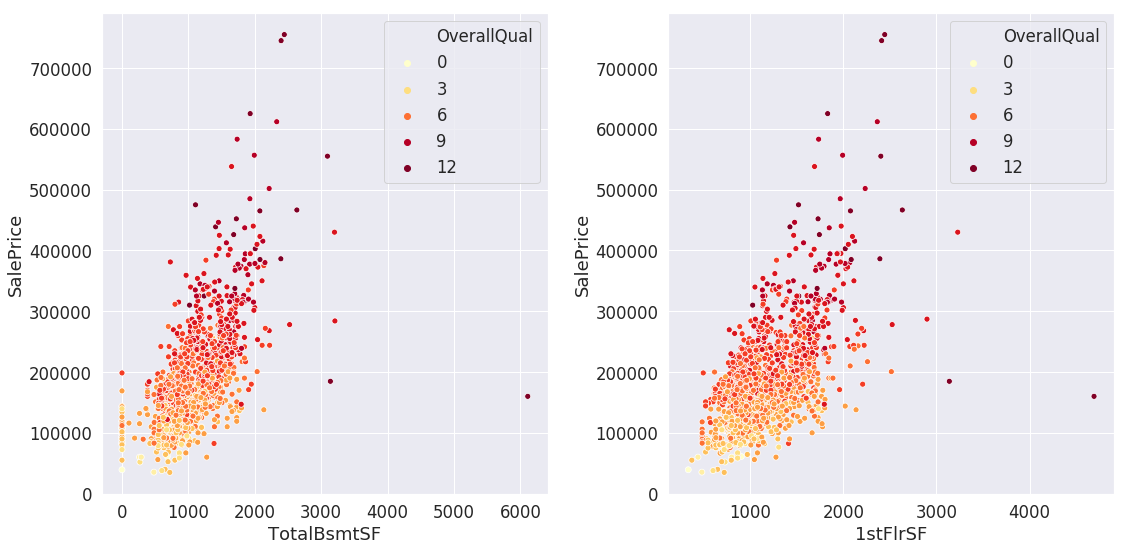

In [14]:
fig = plt.figure(figsize=(20, 15))
sns.set(font_scale=1.5)

# (Corr= 0.817185) Box plot overallqual/salePrice
fig1 = fig.add_subplot(221); sns.boxplot(x='OverallQual', y='SalePrice', data=train[['SalePrice', 'OverallQual']])

# (Corr= 0.700927) GrLivArea vs SalePrice plot
fig2 = fig.add_subplot(222); 
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.680625) GarageCars vs SalePrice plot
fig3 = fig.add_subplot(223); 
sns.scatterplot(x = train.GarageCars, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

# (Corr= 0.650888) GarageArea vs SalePrice plot
fig4 = fig.add_subplot(224); 
sns.scatterplot(x = train.GarageArea, y = train.SalePrice, hue=train.OverallQual, palette= 'Spectral')

fig5 = plt.figure(figsize=(16, 8))
fig6 = fig5.add_subplot(121); 
sns.scatterplot(y = train.SalePrice , x = train.TotalBsmtSF, hue=train.OverallQual, palette= 'YlOrRd')

fig7 = fig5.add_subplot(122); 
sns.scatterplot(y = train.SalePrice, x = train['1stFlrSF'], hue=train.OverallQual, palette= 'YlOrRd')

plt.tight_layout(); plt.show()

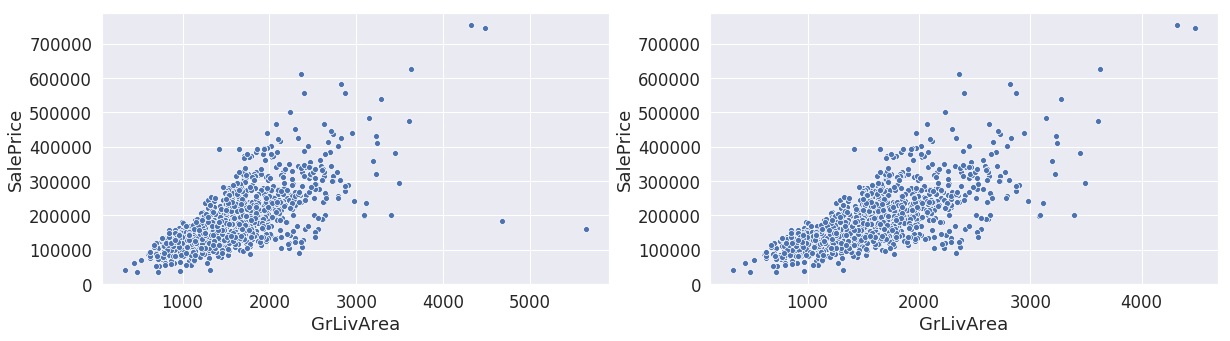

In [15]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
sns.scatterplot(x = train.GrLivArea, y = train.SalePrice, ax = ax)

#Deleting outliers
train = train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<300000)].index)

#Check the graphic again
ax = fig.add_subplot(122)
sns.scatterplot(x =train.GrLivArea, y = train.SalePrice, ax = ax)
plt.show()

                                                                  Outliers: 1


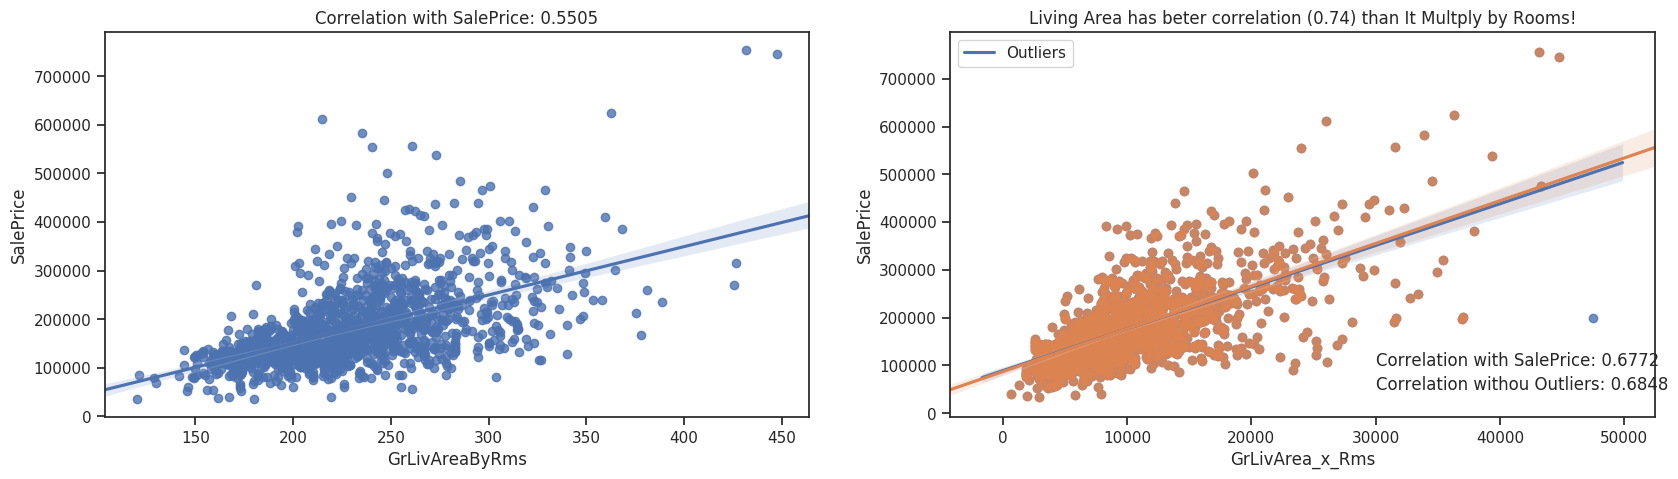

In [16]:
sns.reset_defaults()
sns.set(style="ticks", color_codes=True)

df = train[['SalePrice', 'GrLivArea', 'TotRmsAbvGrd']]
df['GrLivAreaByRms'] = train.GrLivArea/train.TotRmsAbvGrd
df['GrLivArea_x_Rms'] = train.GrLivArea*train.TotRmsAbvGrd
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GrLivAreaByRms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GrLivAreaByRms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122); sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=30000, y=100000, s='Correlation with SalePrice: {:1.4f}'.format(df.GrLivArea_x_Rms.corr(df['SalePrice'])))

print('                                                                  Outliers:',(df.GrLivArea_x_Rms>=45000).sum())
df = df.loc[df.GrLivArea_x_Rms<45000]
sns.regplot(x='GrLivArea_x_Rms', y='SalePrice', data=df); 
plt.title('Living Area has beter correlation ({:1.2f}) than It Multply by Rooms!'.format(df.GrLivArea.corr(df.SalePrice)))
plt.text(x=30000, y=50000, s='Correlation withou Outliers: {:1.4f}'.format(df.GrLivArea_x_Rms.corr(df['SalePrice'])))
plt.show()
del df

In [17]:
train = train[train.GrLivArea * train.TotRmsAbvGrd < 45000]
print('Train observations after remove outliers:',train.shape[0])

Train observations after remove outliers: 1457


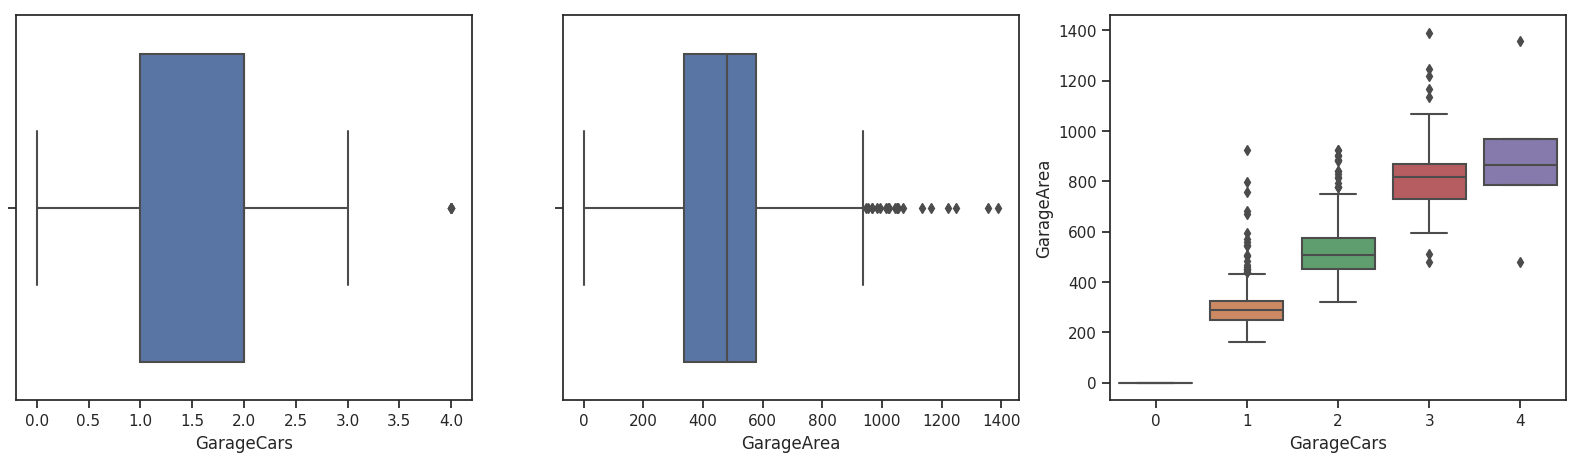

In [18]:
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(131); sns.boxplot(train.GarageCars)
fig2 = fig.add_subplot(132); sns.boxplot(train.GarageArea)
fig3 = fig.add_subplot(133); sns.boxplot(train.GarageCars, train.GarageArea)
plt.show()

                                                                 Outliers: 4


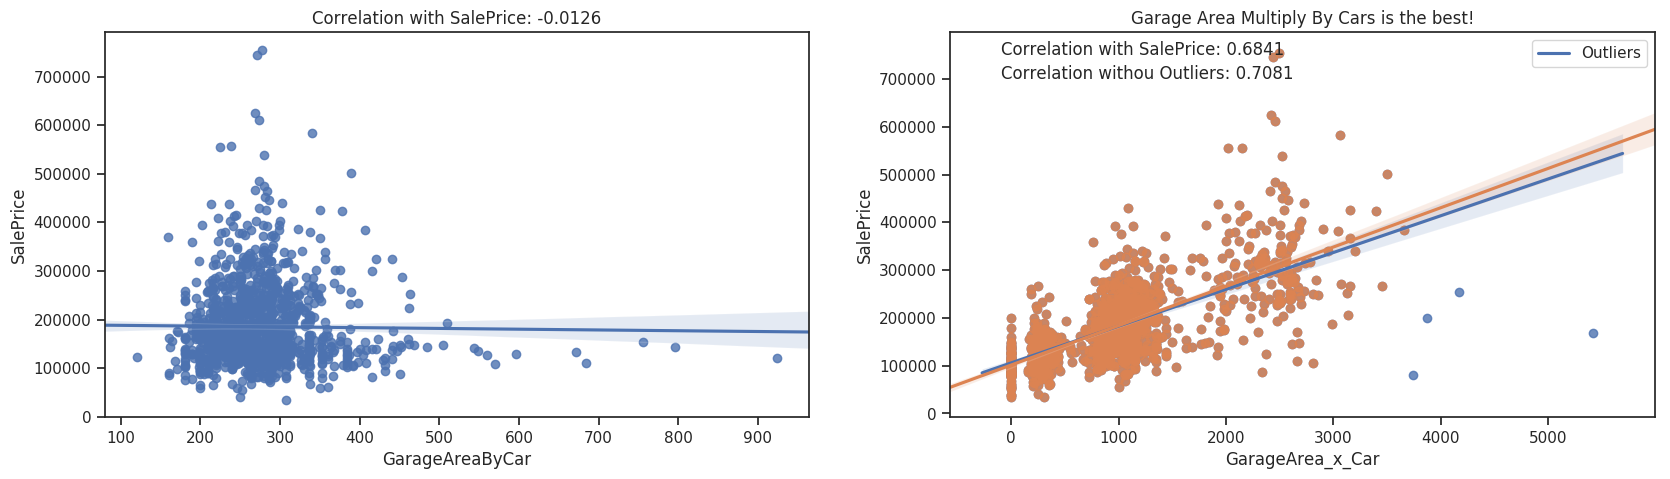

In [19]:
df = train[['SalePrice', 'GarageArea', 'GarageCars']]
df['GarageAreaByCar'] = train.GarageArea/train.GarageCars
df['GarageArea_x_Car'] = train.GarageArea*train.GarageCars

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='GarageAreaByCar', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageAreaByCar.corr(df['SalePrice'])))

fig2 = fig.add_subplot(122); sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=-100, y=750000, s='Correlation with SalePrice: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.GarageArea_x_Car>=3700).sum())
df = df.loc[df.GarageArea_x_Car<3700]
sns.regplot(x='GarageArea_x_Car', y='SalePrice', data=df); plt.title('Garage Area Multiply By Cars is the best!')
plt.text(x=-100, y=700000, s='Correlation withou Outliers: {:6.4f}'.format(df.GarageArea_x_Car.corr(df['SalePrice'])))
plt.show()
del df

In [20]:
train = train[train.GarageArea * train.GarageCars < 3700]
print('Total observatiosn after outliers cut:', train.shape[0])

Total observatiosn after outliers cut: 1453


                                                             Outliers: 1


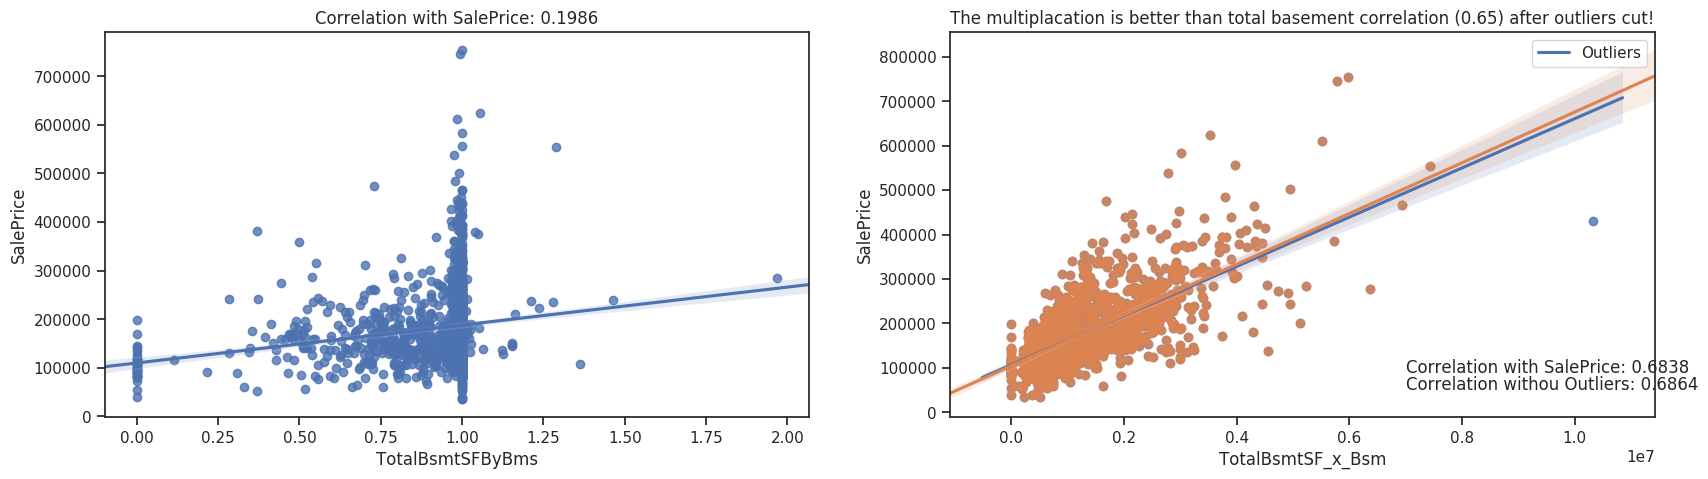

In [21]:
df = train[['SalePrice', 'TotalBsmtSF', '1stFlrSF']]
df['TotalBsmtSFByBms'] = train.TotalBsmtSF/train['1stFlrSF']
df['TotalBsmtSF_x_Bsm'] = train.TotalBsmtSF*train['1stFlrSF']
fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.regplot(x='TotalBsmtSFByBms', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalBsmtSFByBms.corr(df['SalePrice'])))
fig2 = fig.add_subplot(122); sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=7e06, y=90000, s='Correlation with SalePrice: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))

print('                                                             Outliers:',(df.TotalBsmtSF_x_Bsm>=0.9e07).sum())
df = df.loc[df.TotalBsmtSF_x_Bsm<0.9e07]
sns.regplot(x='TotalBsmtSF_x_Bsm', y='SalePrice', data=df); 
plt.title('The multiplacation is better than total basement correlation ({:1.2f}) after outliers cut!'.format(df.TotalBsmtSF.corr(df.SalePrice)))
plt.text(x=7e06, y=50000, s='Correlation withou Outliers: {:1.4f}'.format(df.TotalBsmtSF_x_Bsm.corr(df['SalePrice'])))
plt.show()
del df

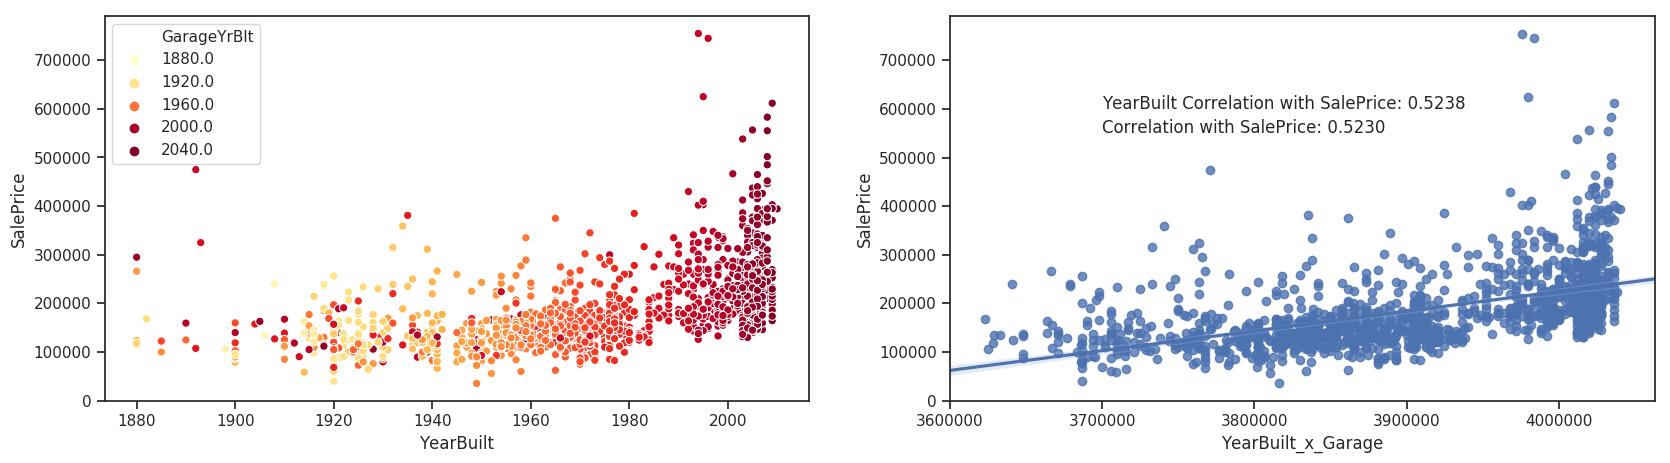

In [22]:
df = train[['SalePrice', 'YearBuilt', 'GarageYrBlt']]
df['YearBuilt_x_Garage'] = train.YearBuilt*train.GarageYrBlt
df['Garage_Newest'] = train.YearBuilt < train.GarageYrBlt

fig = plt.figure(figsize=(20,5))
fig1 = fig.add_subplot(121); sns.scatterplot(y = df.SalePrice, x = df.YearBuilt, hue=df.GarageYrBlt, palette= 'YlOrRd')
fig2 = fig.add_subplot(122); sns.regplot(x='YearBuilt_x_Garage', y='SalePrice', data=df); 
plt.text(x=3700000, y=600000, s='YearBuilt Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt.corr(df['SalePrice'])))
plt.text(x=3700000, y=550000, s='Correlation with SalePrice: {:1.4f}'.format(df.YearBuilt_x_Garage.corr(df['SalePrice'])))
plt.show()

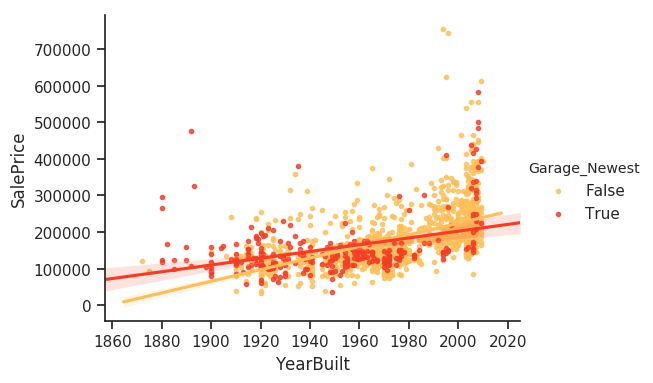

In [23]:
sns.lmplot(y = 'SalePrice', x = 'YearBuilt', data=df, markers='.', 
           aspect=1.4, height=4, hue= 'Garage_Newest', palette= 'YlOrRd')
plt.show();  
del df

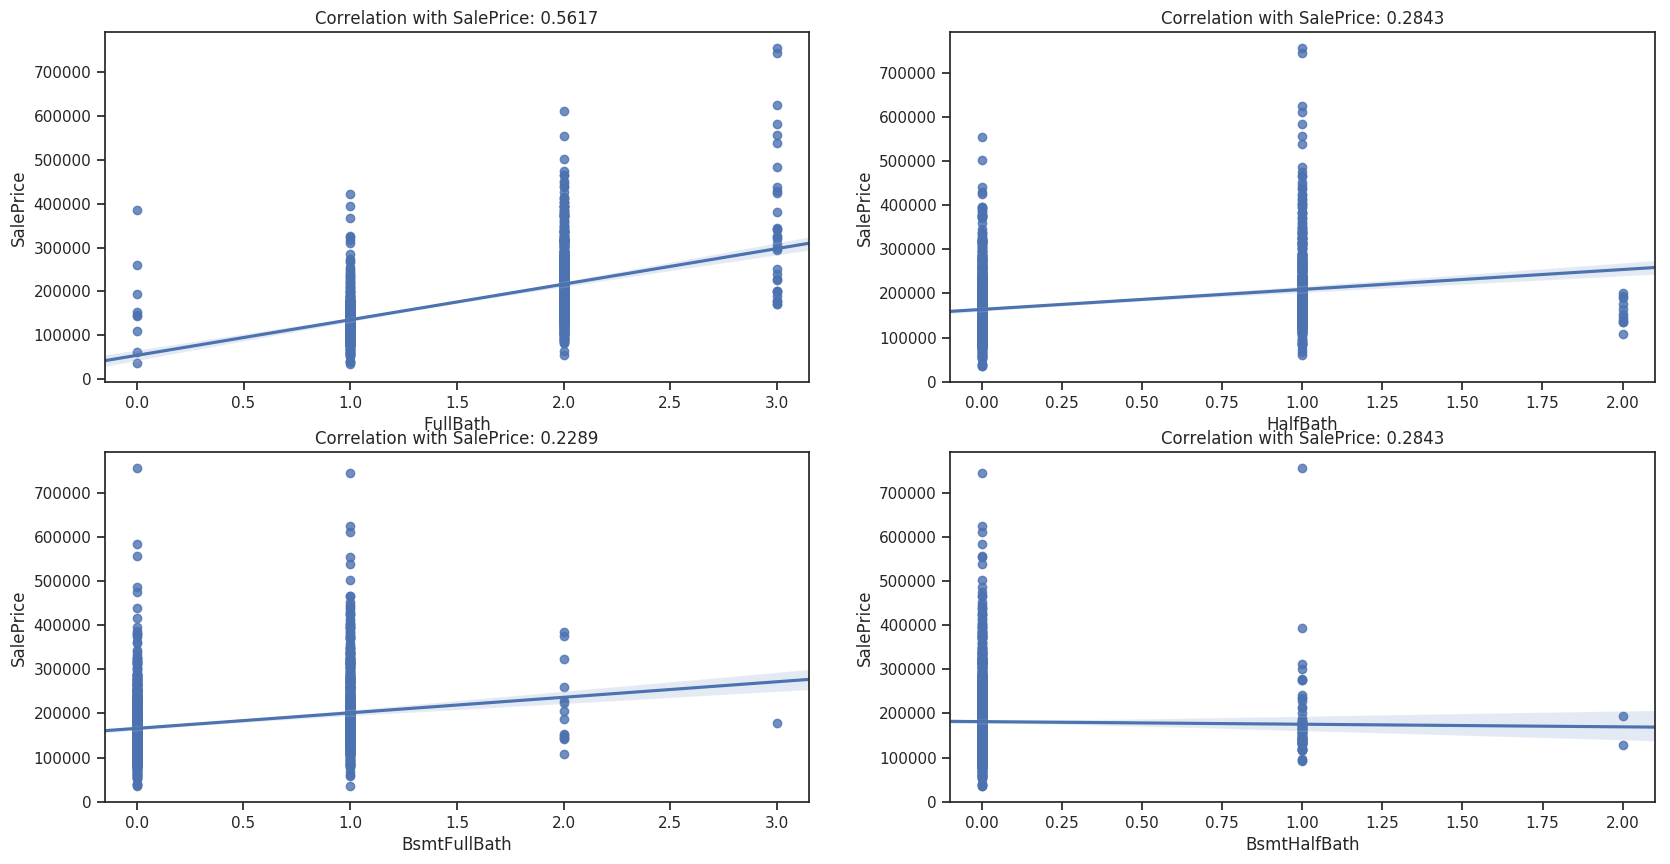

In [24]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(221); sns.regplot(x='FullBath', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.FullBath.corr(train['SalePrice'])))

fig2 = fig.add_subplot(222); sns.regplot(x='HalfBath', y='SalePrice', data=train);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

fig3 = fig.add_subplot(223); sns.regplot(x='BsmtFullBath', y='SalePrice', data=train)
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.BsmtFullBath.corr(train['SalePrice'])))

fig4 = fig.add_subplot(224); sns.regplot(x='BsmtHalfBath', y='SalePrice', data=train);
plt.title('Correlation with SalePrice: {:6.4f}'.format(train.HalfBath.corr(train['SalePrice'])))

plt.show()

In [0]:
df = train[['SalePrice', 'FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']]
df['TotBathrooms'] = df.FullBath + (df.HalfBath*0.5) + df.BsmtFullBath + (df.BsmtHalfBath*0.5)

                                                                 Outliers: 2


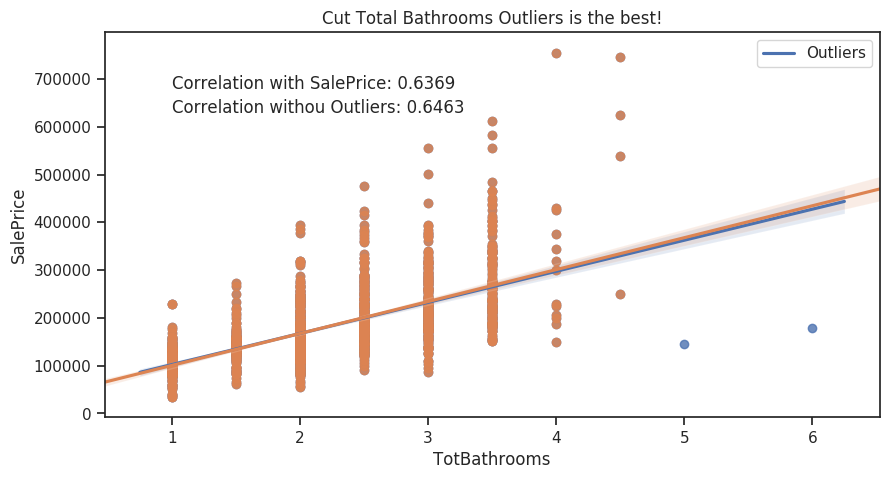

In [26]:
fig = plt.figure(figsize=(10,5))
sns.regplot(x='TotBathrooms', y='SalePrice', data=df); plt.legend(['Outliers'])
plt.text(x=1, y=680000, s='Correlation with SalePrice: {:6.4f}'.format(df.TotBathrooms.corr(df['SalePrice'])))
print('                                                                 Outliers:',(df.TotBathrooms>=5).sum())
df = df.loc[df.TotBathrooms<5]
sns.regplot(x='TotBathrooms', y='SalePrice', data=df); plt.title('Cut Total Bathrooms Outliers is the best!')
plt.text(x=1, y=630000, s='Correlation withou Outliers: {:6.4f}'.format(df.TotBathrooms.corr(df['SalePrice'])))
plt.show()

In [27]:
rain = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]
print('Data observations after outliers deletion:', train.shape[0])

Data observations after outliers deletion: 1453


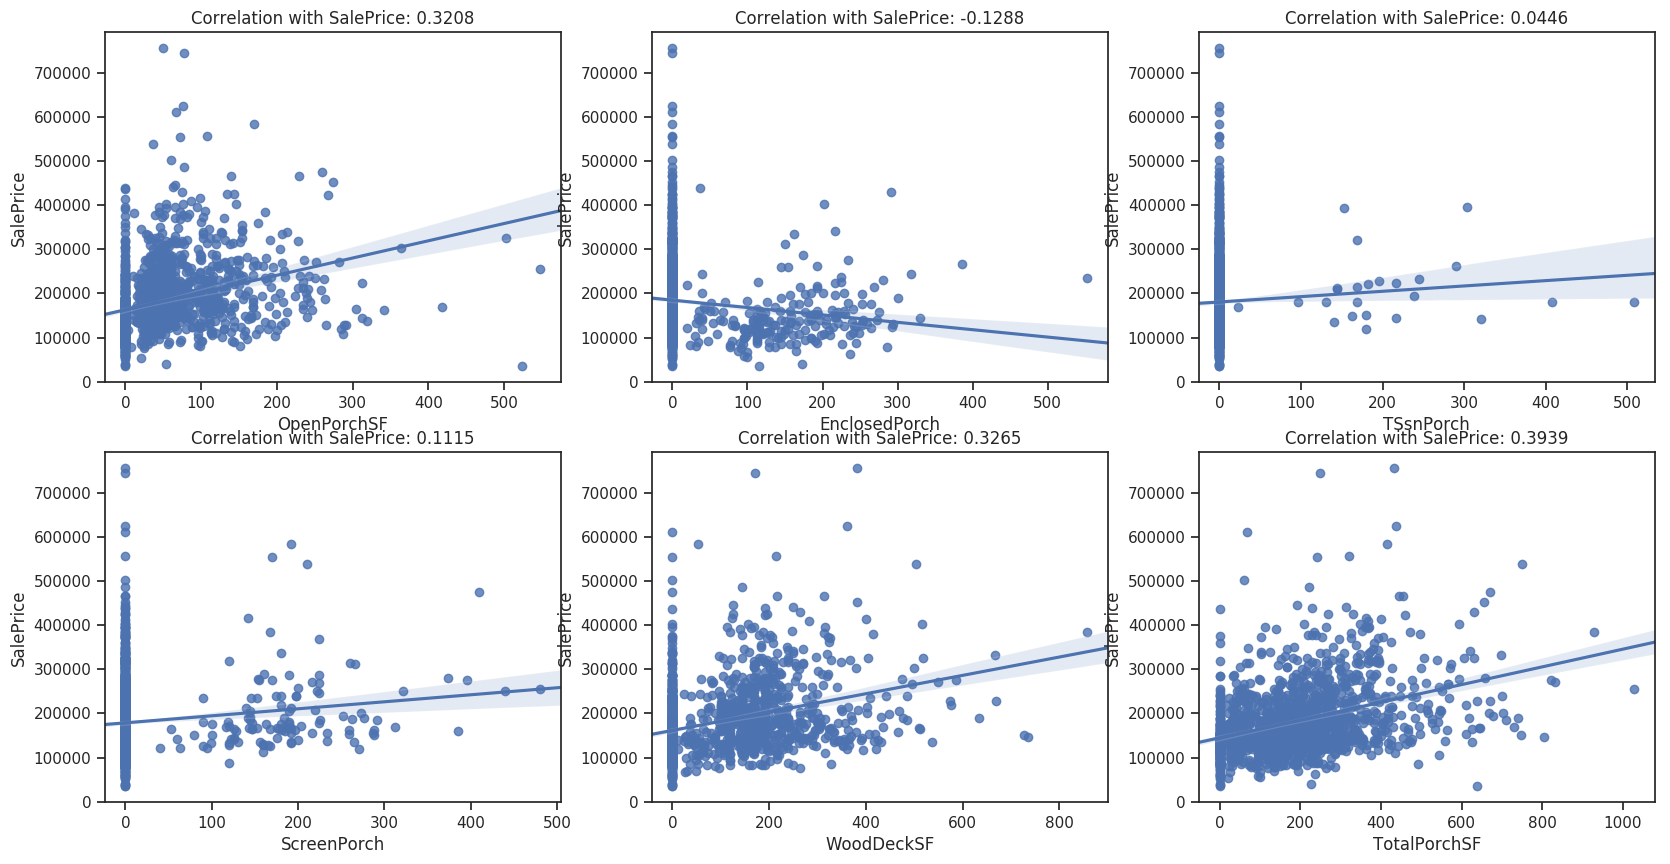

In [28]:
def PorchPlots():
    fig = plt.figure(figsize=(20,10))
    fig1 = fig.add_subplot(231); sns.regplot(x='OpenPorchSF', y='SalePrice', data=df)
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.OpenPorchSF.corr(df['SalePrice'])))

    fig2 = fig.add_subplot(232); sns.regplot(x='EnclosedPorch', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.EnclosedPorch.corr(df['SalePrice'])))

    fig3 = fig.add_subplot(233); sns.regplot(x='TSsnPorch', y='SalePrice', data=df)
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TSsnPorch.corr(df['SalePrice'])))

    fig4 = fig.add_subplot(234); sns.regplot(x='ScreenPorch', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.ScreenPorch.corr(df['SalePrice'])))

    fig5 = fig.add_subplot(235); sns.regplot(x='WoodDeckSF', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.WoodDeckSF.corr(df['SalePrice'])))

    fig6 = fig.add_subplot(236); sns.regplot(x='TotalPorchSF', y='SalePrice', data=df);
    plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalPorchSF.corr(df['SalePrice'])))

    plt.show()

df = train[['SalePrice', 'OpenPorchSF', 'EnclosedPorch', 'TSsnPorch', 'ScreenPorch', 'WoodDeckSF']]
df['TotalPorchSF'] = df.OpenPorchSF + df.EnclosedPorch + df.TSsnPorch + df.ScreenPorch + df.WoodDeckSF
#df = df[df.TotalPorchSF<=600] # A possible outlier cut!
PorchPlots()

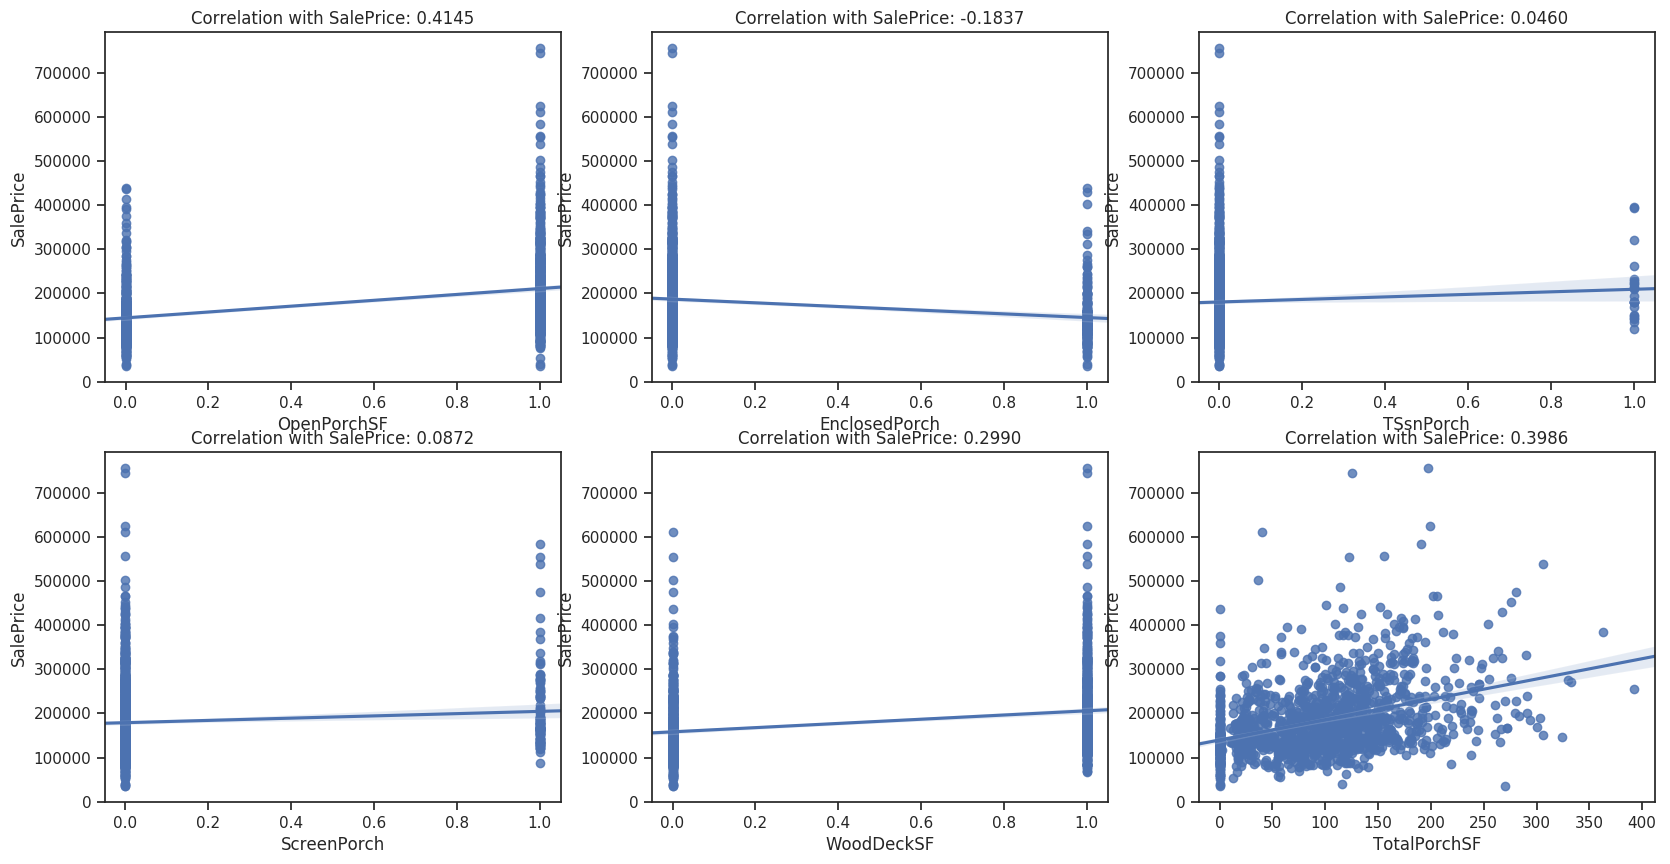

In [29]:
df.OpenPorchSF = df.OpenPorchSF > 0
df.EnclosedPorch =  df.EnclosedPorch > 0
df.TSsnPorch = df.TSsnPorch > 0
df.ScreenPorch = df.ScreenPorch > 0
df.WoodDeckSF = df.WoodDeckSF > 0
df.TotalPorchSF = np.sqrt(df.TotalPorchSF) * (np.log1p(np.sqrt(df.TotalPorchSF))**2)

PorchPlots()

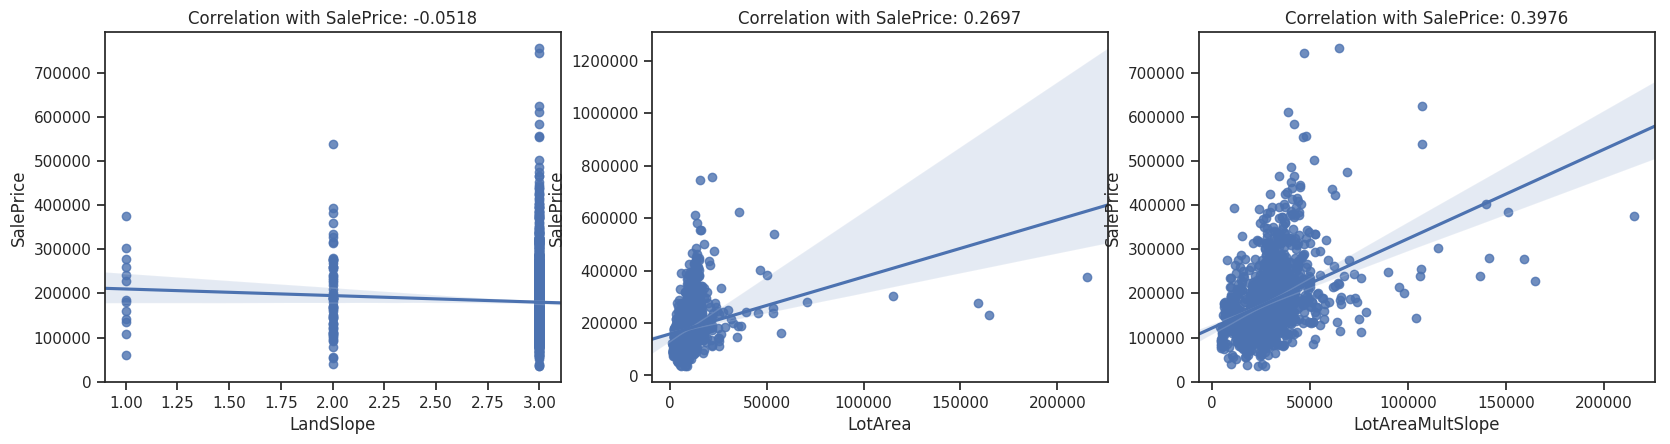

In [30]:
LandSlope = {}
LandSlope['Gtl'] = 3 #'Gentle slope'
LandSlope['Mod'] = 2 #'Moderate Slope'
LandSlope['Sev'] = 1 #'Severe Slope'

df = train[['SalePrice', 'LandSlope', 'LotArea']]
df.LandSlope = df.LandSlope.map(LandSlope)
df['LotAreaMultSlope'] = (df.LotArea * df.LandSlope)

fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='LandSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LandSlope.corr(df['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='LotArea', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotArea.corr(df['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='LotAreaMultSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotAreaMultSlope.corr(df['SalePrice'])))
plt.show()

     SalePrice  LandSlope  LotArea  LotAreaMultSlope
249     277000          1   159000            159000
313     375000          1   215245            215245
335     228950          1   164660            164660


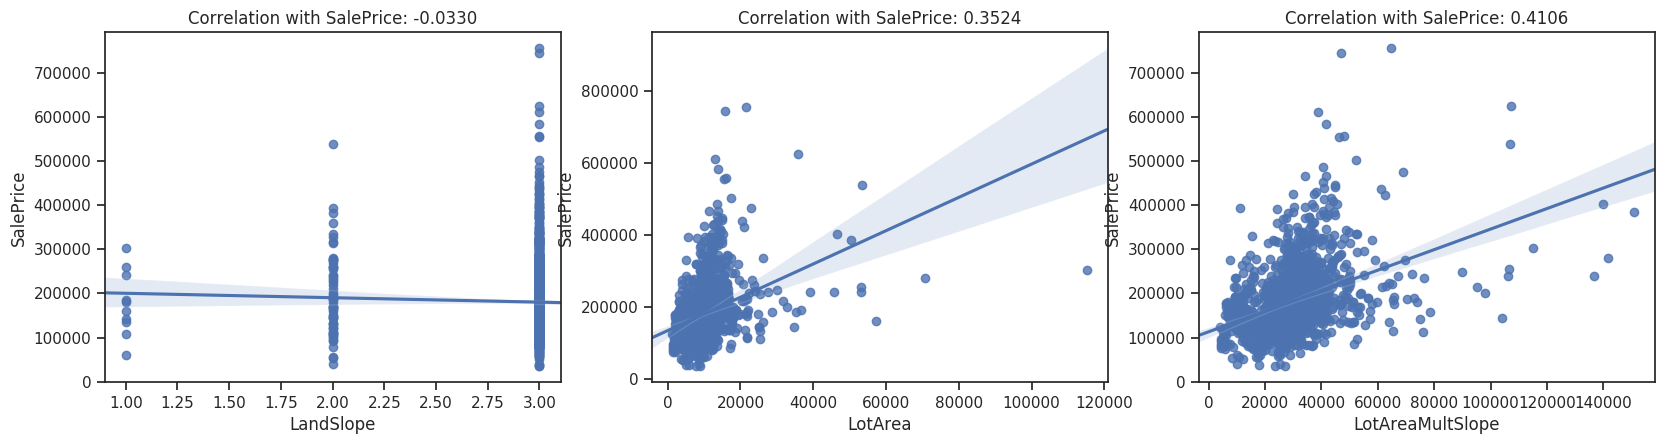

In [31]:
print(df[df.LotArea>155000])
df = df[df.LotArea<155000]
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(234); sns.regplot(x='LandSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LandSlope.corr(df['SalePrice'])))

fig2 = fig.add_subplot(235); sns.regplot(x='LotArea', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotArea.corr(df['SalePrice'])))

fig3 = fig.add_subplot(236); sns.regplot(x='LotAreaMultSlope', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.LotAreaMultSlope.corr(df['SalePrice'])))
plt.show()

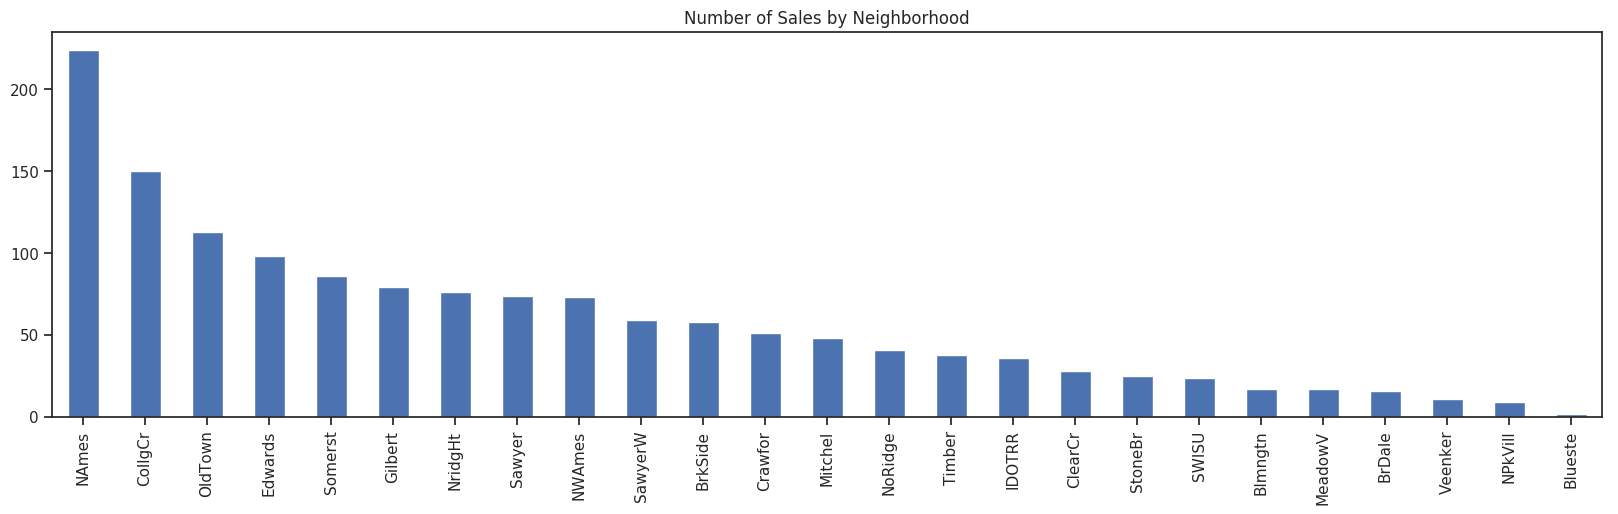

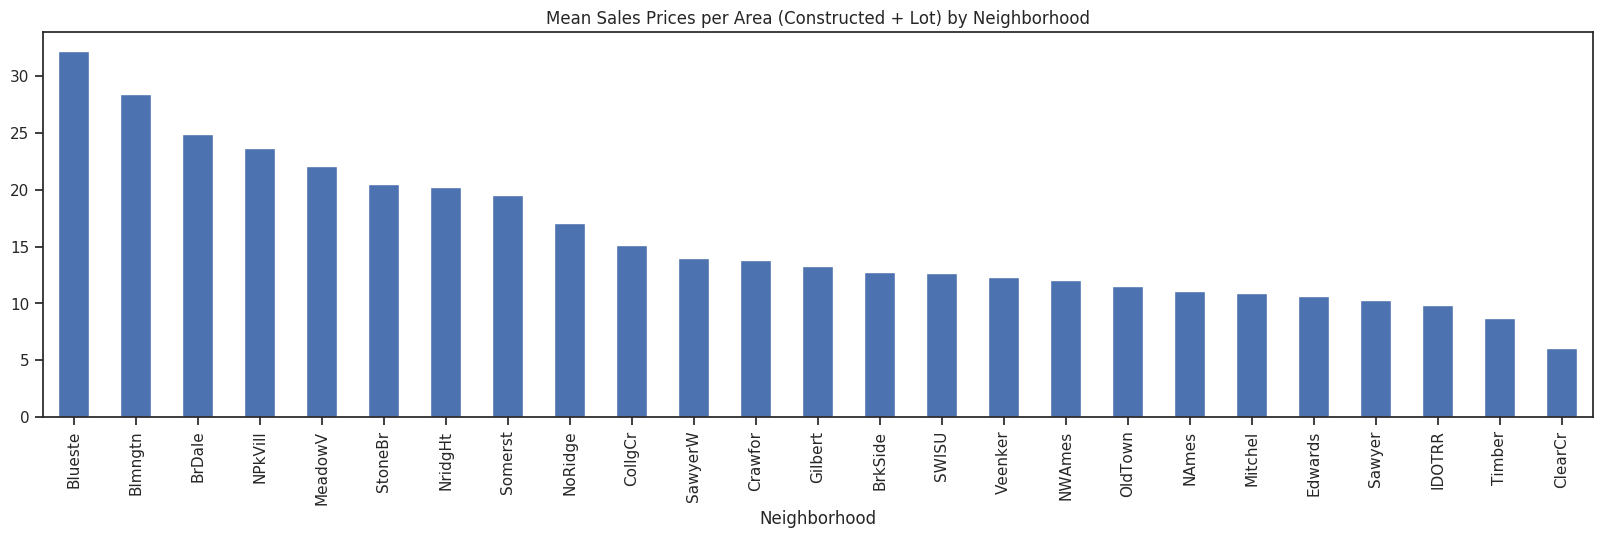

In [32]:
figa = plt.figure(figsize=(20, 5))
g = train.Neighborhood.value_counts().plot(kind='bar', title='Number of Sales by Neighborhood')

figb = plt.figure(figsize=(20, 5))
plt.tight_layout()
df = train[['SalePrice', 'YrSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )
 
df = df.groupby(by=['Neighborhood', 'YrSold'], as_index=False).sum()
Neig = df[['SalePrice', 'TotalArea', 'Neighborhood']].groupby(by='Neighborhood', as_index=False).sum()
Neig['NeigPrice'] = Neig.SalePrice / Neig.TotalArea
Neig.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)
g = Neig.groupby('Neighborhood').NeigPrice.sum().sort_values(ascending = False).\
    plot(kind='bar', title='Mean Sales Prices per Area (Constructed + Lot) by Neighborhood')
Neig = Neig.groupby(by='Neighborhood', as_index=True).NeigPrice.sum().sort_values(ascending = False)

                              Yearly Sales Prices per Area (Constructed + Lot) by Neighborhood:


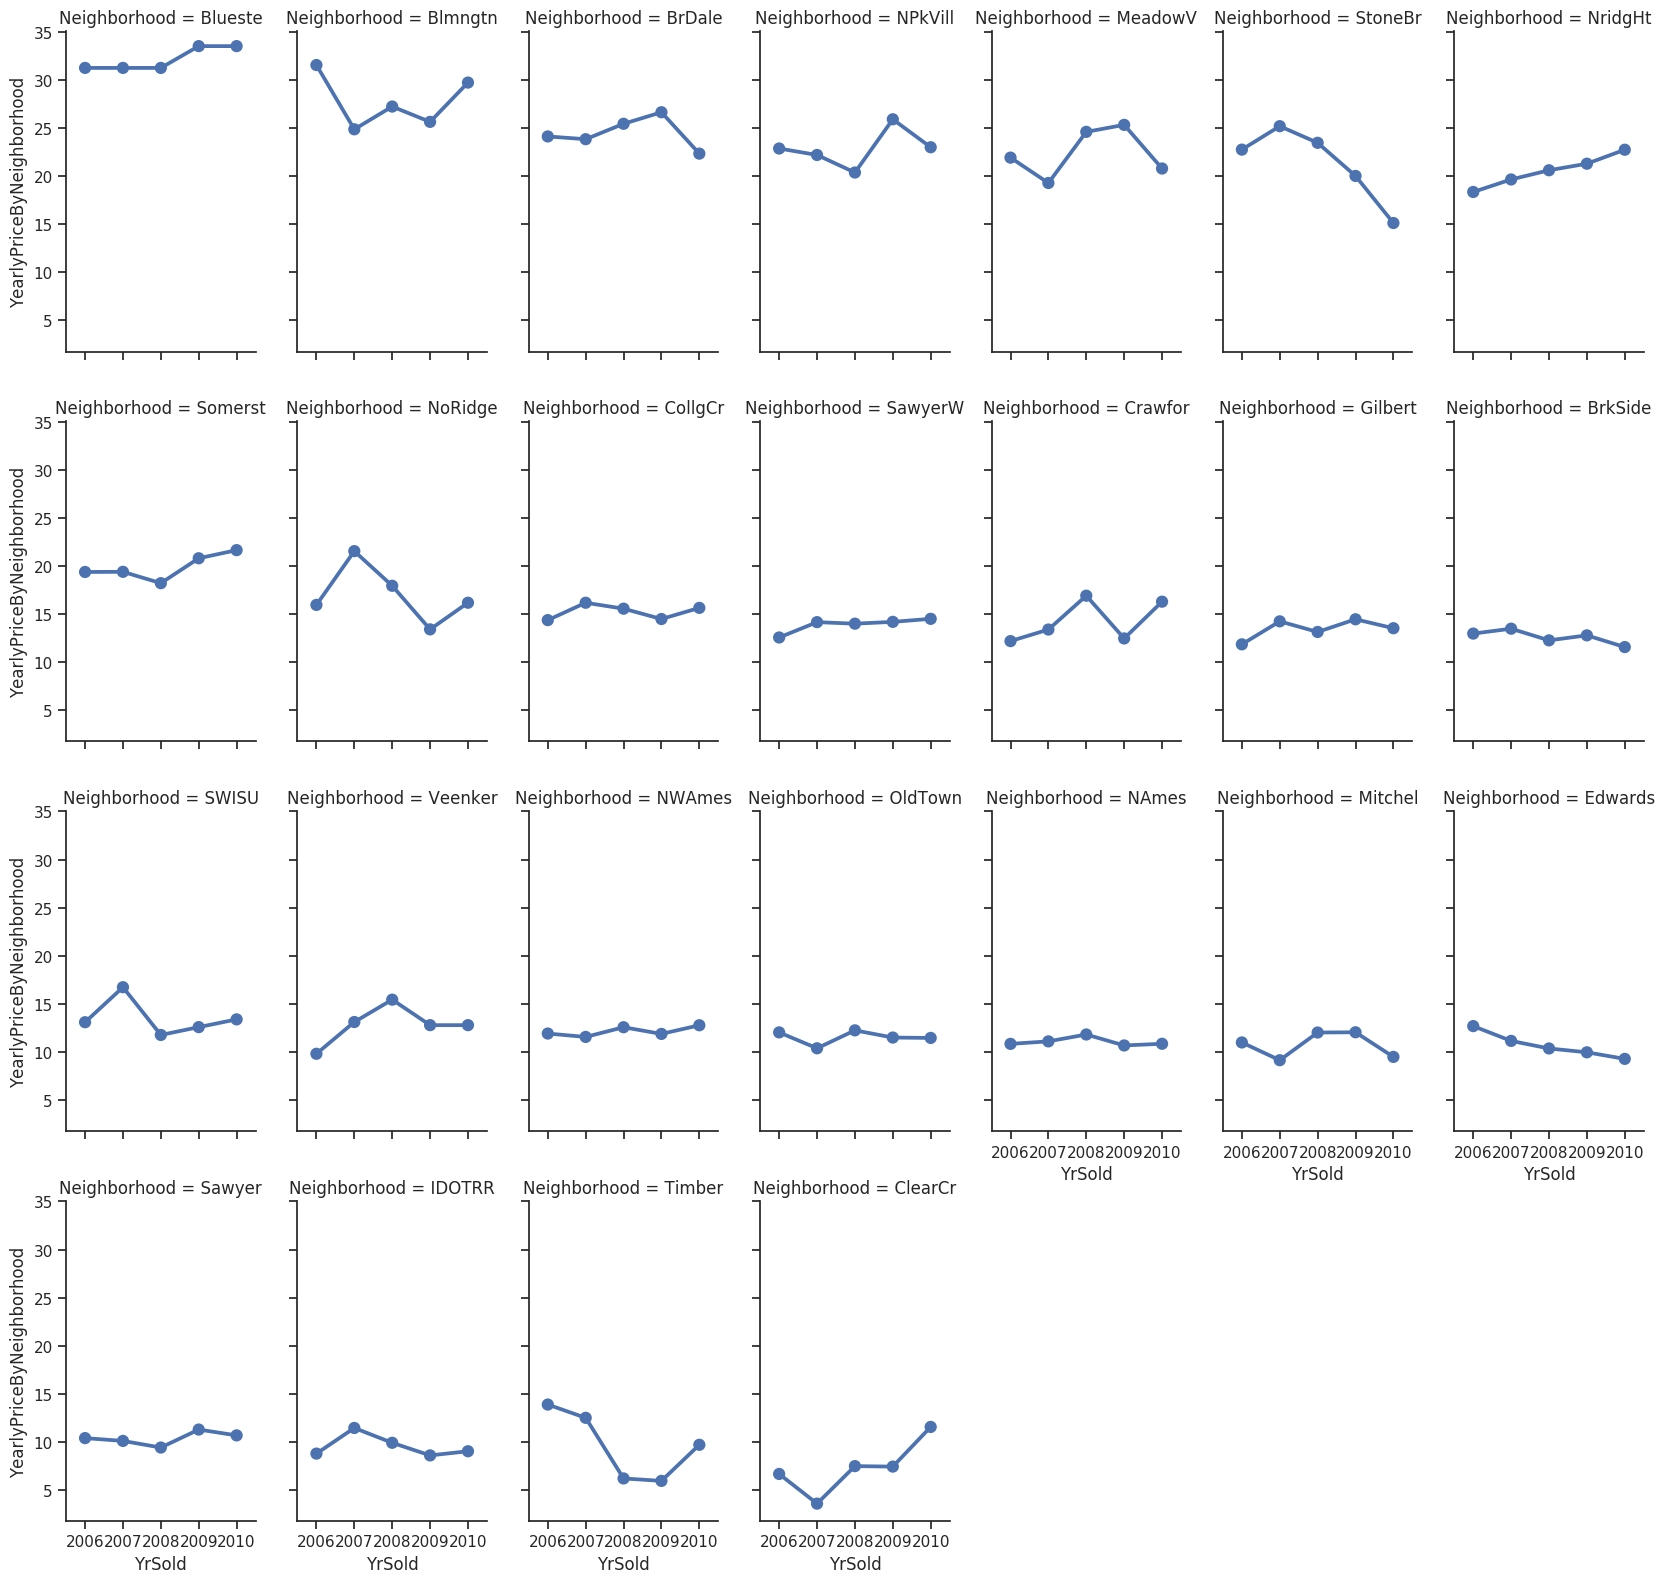

In [33]:
# Yearly Sales Price per Area (Constructed + Lot) by Neighborhood:
df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

# Fill the gaps
df = df.append(pd.DataFrame([['NPkVill', 2006, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Veenker', 2009, df.HistPriceByNeighborhood[df.Neighborhood=='Veenker'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Veenker', 2010, df.HistPriceByNeighborhood[df.Neighborhood=='Veenker'].mean()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2006, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].min()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2007, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].min()]], 
                            columns=df.columns))

df = df.append(pd.DataFrame([['Blueste', 2010, df.HistPriceByNeighborhood[df.Neighborhood=='Blueste'].max()]], 
                            columns=df.columns))

# Reserve data to merge with all data set of train and test data
YearlyPrice = df
YearlyPrice.columns = ['Neighborhood', 'YrSold', 'YearlyPriceByNeighborhood']

print('                              Yearly Sales Prices per Area (Constructed + Lot) by Neighborhood:')
g = sns.catplot(y= 'YearlyPriceByNeighborhood', x = 'YrSold', col='Neighborhood', data=YearlyPrice, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index)

                                 Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:


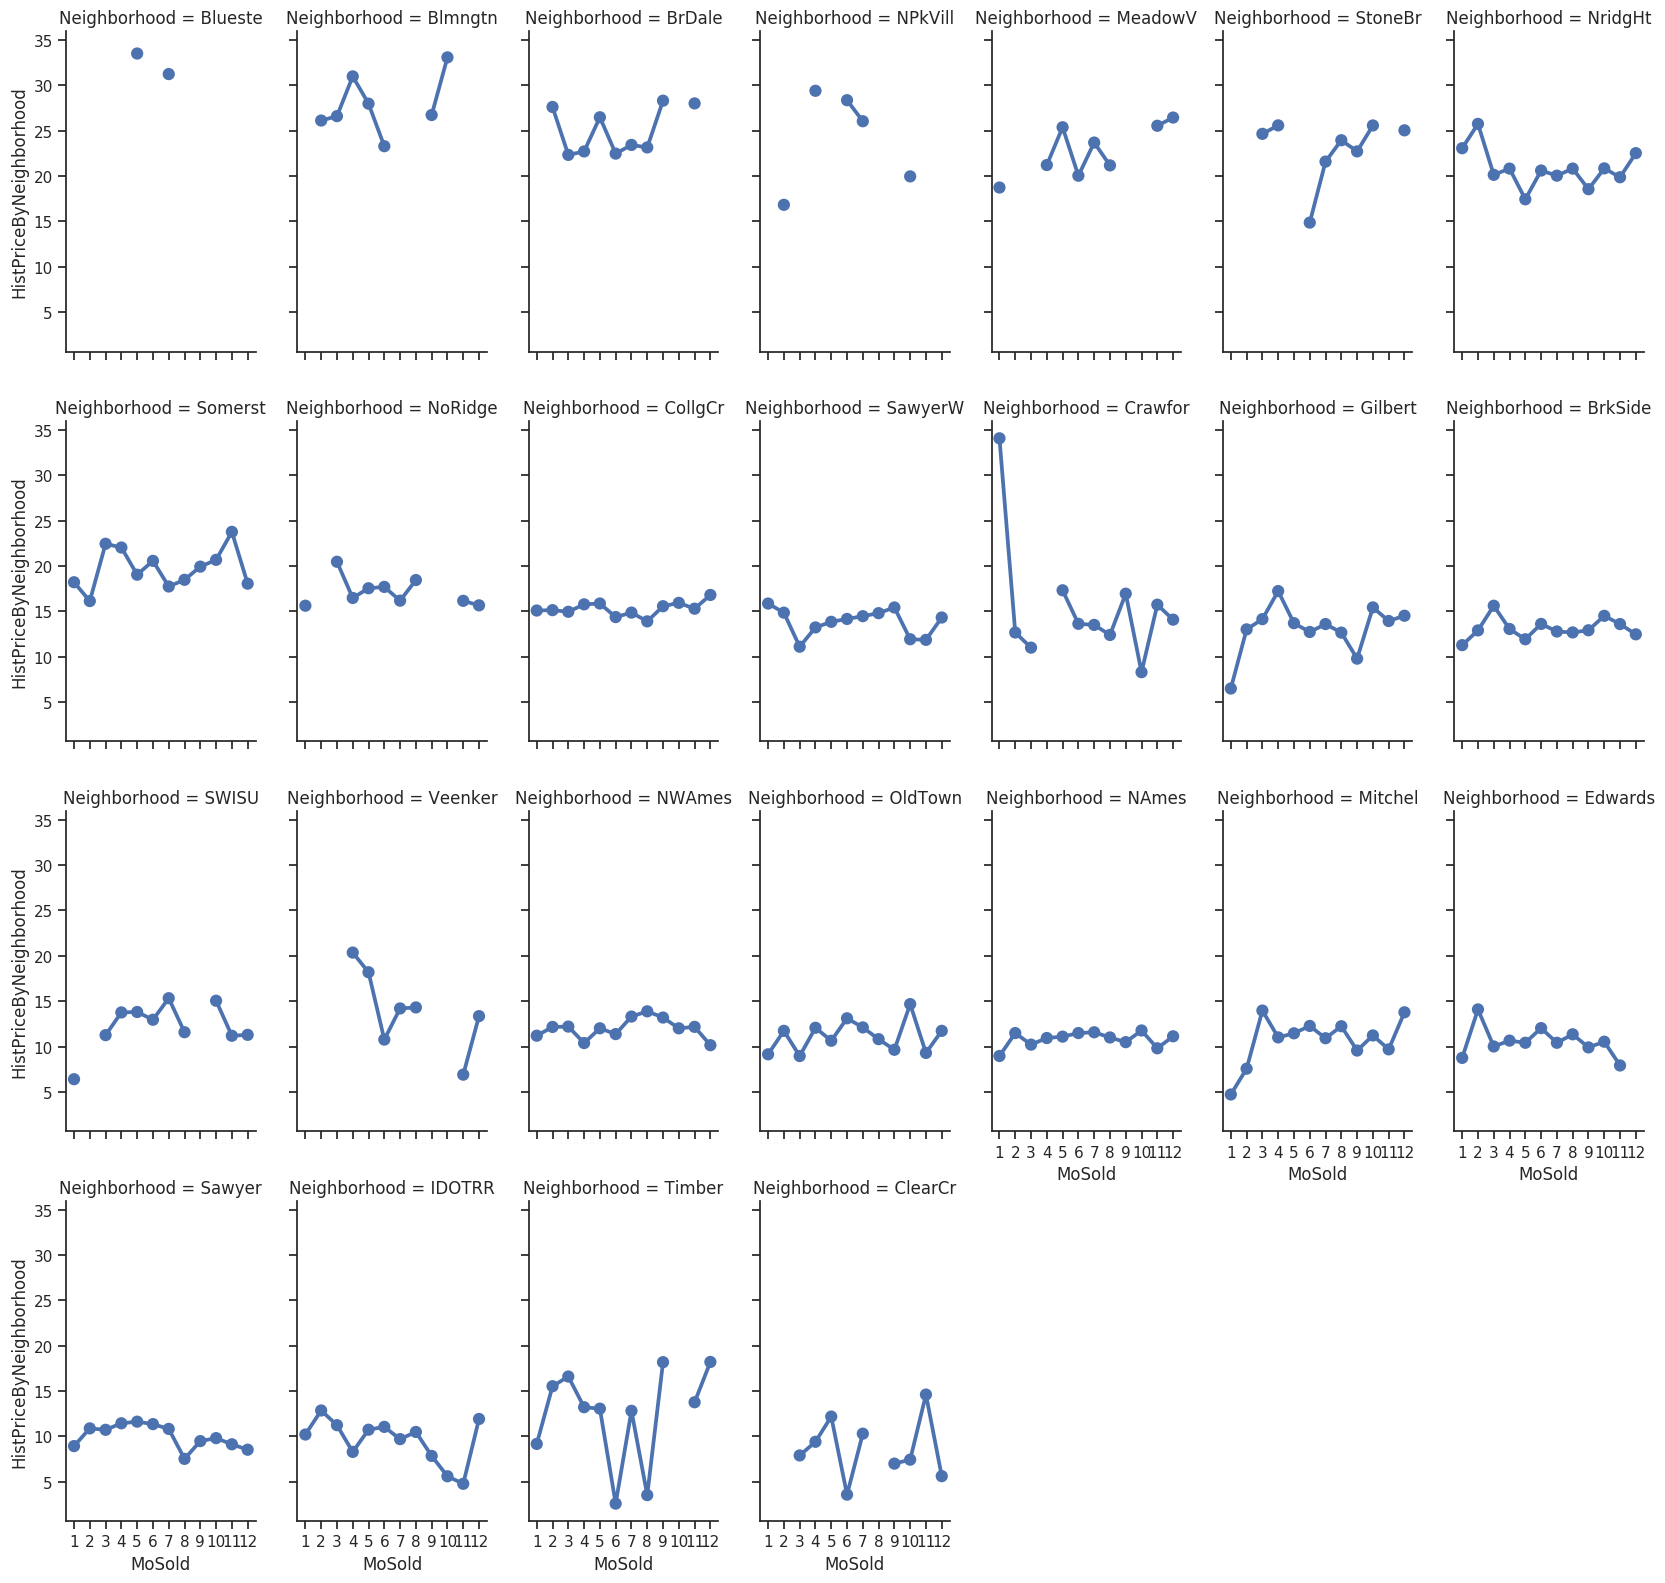

In [34]:
# Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:
df = train[['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

df = df.groupby(by=['Neighborhood', 'MoSold'], as_index=False).sum()
df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

print('                                 Monthly Sales Prices per Area (Constructed + Lot) by Neighborhood:')
g = sns.catplot(y= 'HistPriceByNeighborhood', x = 'MoSold', col='Neighborhood', data=df, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index )

In [35]:
# Outliers from Crawfor Neighborhood
df = train[train.Neighborhood=='Crawfor'][['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )

df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea
df[df.HistPriceByNeighborhood>30]

SalePrice  MoSold Neighborhood  TotalArea  HistPriceByNeighborhood
1181     392500      11      Crawfor   9875.000                   39.747
1405     275000       1      Crawfor   8074.000                   34.060

In [38]:
train = train.loc[~(train.SalePrice==392500.0)]
train = train.loc[~((train.SalePrice==275000.0) & (train.Neighborhood=='Crawfor'))]
print('Data observations after outliers deletion:', train.shape[0])

Data observations after outliers deletion: 1451


                         Monthly Hist Sales Prices per Area (Construct + Lot) by Neighborhood:


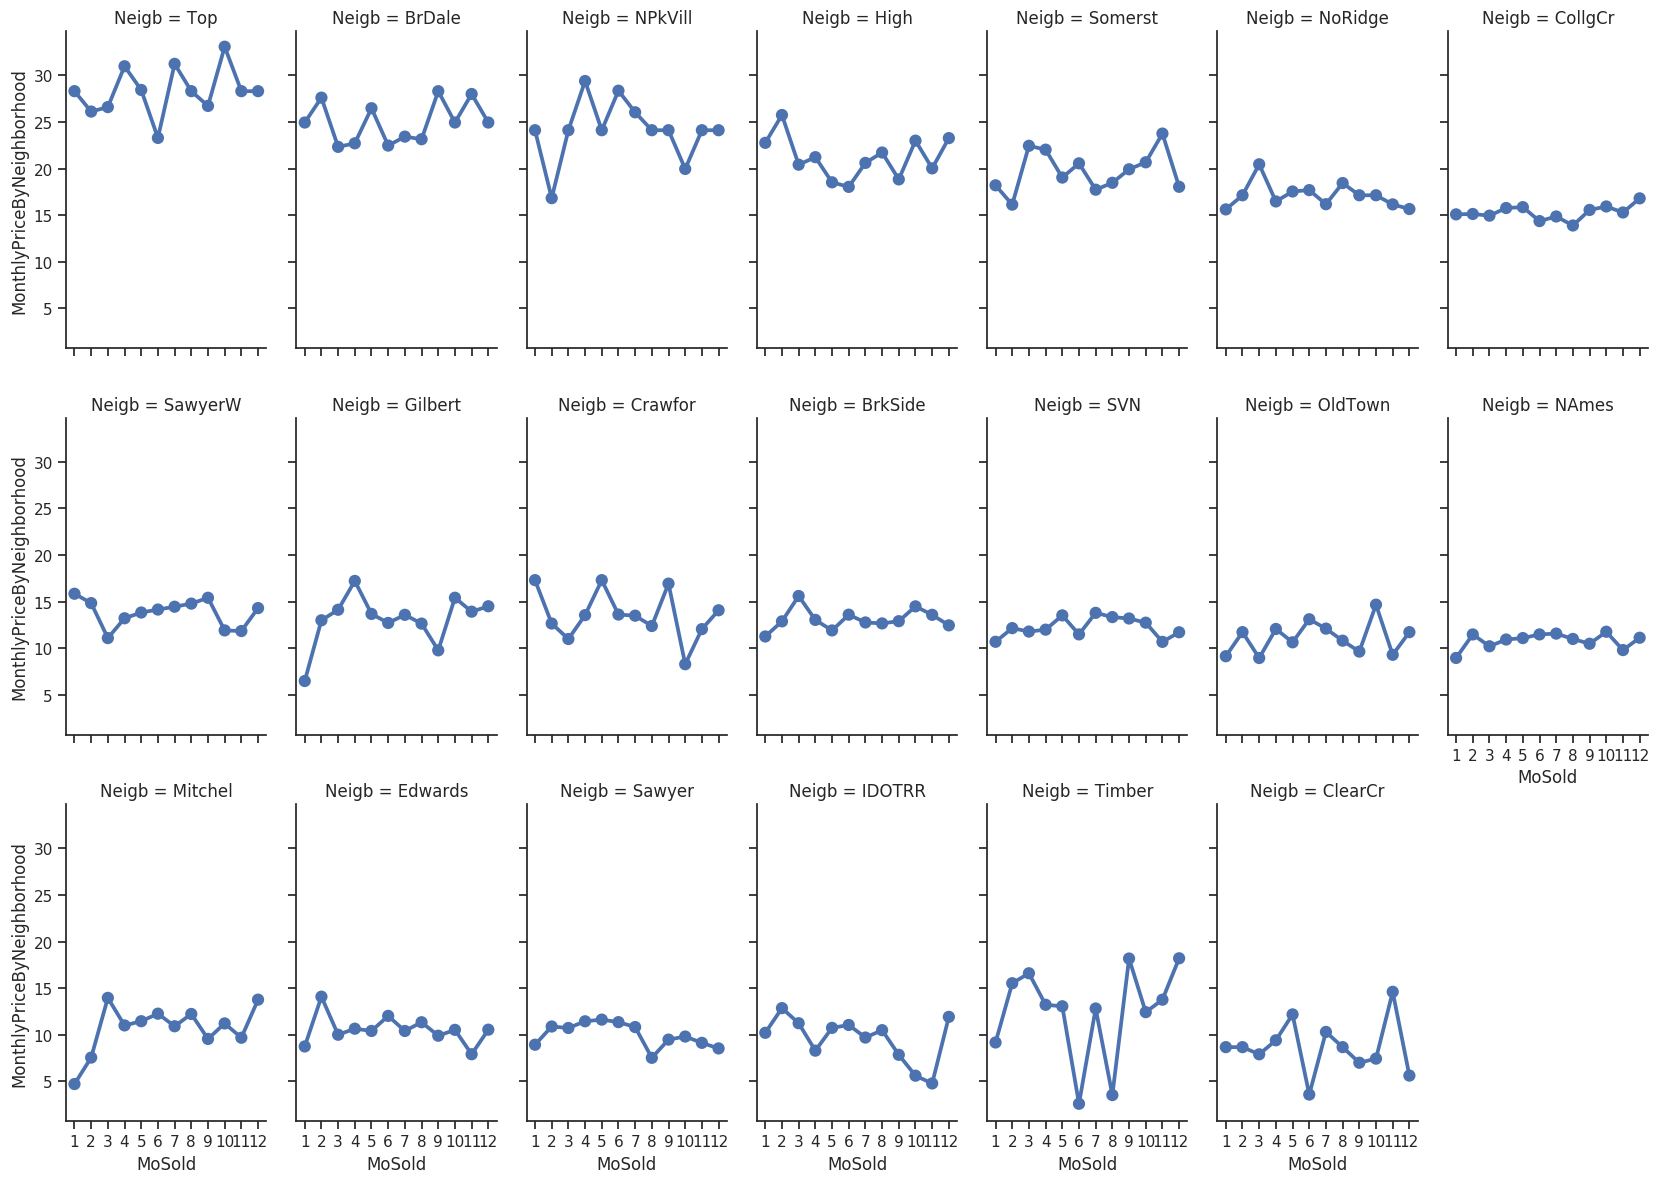

In [39]:
# Bin neighborhood for trade cases with low observations on monthly sales prices per Area (Constructed + Lot) by Neighborhood:
Neigb = {}
Neigb['Blueste'] = 'Top'     # 32.212721
Neigb['Blmngtn'] = 'Top'     # 28.364756
Neigb['BrDale']  = 'BrDale'  # 24.903923
Neigb['NPkVill'] = 'NPkVill' # 23.681105
Neigb['MeadowV'] = 'High'    # 22.034923
Neigb['StoneBr'] = 'High'    # 20.475090
Neigb['NridgHt'] =  'High'   # 20.209245
Neigb['Somerst'] = 'Somerst' # 19.551888
Neigb['NoRidge'] = 'NoRidge' # 17.038145
Neigb['CollgCr'] = 'CollgCr' # 15.134767
Neigb['SawyerW'] = 'SawyerW' # 13.992995
Neigb['Crawfor'] = 'Crawfor' # 13.773418
Neigb['Gilbert'] = 'Gilbert' # 13.260281
Neigb['BrkSide'] = 'BrkSide' # 12.785202
Neigb['SWISU']   = 'SVN'     # 12.635171
Neigb['Veenker'] = 'SVN'     # 12.343735
Neigb['NWAmes']  = 'SVN'     # 12.066590
Neigb['OldTown'] = 'OldTown' # 11.571331
Neigb['NAmes']   = 'NAmes'   # 11.091393
Neigb['Mitchel'] = 'Mitchel' # 10.936368
Neigb['Edwards'] = 'Edwards' # 10.614919
Neigb['Sawyer']  = 'Sawyer'  #10.334445
Neigb['IDOTRR']  = 'IDOTRR'  # 9.880838
Neigb['Timber']  = 'Timber'  # 8.723326
Neigb['ClearCr'] = 'ClearCr' # 6.113654

# Preper dataset for Sales Price per Area (Constructed + Lot) by Neighborhood:
df = train[['SalePrice', 'MoSold', 'Neighborhood']]

df['TotalArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                   train.LotArea.fillna(0) + train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + 
                   train.OpenPorchSF.fillna(0) + train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + 
                   train.EnclosedPorch.fillna(0) + train.PoolArea.fillna(0) )
df['Price'] = df.SalePrice/df.TotalArea

# Cut Outliers from Crawfor Neighborhood
df = df[(((df.Neighborhood == 'Crawfor') & (df.Price<30.)) | (df.Neighborhood != 'Crawfor'))]
df.drop(['Price'], axis=1, inplace=True)

df.Neighborhood = train.Neighborhood.map(Neigb)

df = df.groupby(by=['Neighborhood', 'MoSold'], as_index=False).sum()
df['HistPriceByNeighborhood'] = df.SalePrice / df.TotalArea

# Get the index for order by value
Neig = df[['SalePrice', 'TotalArea', 'Neighborhood']].groupby(by='Neighborhood', as_index=False).sum()
Neig['NeigPrice'] = Neig.SalePrice / Neig.TotalArea
Neig.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)
Neig = Neig.groupby(by='Neighborhood', as_index=True).NeigPrice.sum().sort_values(ascending = False)

df.drop(['TotalArea', 'SalePrice'], axis=1, inplace=True)

# Fill the gaps
df = df.append(pd.DataFrame([['Top', 1, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 8, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 11, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Top', 12, df.HistPriceByNeighborhood[df.Neighborhood=='Top'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 1, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 10, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['BrDale', 12, df.HistPriceByNeighborhood[df.Neighborhood=='BrDale'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 1, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 3, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 5, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 8, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 9, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 11, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NPkVill', 12, df.HistPriceByNeighborhood[df.Neighborhood=='NPkVill'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 2, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 9, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['NoRidge', 10, df.HistPriceByNeighborhood[df.Neighborhood=='NoRidge'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Crawfor', 1, df.HistPriceByNeighborhood[df.Neighborhood=='Crawfor'].max()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Crawfor', 4, df.HistPriceByNeighborhood[df.Neighborhood=='Crawfor'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Timber', 10, df.HistPriceByNeighborhood[df.Neighborhood=='Timber'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 1, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 2, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['ClearCr', 8, df.HistPriceByNeighborhood[df.Neighborhood=='ClearCr'].mean()]], 
                            columns=df.columns))
df = df.append(pd.DataFrame([['Edwards', 12, df.HistPriceByNeighborhood[df.Neighborhood=='Edwards'].mean()]], 
                            columns=df.columns))


# Reserve data to merge with all data set of train and test data
MonthlyPrice = df
MonthlyPrice.columns = ['Neigb', 'MoSold', 'MonthlyPriceByNeighborhood']

print('                         Monthly Hist Sales Prices per Area (Construct + Lot) by Neighborhood:')
g = sns.catplot(y= 'MonthlyPriceByNeighborhood', x = 'MoSold', col='Neigb', data=MonthlyPrice, 
               kind="point", aspect=.6, col_wrap=7, height=4, col_order=Neig.index )

In [0]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

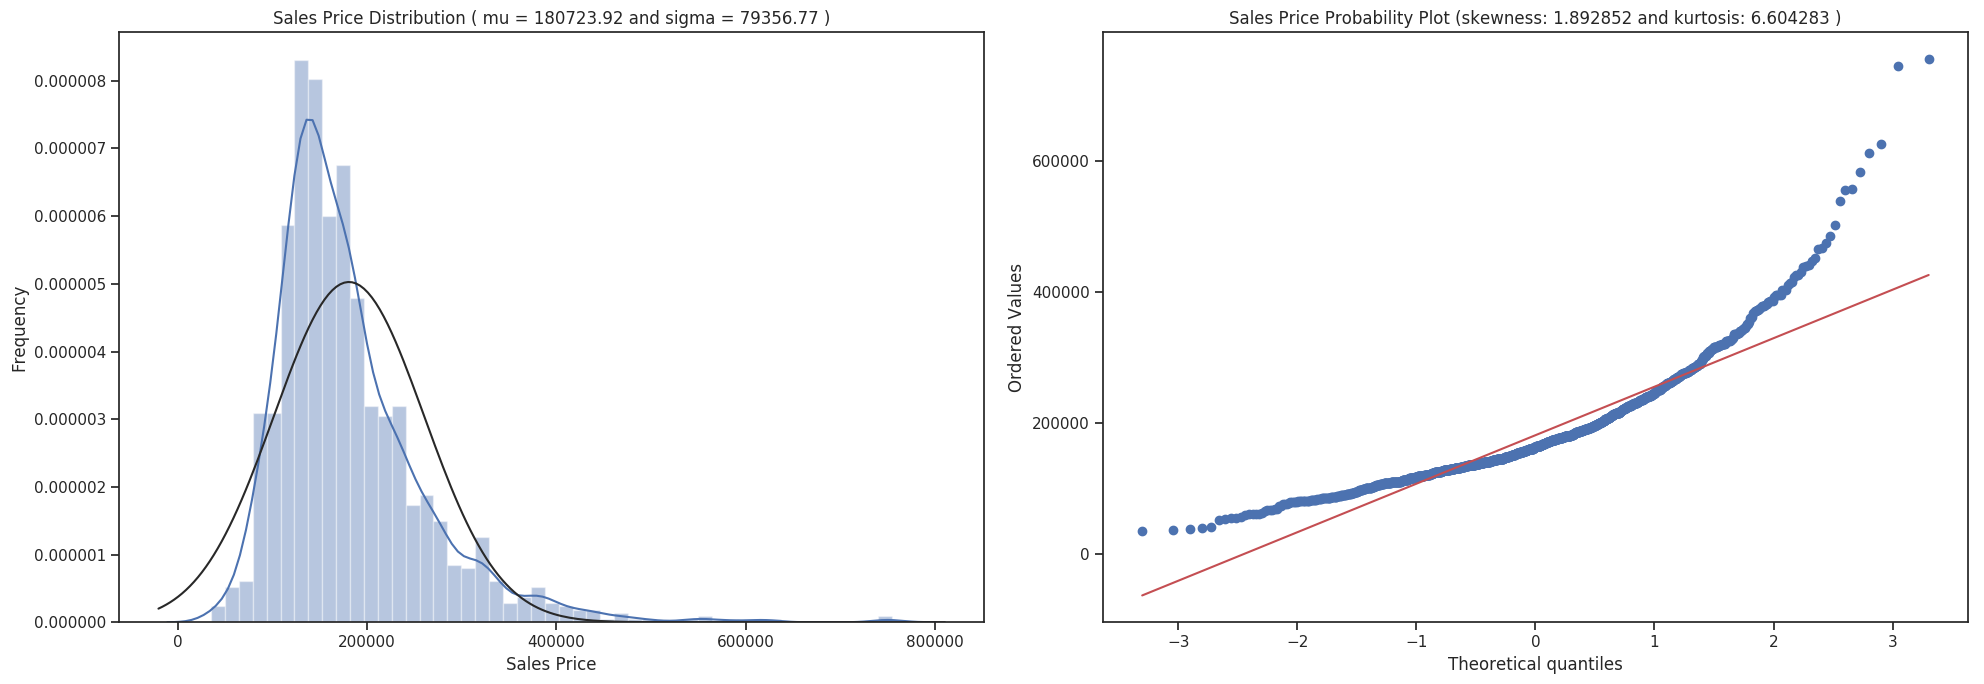

In [41]:
QQ_plot(train.SalePrice, 'Sales Price')

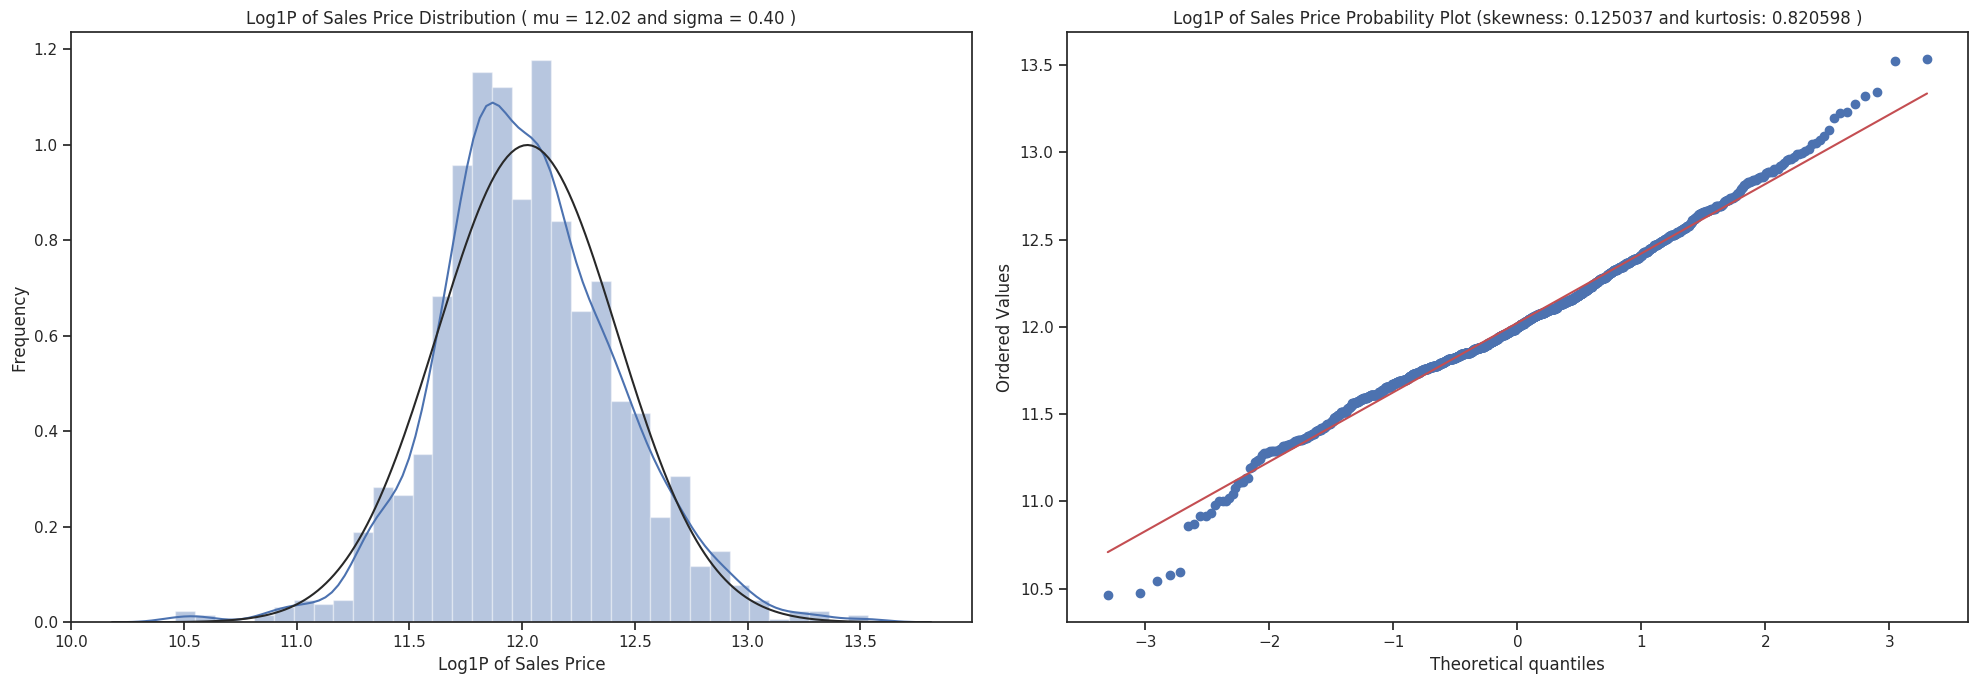

In [42]:
train.SalePrice = np.log1p(train.SalePrice)

QQ_plot(train.SalePrice, 'Log1P of Sales Price')

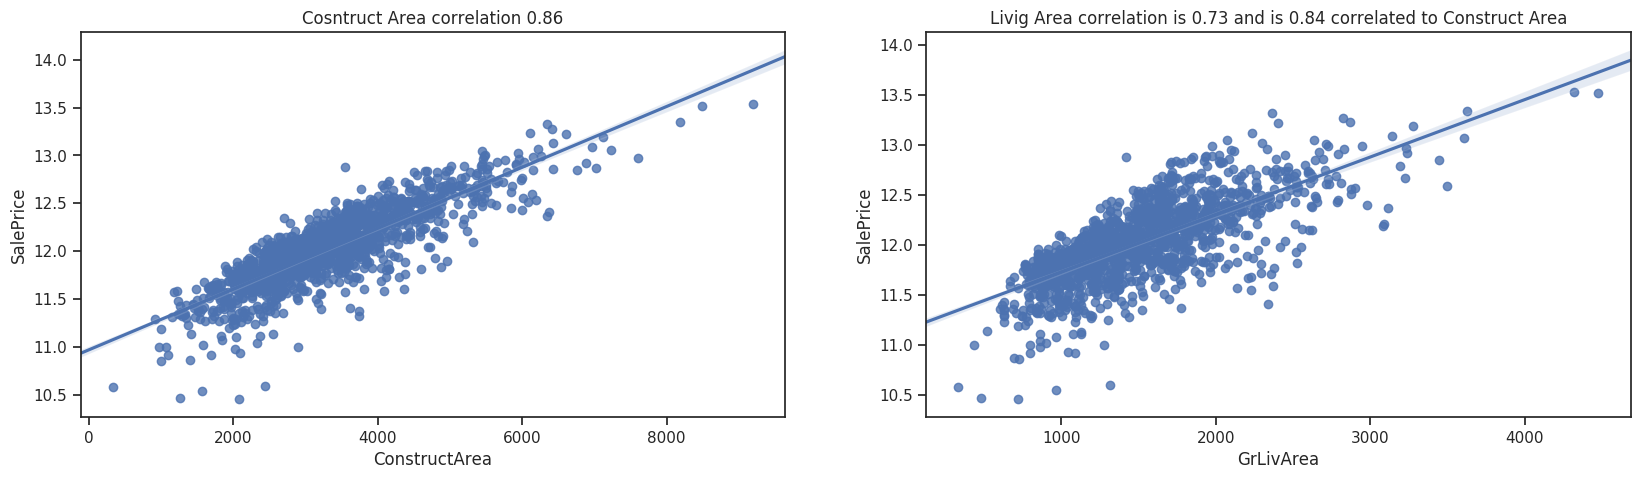

In [43]:
df = train[['SalePrice', 'GrLivArea']]
df['ConstructArea'] = (train.TotalBsmtSF.fillna(0) + train.WoodDeckSF.fillna(0) + train.GrLivArea.fillna(0) + 
                       train.MasVnrArea.fillna(0) + train.GarageArea.fillna(0) + train.OpenPorchSF.fillna(0) + 
                       train.TSsnPorch.fillna(0) + train.ScreenPorch.fillna(0) + train.EnclosedPorch.fillna(0) + 
                       train.PoolArea.fillna(0) )
                         
fig8 = plt.figure(figsize=(20,5))
fig9 = fig8.add_subplot(121); sns.regplot((df.ConstructArea), df.SalePrice)
plt.title('Cosntruct Area correlation {:1.2f}'.format(df.ConstructArea.corr(df.SalePrice)))

fig10 = fig8.add_subplot(122); sns.regplot((df.GrLivArea.fillna(0)), df.SalePrice)
tit = 'Livig Area correlation is {:1.2f} and is {:1.2f} correlated to Construct Area'
plt.title(tit.format(df.GrLivArea.fillna(0).corr(df.SalePrice), df.GrLivArea.corr(df.ConstructArea)))
plt.show()

In [45]:
def print_results():
    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean squared error
    print("Root mean squared error: %.4f"
          % np.expm1(np.sqrt(mean_squared_error(y_test, y_pred))))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.4f' % r2_score(y_test, y_pred))
    print('--------------------------------------------------------------------------------\n')
    
scale = RobustScaler()
y = df.SalePrice

X = scale.fit_transform(df[['ConstructArea', 'GrLivArea']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

lr = LinearRegression()

print('1. Linear regressor with only living Area:')
lr.fit(X_train[: , 1].reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred = lr.predict(X_test[: , 1].reshape(-1, 1))
print_results()

print('2. Linear regressor with bouth features:')
lr.fit(X_train, y_train)

# Makepredictions using the testing set
y_pred = lr.predict(X_test)
print_results()

print('3. Linear regressor with only Construct Area:')
lr = LinearRegression()
lr.fit(X_train[: , 0].reshape(-1, 1), y_train)

# Makepredictions using the testing set
y_pred = lr.predict(X_test[: , 0].reshape(-1, 1))
print_results()

print('4. Polinomial regressor of orden 3 with only Construction Area:')
# create polynomial features
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_cubic = cubic.fit_transform(X_train[: , 0].reshape(-1, 1))

# cubic fit
lr = lr.fit(X_cubic, y_train)
y_pred = lr.predict(cubic.fit_transform(X_test[: , 0].reshape(-1, 1)))
print_results()

print('5. Polinomial regressor of orden 3 with both features:')
# create polynomial features
cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
X_cubic = cubic.fit_transform(X_train)

# cubic fit
lr = lr.fit(X_cubic, y_train)
y_pred = lr.predict(cubic.fit_transform(X_test))
print_results()

1. Linear regressor with only living Area:
Coefficients: 
 [0.36893072]
Root mean squared error: 0.3062
Variance score: 0.5745
--------------------------------------------------------------------------------

2. Linear regressor with bouth features:
Coefficients: 
 [0.41566342 0.01475978]
Root mean squared error: 0.2312
Variance score: 0.7420
--------------------------------------------------------------------------------

3. Linear regressor with only Construct Area:
Coefficients: 
 [0.42751224]
Root mean squared error: 0.2315
Variance score: 0.7414
--------------------------------------------------------------------------------

4. Polinomial regressor of orden 3 with only Construction Area:
Coefficients: 
 [ 0.44262676 -0.05030931  0.00836013]
Root mean squared error: 0.2276
Variance score: 0.7492
--------------------------------------------------------------------------------

5. Polinomial regressor of orden 3 with both features:
Coefficients: 
 [ 0.41977881  0.03337517 -0.0547538

In [46]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)

print("All data observations have {0} rows and {1} columns".format(all_data.shape[0], all_data.shape[1]))
details = rstr(all_data)
print("All data have {1:2.2%} of null at {0} features".format(details[details.nulls>0].shape[0], 
                                                   details.nulls[details.nulls>0].sum()/all_data.size))
print('\nBelow the table with all columns with nulls oredered by missin ration:')
display(details.loc[(details.nulls>0), 'types':'uniques'].sort_values(by= 'missing ration', ascending=False))

All data observations have 2910 rows and 80 columns
Data shape: (2910, 80)
___________________________
Data types:
 object     43
int64      25
float64    12
Name: types, dtype: int64
___________________________
All data have 5.98% of null at 34 features

Below the table with all columns with nulls oredered by missin ration:


types  ...                                            uniques
PoolQC         object  ...                                [[nan, Ex, Fa, Gd]]
MiscFeature    object  ...                    [[nan, Shed, Gar2, Othr, TenC]]
Alley          object  ...                                [[nan, Grvl, Pave]]
Fence          object  ...                  [[nan, MnPrv, GdWo, GdPrv, MnWw]]
FireplaceQu    object  ...                        [[nan, TA, Gd, Fa, Ex, Po]]
LotFrontage   float64  ...  [[65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, na...
GarageCond     object  ...                        [[TA, Fa, nan, Gd, Po, Ex]]
GarageQual     object  ...                        [[TA, Fa, Gd, nan, Ex, Po]]
GarageYrBlt   float64  ...  [[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993...
GarageFinish   object  ...                             [[RFn, Unf, Fin, nan]]
GarageType     object  ...  [[Attchd, Detchd, BuiltIn, CarPort, nan, Basme...
BsmtExposure   object  ...                            [[No, Gd, Mn, Av, nan]]
BsmtCond       object  ...                            [[TA, Gd, nan, Fa, Po]]
BsmtQual       object  ...                            [[Gd, TA, Ex, nan, Fa]]
BsmtFinType2   object  ...              [[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]]
BsmtFinType1   object  ...              [[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]]
MasVnrType     object  ...              [[BrkFace, None, Stone, BrkCmn, nan]]
MasVnrArea    float64  ...  [[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286....
MSZoning       object  ...                   [[RL, RM, C (all), FV, RH, nan]]
Utilities      object  ...                            [[AllPub, NoSeWa, nan]]
Functional     object  ...     [[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev, nan]]
BsmtHalfBath  float64  ...                             [[0.0, 1.0, 2.0, nan]]
BsmtFullBath  float64  ...                        [[1.0, 0.0, 2.0, 3.0, nan]]
GarageCars    float64  ...              [[2.0, 3.0, 1.0, 0.0, 4.0, 5.0, nan]]
Exterior2nd    object  ...  [[VinylSd, MetalSd, Wd Shng, HdBoard, Plywood,...
Exterior1st    object  ...  [[VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace,...
KitchenQual    object  ...                            [[Gd, TA, Ex, Fa, nan]]
Electrical     object  ...           [[SBrkr, FuseF, FuseA, FuseP, Mix, nan]]
BsmtUnfSF     float64  ...  [[150.0, 284.0, 434.0, 540.0, 490.0, 64.0, 317...
BsmtFinSF2    float64  ...  [[0.0, 32.0, 668.0, 486.0, 93.0, 491.0, 506.0,...
BsmtFinSF1    float64  ...  [[706.0, 978.0, 486.0, 216.0, 655.0, 732.0, 13...
SaleType       object  ...  [[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con,...
TotalBsmtSF   float64  ...  [[856.0, 1262.0, 920.0, 756.0, 1145.0, 796.0, ...
GarageArea    float64  ...  [[548.0, 460.0, 608.0, 642.0, 836.0, 480.0, 63...

[34 rows x 6 columns]

In [0]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """
        Impute missing values:
        - Columns of dtype object are imputed with the most frequent value in column.
        - Columns of other types are imputed with mean of column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [0]:
all_data.drop('Utilities', axis=1, inplace=True)

In [51]:
display(all_data.Electrical.value_counts())

all_data.Electrical = all_data.Electrical.fillna('SBrkr')

SBrkr    2664
FuseA     187
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [53]:
feat = ['GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars']
print(all_data[feat].isnull().sum())
print("GarageArea equal a 0: ", (all_data.GarageArea==0).sum())
print("GarageCars equal a 0: ", (all_data.GarageCars==0).sum())
c = all_data[~all_data.GarageType.isnull()][feat]
c[c.GarageYrBlt.isnull()]

GarageYrBlt     158
GarageType      156
GarageFinish    158
GarageQual      158
GarageCond      158
GarageArea        1
GarageCars        1
dtype: int64
GarageArea equal a 0:  156
GarageCars equal a 0:  156


GarageYrBlt GarageType GarageFinish  ... GarageCond GarageArea  GarageCars
2117          nan     Detchd          NaN  ...        NaN    360.000       1.000
2567          nan     Detchd          NaN  ...        NaN        nan         nan

[2 rows x 7 columns]

In [54]:
all_data.GarageType = all_data.GarageType.fillna('NA')

# Group by GarageType and fill missing value with median where GarageType=='Detchd' and 0 for the others
cmedian = all_data[all_data.GarageType=='Detchd'].GarageArea.median()
print("GarageArea median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageArea'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageArea'].fillna(cmedian)
all_data.GarageArea = all_data.GarageArea.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageCars.median()
print("GarageCars median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCars'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCars'].fillna(cmedian)
all_data.GarageCars = all_data.GarageCars.fillna(0)

cmedian = all_data[all_data.GarageType=='Detchd'].GarageYrBlt.median()
print("GarageYrBlt median of Type Detchd:", cmedian)
all_data.loc[all_data.GarageType=='Detchd', 'GarageYrBlt'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                          'GarageYrBlt'].fillna(cmedian)
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(0)

# Group by GarageType and fill missing value with mode where GarageType=='Detchd' and 'NA' for the others
cmode = all_data[all_data.GarageType=='Detchd'].GarageFinish.mode()[0]
print("GarageFinish mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageFinish'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                           'GarageFinish'].fillna(cmode)
all_data.GarageFinish = all_data.GarageFinish.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageQual.mode()[0]
print("GarageQual mode of Type Detchd: %s" %cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageQual'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageQual'].fillna(cmode)
all_data.GarageQual = all_data.GarageQual.fillna('NA')

cmode = all_data[all_data.GarageType=='Detchd'].GarageCond.mode()[0]
print("GarageCond mode of Type Detchd:", cmode)
all_data.loc[all_data.GarageType=='Detchd', 'GarageCond'] = all_data.loc[all_data.GarageType=='Detchd', 
                                                                         'GarageCond'].fillna(cmode)
all_data.GarageCond = all_data.GarageCond.fillna('NA')

GarageArea median of Type Detchd: 397.5
GarageCars median of Type Detchd: 2.0
GarageYrBlt median of Type Detchd: 1962.0
GarageFinish mode of Type Detchd: Unf
GarageQual mode of Type Detchd: TA
GarageCond mode of Type Detchd: TA


In [55]:
print(all_data[feat].isnull().sum())

GarageYrBlt     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageArea      0
GarageCars      0
dtype: int64


In [56]:
feat = ['MasVnrArea', 'MasVnrType']
c = all_data[~all_data.MasVnrArea.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')
print("Has MasVnrType but not has MasVnrArea:",all_data[~all_data.MasVnrType.isnull()].MasVnrArea.isnull().sum())
print("Has MasVnrArea but not has MasVnrType:",c[c.MasVnrType.isnull()].MasVnrArea.count())
print(c[c.MasVnrType.isnull()], '\n')

print("Has MasVnrType but MasVnrArea is equal a Zero:",c[c.MasVnrArea==0].MasVnrType.count())
print("MasVnrArea equal a 0: ", (all_data.MasVnrArea==0).sum(), '\n')
print("Has Type and Area == 0:")
print(c[c.MasVnrArea==0].MasVnrType.value_counts(), '\n')

print("Type None with Area > 0 ?")
print(all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType','MasVnrArea']])

print('\n What is the most comumn MasVnrType after None?')
print(all_data.MasVnrType.value_counts())

Masonry veneer Nulls:
MasVnrArea    23
MasVnrType    24
dtype: int64 

Has MasVnrType but not has MasVnrArea: 0
Has MasVnrArea but not has MasVnrType: 1
      MasVnrArea MasVnrType
2601     198.000        NaN 

Has MasVnrType but MasVnrArea is equal a Zero: 1736
MasVnrArea equal a 0:  1736 

Has Type and Area == 0:
None       1733
BrkFace       2
Stone         1
Name: MasVnrType, dtype: int64 

Type None with Area > 0 ?
     MasVnrType  MasVnrArea
622        None     288.000
770        None       1.000
1224       None       1.000
1293       None     344.000
1327       None     312.000
1660       None     285.000
2443       None       1.000

 What is the most comumn MasVnrType after None?
None       1740
BrkFace     877
Stone       244
BrkCmn       25
Name: MasVnrType, dtype: int64


In [0]:
# All None Types with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType=='None') & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types null with Are greater than 0 update to BrkFace type
all_data.loc[(all_data.MasVnrType.isnull()) & (all_data.MasVnrArea>0), ['MasVnrType']] = 'BrkFace'

# All Types different from None with Are equal to 0 update to median Area of no None types with Areas
all_data.loc[(all_data.MasVnrType!='None') & 
             (all_data.MasVnrArea==0), ['MasVnrArea']] = all_data.loc[(all_data.MasVnrType!='None') & 
                                                                      (all_data.MasVnrArea>0), ['MasVnrArea']].median()[0]
# Filling 0 and None for records wheres both are nulls
all_data.MasVnrArea = all_data.MasVnrArea.fillna(0)
all_data.MasVnrType = all_data.MasVnrType.fillna('None')

In [58]:
c = all_data[~all_data.MasVnrType.isnull()][feat]
print('Masonry veneer Nulls:')
print(all_data[feat].isnull().sum(), '\n')

Masonry veneer Nulls:
MasVnrArea    0
MasVnrType    0
dtype: int64 



In [59]:
feat = ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath', 
        'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
print(all_data[feat].isnull().sum())
print("BsmtFinSF1 equal a 0: ", (all_data.BsmtFinSF1==0).sum())
print("BsmtFinSF2 equal a 0: ", (all_data.BsmtFinSF2==0).sum())
print("BsmtUnfSF equal a 0: ", (all_data.BsmtUnfSF==0).sum())
print("TotalBsmtSF equal a 0: ", (all_data.TotalBsmtSF==0).sum())
print("BsmtFullBath equal a 0: ", (all_data.BsmtFullBath==0).sum())
print("BsmtHalfBath equal a 0: ", (all_data.BsmtHalfBath==0).sum())

BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
BsmtFullBath     2
BsmtHalfBath     2
BsmtQual        81
BsmtCond        82
BsmtExposure    82
BsmtFinType1    79
BsmtFinType2    80
dtype: int64
BsmtFinSF1 equal a 0:  927
BsmtFinSF2 equal a 0:  2562
BsmtUnfSF equal a 0:  241
TotalBsmtSF equal a 0:  78
BsmtFullBath equal a 0:  1702
BsmtHalfBath equal a 0:  2736


In [61]:
# No Basement Av is the most comumn BsmtExposure. 
display(all_data.BsmtExposure.value_counts())

# Update nulls Exposure to Av wheres TotalBsmntSF is grenter tham zero 
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtExposure.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtExposure'] = 'Av'

No    1900
Av     420
Gd     272
Mn     239
Name: BsmtExposure, dtype: int64

In [62]:
# TA is the most comumn BsmtQual. 
display(all_data.BsmtQual.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & 
             (all_data.BsmtQual.isnull()) & 
             (all_data.TotalBsmtSF>0), 'BsmtQual'] = 'TA'

TA    1279
Gd    1209
Ex     253
Fa      88
Name: BsmtQual, dtype: int64

In [64]:
# TA is the most comumn BsmtCond. 
display(all_data.BsmtCond.value_counts())

# We use TA for all cases wheres has same evidenci that the house has Basement
all_data.loc[(~all_data.TotalBsmtSF.isnull()) & (all_data.BsmtCond.isnull()) & (all_data.TotalBsmtSF>0), 'BsmtCond'] = 'TA'

TA    2601
Gd     122
Fa     103
Po       5
Name: BsmtCond, dtype: int64

In [65]:
# Unf is the most comumn BsmtFinType2. 
display(all_data.BsmtFinType2.value_counts())

# We use Unf for all cases wheres BsmtFinType2 is null but BsmtFinSF2 is grater than Zro
all_data.loc[(all_data.BsmtFinSF2>0) & (all_data.BsmtFinType2.isnull()) , 'BsmtFinType2'] = 'Unf'

Unf    2484
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [66]:
# See below that we have one case where BsmtFinType2 is BLQ and the Area is Zero, but its area was inputed at Unfinesh
display(all_data[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull())][feat])

# Correct BsmtFinSF2 and BsmtUnfSF:
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtFinSF2'] = 354.0
all_data.loc[(all_data.BsmtFinSF2==0) & (all_data.BsmtFinType2!='Unf') & (~all_data.BsmtFinType2.isnull()), 'BsmtUnfSF'] = 0.0

BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  BsmtExposure  BsmtFinType1  BsmtFinType2
1461    1051.000       0.000    354.000  ...            No           GLQ           BLQ

[1 rows x 11 columns]

In [67]:
# All these cases are clear don´t have basement. 
print("Rest cases where Cond is Null", (all_data[all_data.BsmtCond.isnull()]).shape[0], '\n')
print('Others categories basement features are Null when Cond is Null:\n',
      (all_data[all_data.BsmtCond.isnull()][['BsmtQual', 'BsmtCond', 'BsmtExposure',
                                             'BsmtFinType1' , 'BsmtFinType2']]).isnull().sum())
print('\nOthers numerics basement features are Null or Zero when Cond is Null:\n',
      all_data[all_data.BsmtCond.isnull()][['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' ,'TotalBsmtSF',
                                            'BsmtFullBath', 'BsmtHalfBath']].sum())
print("\nThe particular cases where's numeric basement features see below are Null were included in the previous groups:") 
display(all_data[all_data.BsmtFullBath.isnull()][feat])

# So, we update these Zero or NA according to their dictionary:
nulls_cols = {'BsmtExposure': 'NA', 'BsmtFinType2': 'NA', 'BsmtQual': 'NA', 'BsmtCond': 'NA', 'BsmtFinType1': 'NA',
              'BsmtFinSF1': 0, 'BsmtFinSF2': 0, 'BsmtUnfSF': 0 ,'TotalBsmtSF': 0, 'BsmtFullBath': 0, 'BsmtHalfBath': 0}

all_data = all_data.fillna(value=nulls_cols)

print('\nFinal Check if all nulls basement features are treated:', all_data[feat].isnull().sum().sum())

Rest cases where Cond is Null 79 

Others categories basement features are Null when Cond is Null:
 BsmtQual        79
BsmtCond        79
BsmtExposure    79
BsmtFinType1    79
BsmtFinType2    79
dtype: int64

Others numerics basement features are Null or Zero when Cond is Null:
 BsmtFinSF1     0.000
BsmtFinSF2     0.000
BsmtUnfSF      0.000
TotalBsmtSF    0.000
BsmtFullBath   0.000
BsmtHalfBath   0.000
dtype: float64

The particular cases where's numeric basement features see below are Null were included in the previous groups:


BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  BsmtExposure  BsmtFinType1  BsmtFinType2
2111         nan         nan        nan  ...           NaN           NaN           NaN
2179       0.000       0.000      0.000  ...           NaN           NaN           NaN

[2 rows x 11 columns]


Final Check if all nulls basement features are treated: 0


In [0]:
# Group by Neigborhood and fill missing value with Lot frontage median of the respect Neigborhood
NegMean = all_data.groupby('Neighborhood').LotFrontage.mean()

all_data.loc.LotFrontage = all_data[['Neighborhood', 'LotFrontage']].\
                           apply(lambda x: NegMean[x.Neighborhood] if np.isnan(x.LotFrontage) else x.LotFrontage, axis=1)

In [0]:
PoolQC = {0: 'NA', 1: 'Po', 2: 'Fa', 3: 'TA', 4: 'Gd', 5: 'Ex'}

all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['PoolQC']] =\
        ((all_data.loc[(all_data.PoolArea>0) & (all_data.PoolQC.isnull()), ['OverallQual']]/2).round()).\
        apply(lambda x: x.map(PoolQC))

all_data.PoolQC = all_data.PoolQC.fillna('NA')

In [0]:
all_data.Functional = all_data.Functional.fillna('Typ')

In [0]:
all_data.loc[(all_data.Fireplaces==0) & (all_data.FireplaceQu.isnull()), ['FireplaceQu']] = 'NA'

In [0]:
all_data.loc[(all_data.KitchenAbvGr>0) & (all_data.KitchenQual.isnull()), 
             ['KitchenQual']] = all_data.KitchenQual.mode()[0]

In [0]:
all_data.Alley = all_data.Alley.fillna('NA')
all_data.Fence = all_data.Fence.fillna('NA')
all_data.MiscFeature = all_data.MiscFeature.fillna('NA')

In [74]:
display(all_data.loc[all_data.GarageYrBlt==2207, ['GarageYrBlt', 'YearBuilt']])
all_data.loc[all_data.GarageYrBlt==2207.0, 'GarageYrBlt'] = 2007.0

GarageYrBlt  YearBuilt
2583     2207.000       2006

In [75]:
all_data = DataFrameImputer().fit_transform(all_data)

# Final check if we have some NA
print("Data nulls:", all_data.isnull().sum().sum())

Data nulls: 0


In [0]:
def map_ordinals(data):
    
    # LandSlope: Slope of property
    LandSlope = {}
    LandSlope['Gtl'] = 3 #'Gentle slope'
    LandSlope['Mod'] = 2 #'Moderate Slope'
    LandSlope['Sev'] = 1 #'Severe Slope'

    data.LandSlope = data.LandSlope.map(LandSlope)
        
    # ExterQual: Evaluates the quality of the material on the exterior 
    ExterQual = {}
    ExterQual['Ex'] = 5 #'Excellent'
    ExterQual['Gd'] = 4 #'Good'
    ExterQual['TA'] = 3 #'Average/Typical'
    ExterQual['Fa'] = 2 #'Fair'
    ExterQual['Po'] = 1 #'Poor'
    ExterQual['NA'] = 0 #'NA'

    data.ExterQual = data.ExterQual.map(ExterQual)

    # ExterCond: Evaluates the present condition of the material on the exterior
    data.ExterCond = data.ExterCond.map(ExterQual)

    #HeatingQC: Heating quality and condition
    data.HeatingQC = data.HeatingQC.map(ExterQual)

    # KitchenQual: Kitchen quality
    data.KitchenQual = data.KitchenQual.map(ExterQual)

    # FireplaceQu: Fireplace quality
    data.FireplaceQu = data.FireplaceQu.map(ExterQual)

    # GarageCond: Garage Conditionals
    data.GarageCond = data.GarageCond.map(ExterQual)

    PavedDrive = {}
    PavedDrive['Y'] = 3 #'Paved'
    PavedDrive['P'] = 2 #'Partial Pavement'
    PavedDrive['N'] = 1 #'Dirt/Gravel'

    data.PavedDrive = data.PavedDrive.map(PavedDrive)

    # LotShape: General shape of property
    LotShape = {}
    LotShape['Reg'] = 4 #'Regular'
    LotShape['IR1'] = 3 #'Slightly irregular'
    LotShape['IR2'] = 2 #'Moderately Irregular'
    LotShape['IR3'] = 1 #'Irregular'

    data.LotShape = data.LotShape.map(LotShape)

    # BsmtQual: Evaluates the height of the basement
    BsmtQual = {}
    BsmtQual['Ex'] = 5 #'Excellent (100+ inches)'
    BsmtQual['Gd'] = 4 #'Good (90-99 inches)'
    BsmtQual['TA'] = 3 #'Typical (80-89 inches)'
    BsmtQual['Fa'] = 2 #'Fair (70-79 inches)'
    BsmtQual['Po'] = 1 #'Poor (<70 inches'
    BsmtQual['NA'] = 0 #'No Basement'

    data.BsmtQual = data.BsmtQual.map(BsmtQual)

    # BsmtCond: Evaluates the general condition of the basement
    data.BsmtCond = data.BsmtCond.map(BsmtQual)

    # GarageQual: Garage quality
    data.GarageQual = data.GarageQual.map(BsmtQual)

    # PoolQC: Pool quality
    data.PoolQC = data.PoolQC.map(BsmtQual)
    
    # BsmtExposure: Refers to walkout or garden level walls
    BsmtExposure = {}
    BsmtExposure['Gd'] = 4 #'Good Exposure'
    BsmtExposure['Av'] = 3 #'Average Exposure (split levels or foyers typically score average or above)'
    BsmtExposure['Mn'] = 2 #'Mimimum Exposure'
    BsmtExposure['No'] = 1 #'No Exposure'
    BsmtExposure['NA'] = 0 #'No Basement'

    data.BsmtExposure = data.BsmtExposure.map(BsmtExposure)

    # BsmtFinType1: Rating of basement finished area
    BsmtFinType1 = {}
    BsmtFinType1['GLQ'] = 6 #'Good Living Quarters'
    BsmtFinType1['ALQ'] = 5 # 'Average Living Quarters'
    BsmtFinType1['BLQ'] = 4 # 'Below Average Living Quarters'
    BsmtFinType1['Rec'] = 3 # 'Average Rec Room'
    BsmtFinType1['LwQ'] = 2 # 'Low Quality'
    BsmtFinType1['Unf'] = 1 # 'Unfinshed'
    BsmtFinType1['NA'] = 0 #'No Basement'

    data.BsmtFinType1 = data.BsmtFinType1.map(BsmtFinType1)

    # BsmtFinType2: Rating of basement finished area (if multiple types)
    data.BsmtFinType2 = data.BsmtFinType2.map(BsmtFinType1)

    #CentralAir: Central air conditioning
    # Since with this transformatio as the same as binarize this feature
    CentralAir = {}
    CentralAir['N'] = 0
    CentralAir['Y'] = 1

    data.CentralAir = data.CentralAir.map(CentralAir)

    # GarageFinish: Interior finish of the garage
    GarageFinish = {}
    GarageFinish['Fin'] = 3 #'Finished'
    GarageFinish['RFn'] = 2 #'Rough Finished'
    GarageFinish['Unf'] = 1 #'Unfinished'
    GarageFinish['NA'] = 0 #'No Garage'
    
    data.GarageFinish = data.GarageFinish.map(GarageFinish)
    
    # Functional: Home functionality
    Functional = {}
    Functional['Typ'] = 7   # Typical Functionality
    Functional['Min1'] = 6  # Minor Deductions 1
    Functional['Min2'] = 5  # Minor Deductions 2
    Functional['Mod'] = 4   # Moderate Deductions
    Functional['Maj1'] = 3  # Major Deductions 1
    Functional['Maj2'] = 2  # Major Deductions 2
    Functional['Sev'] = 1   # Severely Damaged
    Functional['Sal'] = 0   # Salvage only

    data.Functional = data.Functional.map(Functional)
    
    #Street: Type of road access to property
    # Since with this transformatio as the same as binarize this feature
    Street = {}
    Street['Grvl'] = 0 # Gravel 
    Street['Pave'] = 1 # Paved

    data.Street = data.Street.map(Street)


    # Fence: Fence quality
    Fence = {}
    Fence['GdPrv'] = 5 #'Good Privacy'
    Fence['MnPrv'] = 4 #'Minimum Privacy'
    Fence['GdWo'] = 3 #'Good Wood'
    Fence['MnWw'] = 2 #'Minimum Wood/Wire'
    Fence['NA'] = 1 #'No Fence'

    data.Fence = data.Fence.map(Fence)
    #But No Fence has the higest median Sales Price. So I try to use it as categorical
            
    return data

all_data = map_ordinals(all_data)

In [77]:
display(all_data.loc[(all_data.PoolArea>0) & (all_data.MiscVal>0), ['MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC']])

MiscFeature  MiscVal  PoolArea  PoolQC
1378        TenC     2000       519       2

In [78]:
display(all_data.loc[(all_data.MiscFeature=='TenC'), ['MiscFeature', 'MiscVal', 'PoolArea', 'PoolQC']])

MiscFeature  MiscVal  PoolArea  PoolQC
1378        TenC     2000       519       2

In [0]:
all_data.loc[(all_data.PoolArea>0), ['MiscFeature']] = 'Pool'
all_data.loc[(all_data.PoolArea>0), ['MiscVal']] = all_data.loc[(all_data.PoolArea>0), 
                                                               ['MiscVal', 'PoolArea']].\
                                                                apply(lambda x: (x.MiscVal + x.PoolArea), axis=1)



In [0]:
all_data['TotalExtraPoints'] = all_data.HeatingQC + all_data.PoolQC + all_data.FireplaceQu  + all_data.KitchenQual
all_data['TotalPoints'] =  (all_data.ExterQual + all_data.FireplaceQu + all_data.GarageQual + all_data.KitchenQual +
                            all_data.BsmtQual + all_data.BsmtExposure + all_data.BsmtFinType1 + all_data.PoolQC + 
                            all_data.ExterCond + all_data.BsmtCond + all_data.GarageCond + all_data.OverallCond +
                            all_data.BsmtFinType2 + all_data.HeatingQC ) + all_data.OverallQual**2
                         
df = all_data.loc[(all_data.SalePrice>0), ['TotalPoints', 'TotalExtraPoints', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'PoolQC', 'KitchenQual', 
               'FireplaceQu', 'GarageQual', 'GarageCond', 'SalePrice']]

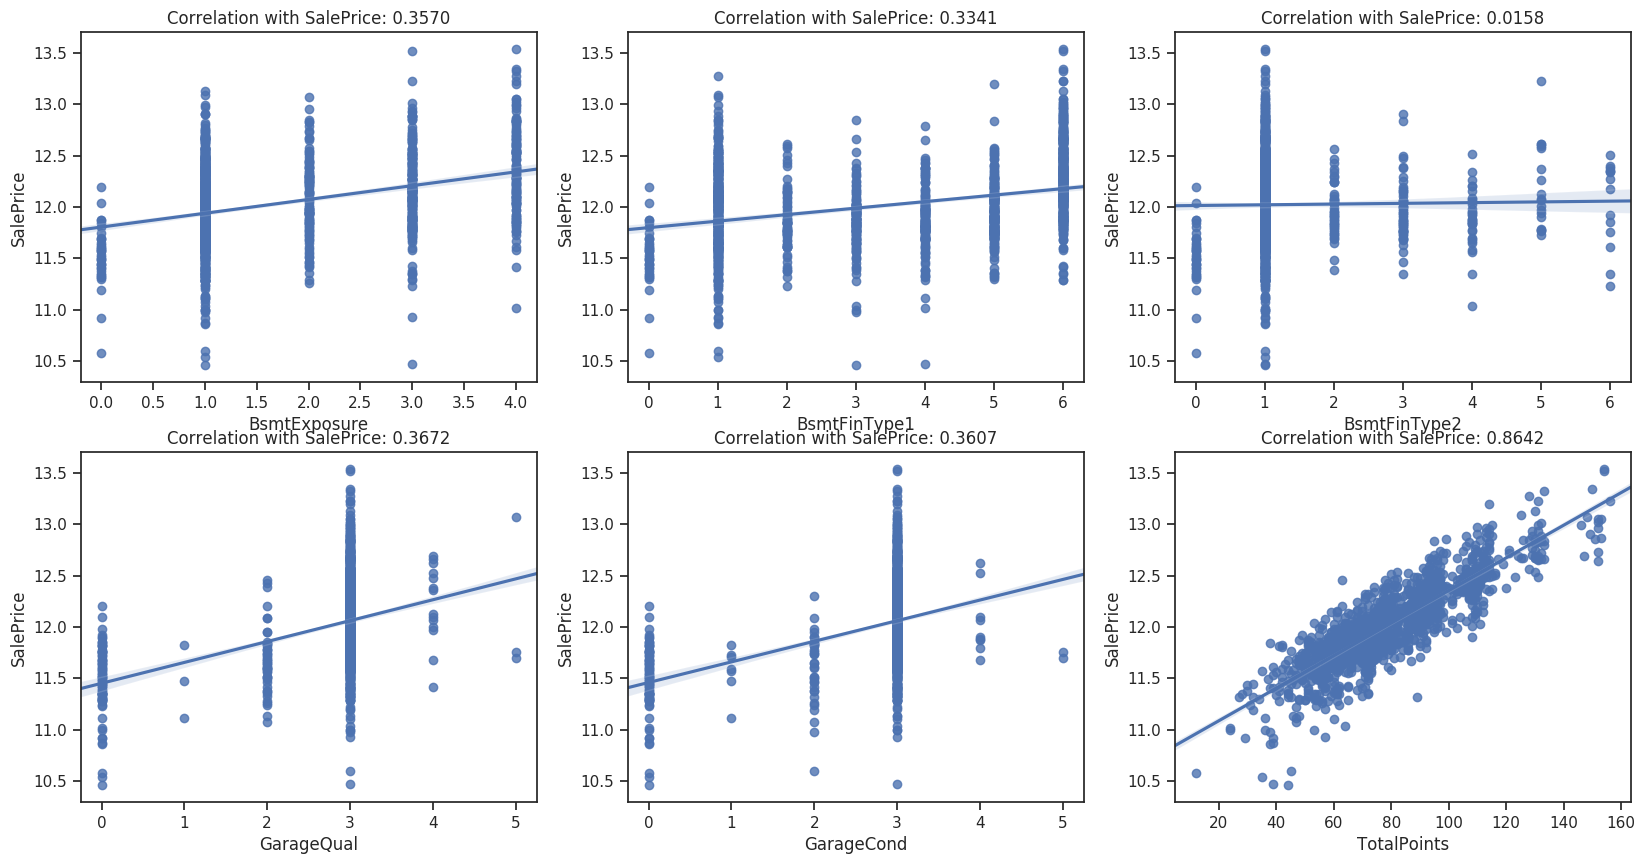

In [81]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='BsmtExposure', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.BsmtExposure.corr(df['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='BsmtFinType1', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.BsmtFinType1.corr(df['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='BsmtFinType2', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.BsmtFinType2.corr(df['SalePrice'])))

fig4 = fig.add_subplot(234); sns.regplot(x='GarageQual', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageQual.corr(df['SalePrice'])))

fig5 = fig.add_subplot(235); sns.regplot(x='GarageCond', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.GarageCond.corr(df['SalePrice'])))

fig6 = fig.add_subplot(236); sns.regplot(x='TotalPoints', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalPoints.corr(df['SalePrice'])))
plt.show()

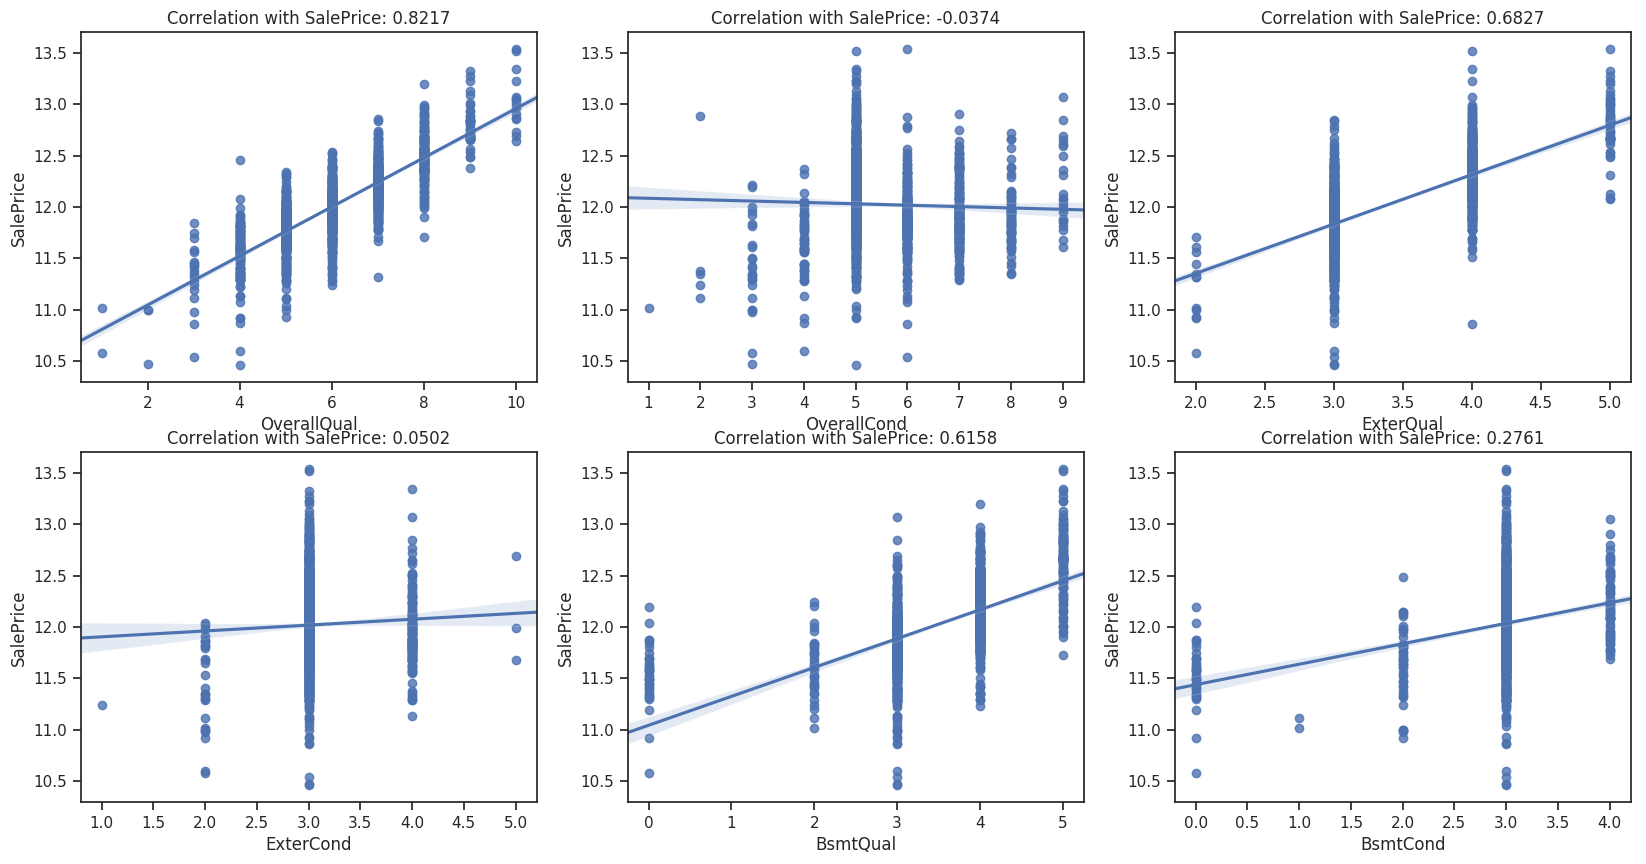

In [82]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='OverallQual', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.OverallQual.corr(df['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='OverallCond', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.OverallCond.corr(df['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='ExterQual', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.ExterQual.corr(df['SalePrice'])))

fig4 = fig.add_subplot(234); sns.regplot(x='ExterCond', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.ExterCond.corr(df['SalePrice'])))

fig5 = fig.add_subplot(235); sns.regplot(x='BsmtQual', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.BsmtQual.corr(df['SalePrice'])))

fig6 = fig.add_subplot(236); sns.regplot(x='BsmtCond', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.BsmtCond.corr(df['SalePrice'])))
plt.show()

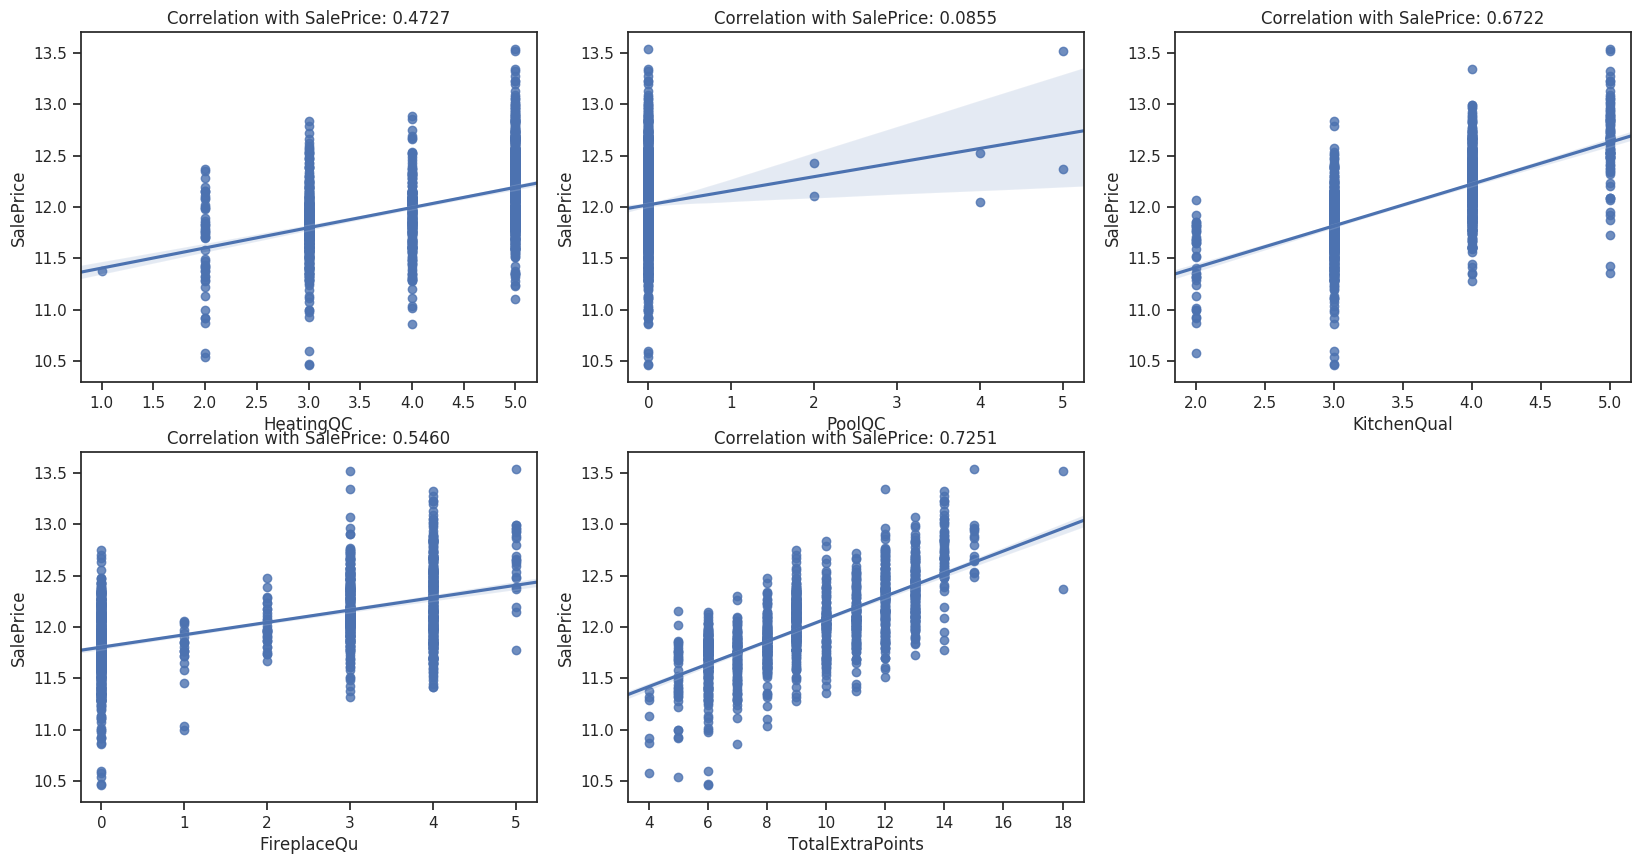

In [83]:
fig = plt.figure(figsize=(20,10))
fig1 = fig.add_subplot(231); sns.regplot(x='HeatingQC', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.HeatingQC.corr(df['SalePrice'])))

fig2 = fig.add_subplot(232); sns.regplot(x='PoolQC', y='SalePrice', data=df);
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.PoolQC.corr(df['SalePrice'])))

fig3 = fig.add_subplot(233); sns.regplot(x='KitchenQual', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.KitchenQual.corr(df['SalePrice'])))

fig4 = fig.add_subplot(234); sns.regplot(x='FireplaceQu', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.FireplaceQu.corr(df['SalePrice'])))

fig5 = fig.add_subplot(235); sns.regplot(x='TotalExtraPoints', y='SalePrice', data=df)
plt.title('Correlation with SalePrice: {:6.4f}'.format(df.TotalExtraPoints.corr(df['SalePrice'])))

plt.show()

In [0]:
all_data['GarageArea_x_Car'] = all_data.GarageArea * all_data.GarageCars

all_data['TotalBsmtSF_x_Bsm'] = all_data.TotalBsmtSF * all_data['1stFlrSF']

# We don´t have a feature with all construct area, maybe it is an interesting feature to create.
all_data['ConstructArea'] = (all_data.TotalBsmtSF + all_data.WoodDeckSF + all_data.GrLivArea +
                             all_data.OpenPorchSF + all_data.TSsnPorch + all_data.ScreenPorch + all_data.EnclosedPorch +
                             all_data.MasVnrArea + all_data.GarageArea + all_data.PoolArea )

#all_data['TotalArea'] = all_data.ConstructArea + all_data.LotArea

all_data['Garage_Newest'] = all_data.YearBuilt > all_data.GarageYrBlt
all_data.Garage_Newest =  all_data.Garage_Newest.apply(lambda x: 1 if x else 0)

all_data['TotalPorchSF'] = all_data.OpenPorchSF + all_data.EnclosedPorch + all_data.TSsnPorch + all_data.ScreenPorch + all_data.WoodDeckSF
all_data.EnclosedPorch = all_data.EnclosedPorch.apply(lambda x: 1 if x else 0)

all_data['LotAreaMultSlope'] = all_data.LotArea * all_data.LandSlope


all_data['BsmtSFPoints'] = (all_data.BsmtQual**2 + all_data.BsmtCond + all_data.BsmtExposure + 
                            all_data.BsmtFinType1 + all_data.BsmtFinType2)


all_data['BsmtSFMultPoints'] = all_data.TotalBsmtSF * (all_data.BsmtQual**2 + all_data.BsmtCond + all_data.BsmtExposure + 
                                                       all_data.BsmtFinType1 + all_data.BsmtFinType2)

all_data['TotBathrooms'] = all_data.FullBath + (all_data.HalfBath*0.5) + all_data.BsmtFullBath + (all_data.BsmtHalfBath*0.5)
all_data.FullBath = all_data.FullBath.apply(lambda x: 1 if x else 0)
all_data.HalfBath = all_data.HalfBath.apply(lambda x: 1 if x else 0)
all_data.BsmtFullBath = all_data.BsmtFullBath.apply(lambda x: 1 if x else 0)
all_data.BsmtHalfBath = all_data.BsmtHalfBath.apply(lambda x: 1 if x else 0)

In [0]:
def one_hot_encode(df):
    categorical_cols = df.select_dtypes(include=['object']).columns

    print(len(categorical_cols), "categorical columns")
    print(categorical_cols)
    # Remove special charactres and withe spaces. 
    for col in categorical_cols:
        df[col] = df[col].str.replace('\W', '').str.replace(' ', '_') #.str.lower()

    dummies = pd.get_dummies(df[categorical_cols], columns = categorical_cols).columns
    df = pd.get_dummies(df, columns = categorical_cols)

    print("Total Columns:",len(df.columns))
    print(df.info())
    
    return df, dummies
  
    all_data.MSSubClass = all_data.MSSubClass.astype('str')
    all_data.MoSold = all_data.MoSold.astype('str')

    all_data, dummies = one_hot_encode(all_data)

In [132]:
# Find Dummies with all test observatiosn are equal to 0
ZeroTest = all_data[dummies][ntrain:].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
print('Dummins in test dataset with all observatios equal to 0:',len(dummies[ZeroTest]),'of \n',dummies[ZeroTest],'\n')
dummies = dummies.drop(dummies[ZeroTest])

# Find dummies with all training observatiosn are equal to 0
ZeroTest = all_data[dummies][:ntrain].sum()==0
all_data.drop(dummies[ZeroTest], axis=1, inplace=True)
print('Dummins in trainig dataset with all observatios equal to 0:',len(dummies[ZeroTest]),'of \n',dummies[ZeroTest],'\n')
dummies = dummies.drop(dummies[ZeroTest])

del ZeroTest

Dummins in test dataset with all observatios equal to 0: 0 of 
 Index([], dtype='object') 

Dummins in trainig dataset with all observatios equal to 0: 0 of 
 Index([], dtype='object') 



In [0]:
def AgeYears(feature): 
    return feature.apply(lambda x: 0 if x==0 else (2011 - x))

all_data.YearBuilt = AgeYears(all_data.YearBuilt)
all_data.YearRemodAdd = AgeYears(all_data.YearRemodAdd)
all_data.GarageYrBlt = AgeYears(all_data.GarageYrBlt) 
all_data.YrSold =  AgeYears(all_data.YrSold) 

In [0]:
all_data['Remod'] = 2
all_data.loc[(all_data.YearBuilt==all_data.YearRemodAdd), ['Remod']] = 0
all_data.loc[(all_data.YearBuilt!=all_data.YearRemodAdd), ['Remod']] = 1

all_data.Age = all_data.YearRemodAdd - all_data.YrSold # sice I convert both to age

all_data["IsNew"] = 2
all_data.loc[(all_data.YearBuilt==all_data.YrSold), ['IsNew']] = 1
all_data.loc[(all_data.YearBuilt!=all_data.YrSold), ['IsNew']] = 0

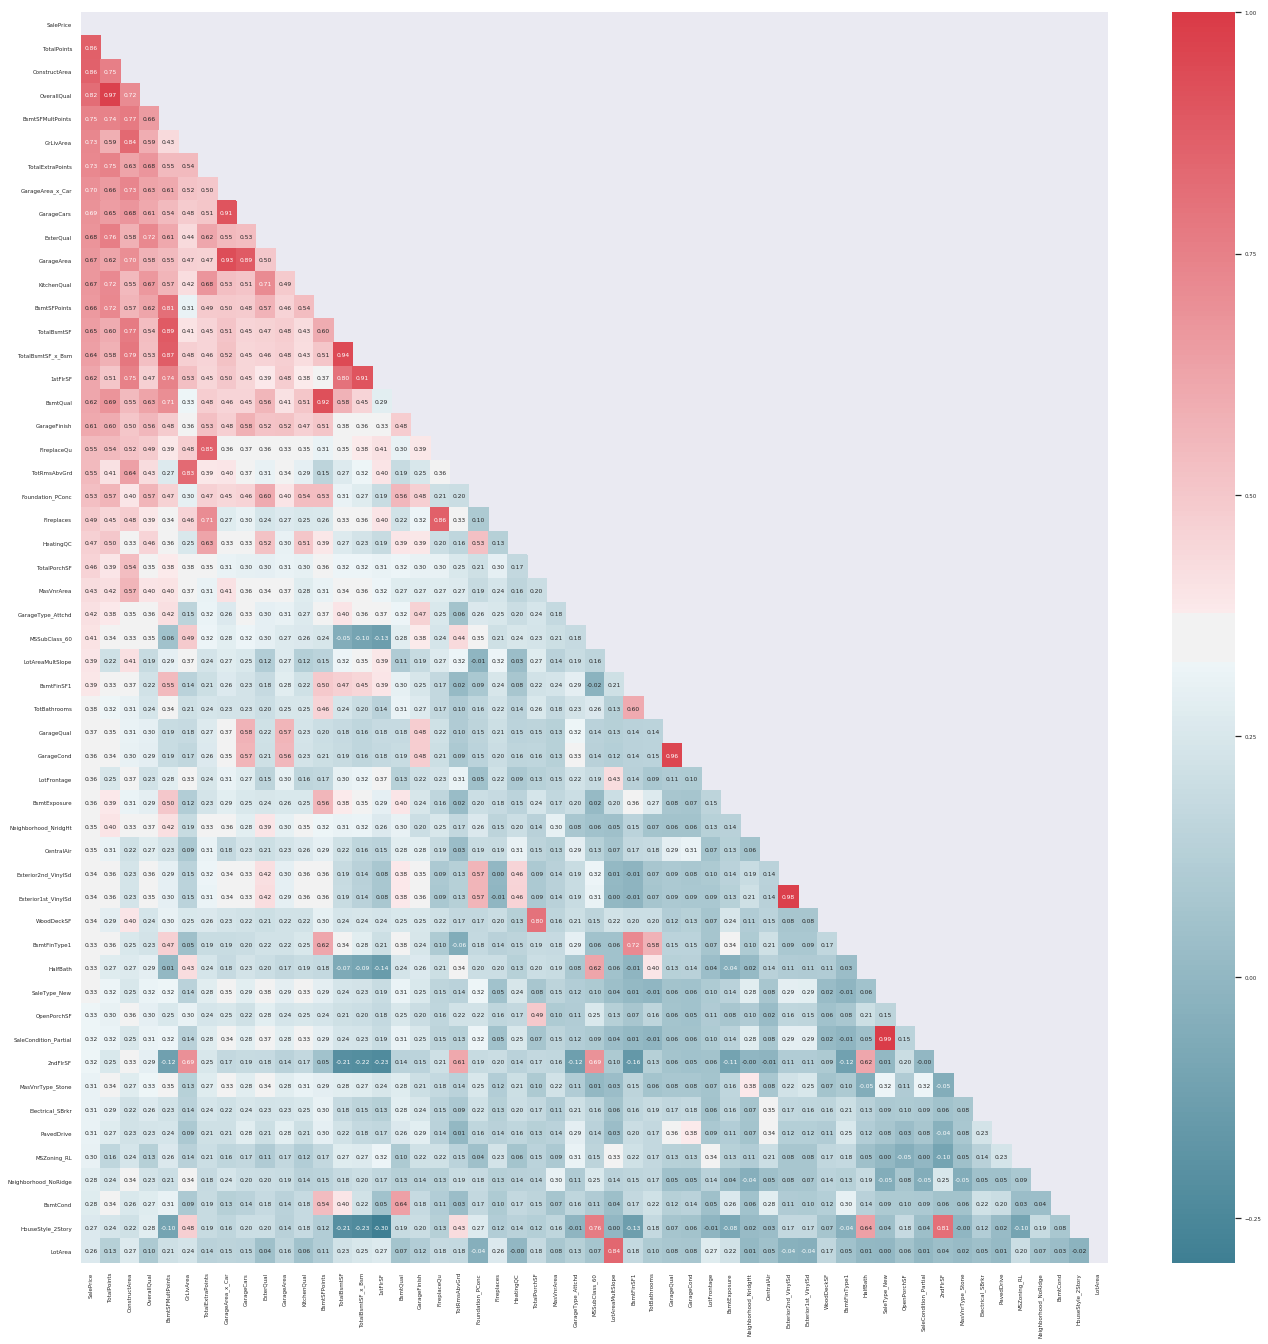

In [149]:
corr = all_data[all_data.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(23, 23))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()
del corr, dropSelf, top_corr

In [0]:
all_data.drop(['FireplaceQu', 'BsmtSFPoints', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'OverallQual', 'GrLivArea', 
               'TotalBsmtSF_x_Bsm', '1stFlrSF', 'PoolArea', 'LotArea', 'SaleCondition_Partial', 'Exterior1st_VinylSd',
               'GarageCond', 'HouseStyle_2Story', 'BsmtSFMultPoints', 'ScreenPorch', 'LowQualFinSF', 'BsmtFinSF2',
               'TSsnPorch'], axis=1, inplace=True) 

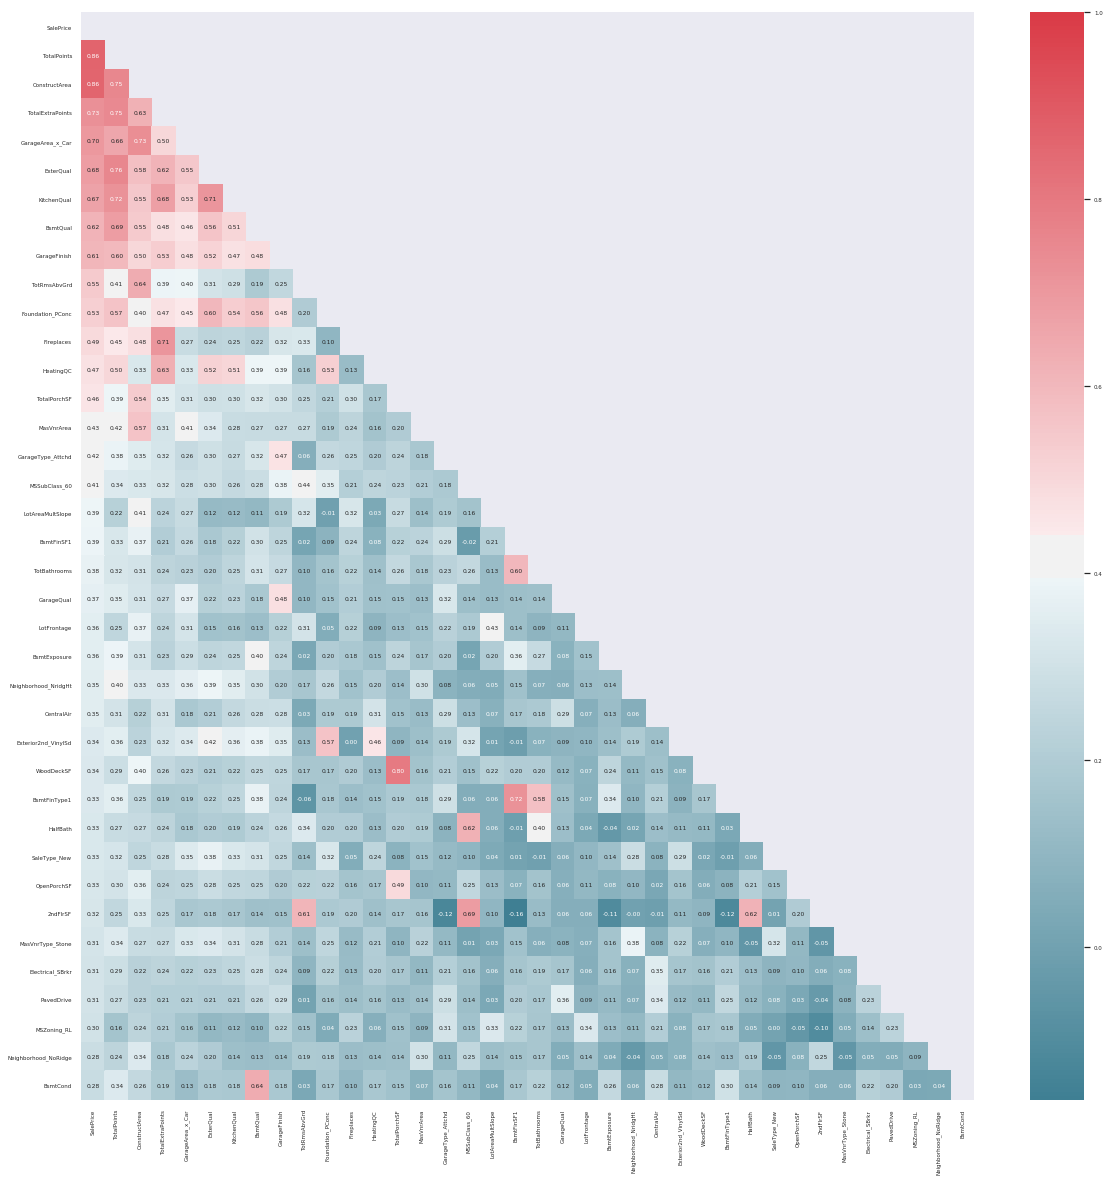

In [151]:
corr = all_data[all_data.SalePrice>1].corr()
top_corr_cols = corr[abs((corr.SalePrice)>=.26)].SalePrice.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
plt.figure(figsize=(20, 20))
sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
sns.set(font_scale=0.5)
plt.show()
del corr, dropSelf, top_corr

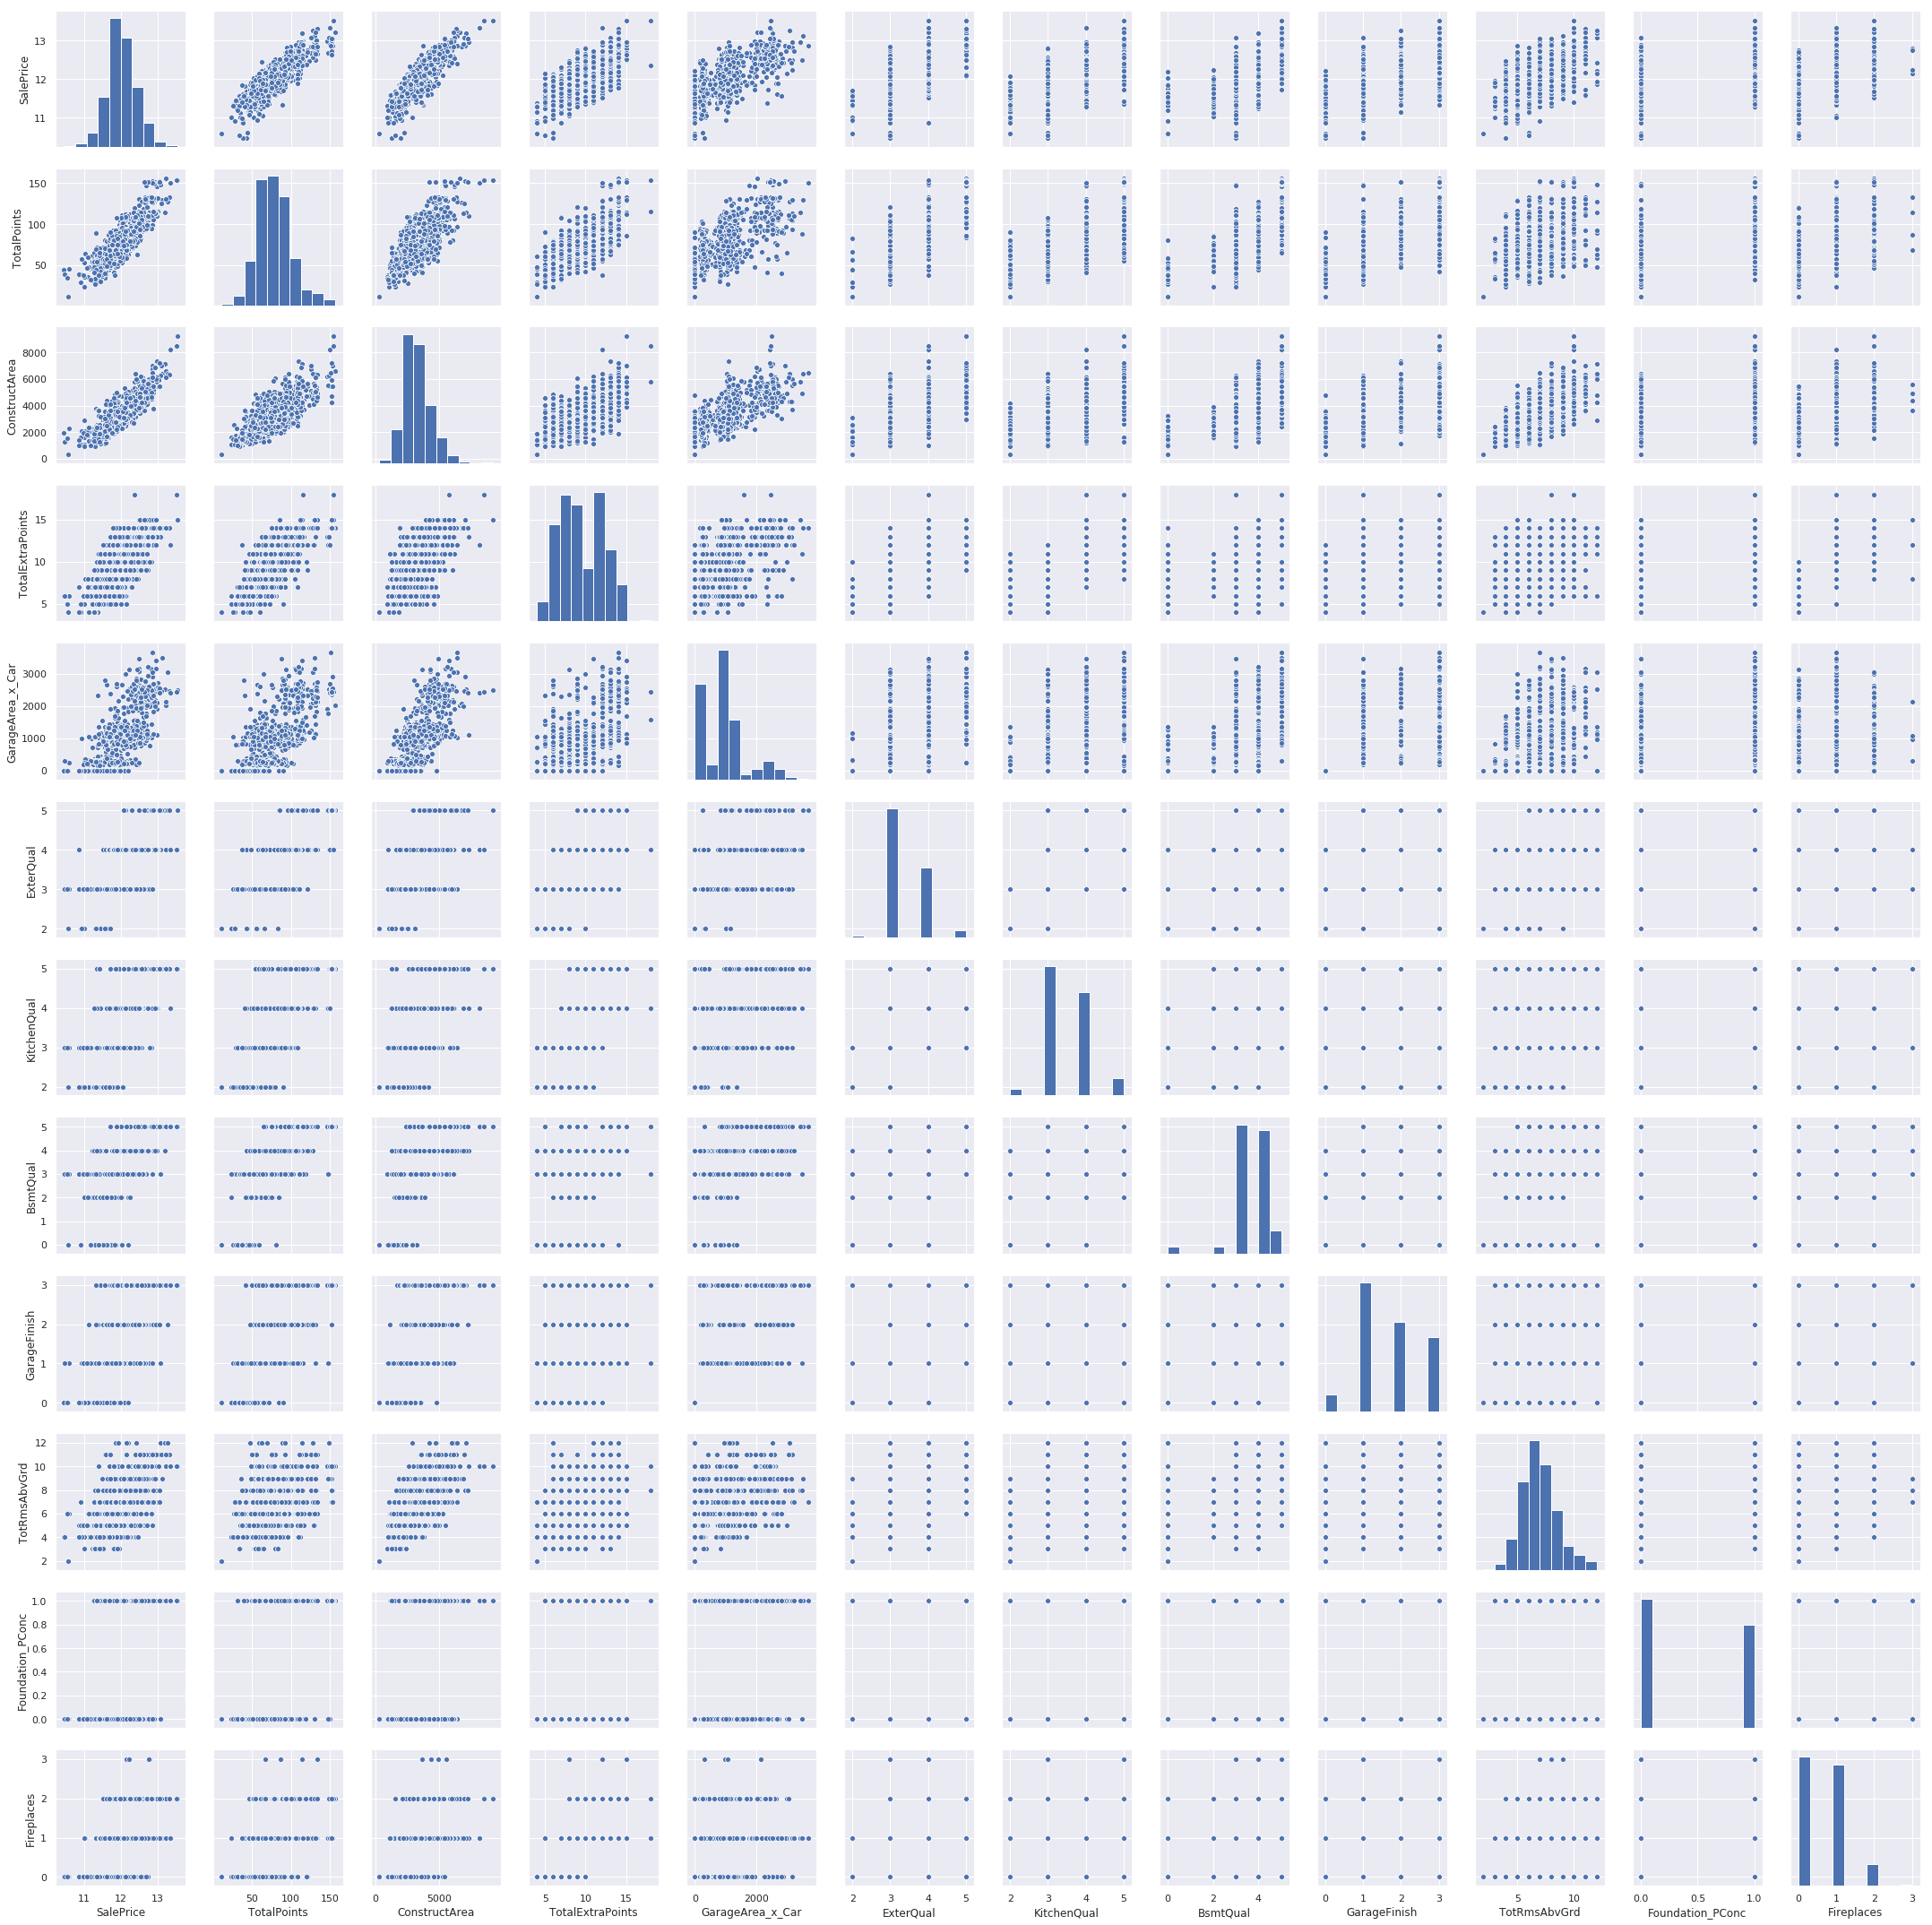

In [152]:
sns.set(font_scale=1.0)
g = sns.pairplot(all_data.loc[all_data.SalePrice>0, top_corr_cols[:12]])

In [153]:
all_data.rename(columns={'2ndFlrSF':'SndFlrSF'}, inplace=True)

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['SalePrice'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

# Remove the higest correlations and run a multiple regression
cols = all_data.columns
cols = cols.drop(['SalePrice'])
vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])

VIF Factor               features
0         1.000              Intercept
41        1.267                 YrSold
39        1.460                  Fence
10        1.522              ExterCond
29        1.553             Functional
2         1.563                 Street
120       1.572        Condition2_PosN
37        1.669          EnclosedPorch
3         1.734               LotShape
119       1.738        Condition2_PosA
34        1.837             PavedDrive
143       1.918    Exterior1st_AsphShn
13        2.259           BsmtExposure
225       2.281                  Remod
226       2.336                  IsNew
1         2.349            LotFrontage
4         2.382              LandSlope
144       2.569    Exterior1st_BrkComm
5         2.574            OverallCond
16        2.583           BsmtFinType2
48        2.595       LotAreaMultSlope
19        2.609             CentralAir
116       2.695      Condition2_Artery
129       2.758       HouseStyle_25Unf
36        2.975            OpenPorchSF
221       3.081  SaleCondition_AdjLand
32        3.181           GarageFinish
182       3.230           Heating_Wall
14        3.258           BsmtFinType1
25        3.426           BedroomAbvGr
..          ...                    ...
65          inf          MSZoning_Call
64          inf          MSSubClass_90
133         inf        RoofStyle_Gable
63          inf          MSSubClass_85
61          inf          MSSubClass_75
60          inf          MSSubClass_70
59          inf          MSSubClass_60
58          inf          MSSubClass_50
146         inf     Exterior1st_CBlock
74          inf        LandContour_HLS
62          inf          MSSubClass_80
110         inf        Condition1_PosA
132         inf         RoofStyle_Flat
67          inf            MSZoning_RH
112         inf        Condition1_RRAe
114         inf        Condition1_RRNe
115         inf        Condition1_RRNn
73          inf        LandContour_Bnk
72          inf             Alley_Pave
71          inf               Alley_NA
66          inf            MSZoning_FV
70          inf             Alley_Grvl
121         inf          BldgType_1Fam
122         inf        BldgType_2fmCon
123         inf        BldgType_Duplex
124         inf         BldgType_Twnhs
125         inf        BldgType_TwnhsE
68          inf            MSZoning_RL
69          inf            MSZoning_RM
113         inf        Condition1_RRAn

[227 rows x 2 columns]

In [154]:
# Remove one feature with VIF on Inf from the same category and run a multiple regression
cols = cols.drop(['Condition1_PosN', 'Neighborhood_NWAmes', 'Exterior1st_CBlock', 'BldgType_1Fam', 'RoofStyle_Flat',
                  'MSZoning_Call', 'Alley_Grvl', 'LandContour_Bnk', 'LotConfig_Corner', 'GarageType_2Types', 'MSSubClass_45',
                  'MasVnrType_BrkCmn', 'Foundation_CBlock', 'MiscFeature_Gar2', 'SaleType_COD', 'Exterior2nd_CBlock'])

vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])

VIF Factor              features
0         1.000             Intercept
165       1.187       Foundation_Wood
197       1.194          SaleType_Con
202       1.212          SaleType_Oth
75        1.218         LotConfig_FR3
107       1.236       Condition1_RRNe
196       1.255          SaleType_CWD
41        1.266                YrSold
78        1.272  Neighborhood_Blueste
199       1.276        SaleType_ConLI
200       1.357        SaleType_ConLw
74        1.401         LotConfig_FR2
164       1.409      Foundation_Stone
100       1.450  Neighborhood_Veenker
39        1.459                 Fence
10        1.522             ExterCond
29        1.553            Functional
2         1.563                Street
198       1.571        SaleType_ConLD
113       1.572       Condition2_PosN
37        1.665         EnclosedPorch
104       1.677       Condition1_PosA
108       1.705       Condition1_RRNn
3         1.733              LotShape
112       1.737       Condition2_PosA
76        1.775      LotConfig_Inside
34        1.836            PavedDrive
73        1.870     LotConfig_CulDSac
134       1.918   Exterior1st_AsphShn
105       2.050       Condition1_RRAe
..          ...                   ...
126     113.236         RoofStyle_Hip
149     118.487   Exterior2nd_HdBoard
124     121.815       RoofStyle_Gable
57      130.963         MSSubClass_50
151     138.313   Exterior2nd_MetalSd
173     143.021      Electrical_SBrkr
155     185.525   Exterior2nd_VinylSd
58      236.314         MSSubClass_60
54      319.760         MSSubClass_20
183     323.008      MiscFeature_Shed
180     422.664        MiscFeature_NA
49          inf          TotBathrooms
21          inf          BsmtFullBath
22          inf          BsmtHalfBath
23          inf              FullBath
63          inf         MSSubClass_90
115         inf       BldgType_Duplex
187         inf             MoSold_12
184         inf              MoSold_1
186         inf             MoSold_11
24          inf              HalfBath
195         inf              MoSold_9
194         inf              MoSold_8
193         inf              MoSold_7
192         inf              MoSold_6
191         inf              MoSold_5
190         inf              MoSold_4
189         inf              MoSold_3
185         inf             MoSold_10
188         inf              MoSold_2

[211 rows x 2 columns]

In [155]:
# Remove one feature with highest VIF from the same category and run a multiple regression
cols = cols.drop(['PoolQC', 'BldgType_TwnhsE', 'BsmtFinSF1', 'BsmtUnfSF', 'Electrical_SBrkr', 'Exterior1st_MetalSd',
                  'Exterior2nd_VinylSd', 'GarageQual', 'GarageType_Attchd', 'HouseStyle_1Story', 'MasVnrType_None',
                  'MiscFeature_NA', 'MSZoning_RL', 'RoofStyle_Gable', 'SaleCondition_Normal', 'MoSold_10',
                  'SaleType_New', 'SndFlrSF', 'TotalPorchSF', 'WoodDeckSF', 'BldgType_Duplex', 'MSSubClass_90'])
              
vif = VRF('SalePrice', all_data.loc[all_data.SalePrice>0, cols], all_data.SalePrice[all_data.SalePrice>0])

VIF Factor               features
0         1.000              Intercept
186       1.134   SaleCondition_Family
177       1.150           SaleType_Con
181       1.158           SaleType_Oth
179       1.164         SaleType_ConLI
149       1.167        Foundation_Wood
176       1.174           SaleType_CWD
66        1.209          LotConfig_FR3
35        1.228                 YrSold
98        1.228        Condition1_RRNe
180       1.236         SaleType_ConLw
69        1.254   Neighborhood_Blueste
57        1.266            MSZoning_RH
164       1.299       MiscFeature_Shed
183       1.301  SaleCondition_Abnorml
178       1.333         SaleType_ConLD
148       1.349       Foundation_Stone
112       1.353      RoofStyle_Gambrel
65        1.375          LotConfig_FR2
15        1.378           BsmtFinType2
163       1.383       MiscFeature_Pool
34        1.389                MiscVal
33        1.419                  Fence
154       1.421       Electrical_FuseA
159       1.422     GarageType_CarPort
113       1.427          RoofStyle_Hip
91        1.437   Neighborhood_Veenker
2         1.449                 Street
26        1.452             Functional
158       1.477     GarageType_BuiltIn
..          ...                    ...
44        9.351         MSSubClass_160
138       9.366    Exterior2nd_Plywood
43        9.720         MSSubClass_120
116      10.371       RoofMatl_CompShg
39       10.479          ConstructArea
128      11.456     Exterior1st_WdSdng
36       11.722       TotalExtraPoints
141      11.919     Exterior2nd_WdSdng
94       12.130        Condition1_Norm
40       12.227          Garage_Newest
150      12.870           Heating_GasA
135      13.068    Exterior2nd_HdBoard
107      13.089       HouseStyle_15Fin
125      13.279    Exterior1st_HdBoard
54       13.674          MSSubClass_80
111      13.963        HouseStyle_SLvl
161      15.408          GarageType_NA
6        16.182              YearBuilt
50       22.780          MSSubClass_50
51       23.506          MSSubClass_60
124      25.283    Exterior1st_CemntBd
134      25.316    Exterior2nd_CmentBd
47       29.577          MSSubClass_20
105      33.719        BldgType_2fmCon
46       34.739         MSSubClass_190
42          inf           TotBathrooms
18          inf           BsmtFullBath
19          inf           BsmtHalfBath
21          inf               HalfBath
20          inf               FullBath

[189 rows x 2 columns]

In [156]:
# Reserve a copy for future analysis:
df_copy = all_data[all_data.SalePrice>0].copy()

all_data.CentralAir = all_data.CentralAir.astype('uint8')
all_data.Garage_Newest = all_data.Garage_Newest.astype('uint8')
all_data.EnclosedPorch = all_data.EnclosedPorch.astype('uint8')
all_data.FullBath = all_data.FullBath.astype('uint8')
all_data.HalfBath = all_data.HalfBath.astype('uint8')
all_data.BsmtFullBath = all_data.BsmtFullBath.astype('uint8')
all_data.BsmtHalfBath = all_data.BsmtHalfBath.astype('uint8')
all_data.Remod = all_data.Remod.astype('uint8')
all_data.IsNew = all_data.IsNew.astype('uint8') 
all_data.Street = all_data.Street.astype('uint8') # orinal
all_data.PavedDrive = all_data.PavedDrive.astype('uint8') # ordinal
all_data.Functional = all_data.Functional.astype('uint8') # ordinal
all_data.LandSlope = all_data.LandSlope.astype('uint8') # ordinal

'''
for feat in cols:
    if all_data[feat].dtype=='uint8':
        all_data[feat] = all_data[feat].astype('category')
'''

"\nfor feat in cols:\n    if all_data[feat].dtype=='uint8':\n        all_data[feat] = all_data[feat].astype('category')\n"

In [157]:
numeric_features = list(all_data.loc[:, cols].dtypes[(all_data.dtypes != "category") & (all_data.dtypes !='uint8')].index)

'''
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
'''
skewed_features = all_data[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    all_data[feat], l_opt[feat] = boxcox((all_data[feat]+1))

skewed_features2 = all_data[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 18 higest skewed numerical features to box cox transform


Skew  New Skew
MiscVal          21.757     4.774
KitchenAbvGr      4.331    -2.060
LotAreaMultSlope  3.495     0.137
BsmtFinType2      3.149    -0.434
MasVnrArea        2.623     0.458
OpenPorchSF       2.529    -0.025
Fence             1.750     1.531
GarageArea_x_Car  1.353    -0.135
ExterCond         1.314    -0.036
LotFrontage       1.232     0.171
BsmtExposure      1.119    -0.029
ConstructArea     1.083     0.022
ExterQual         0.790    -0.023
Fireplaces        0.726     0.113
TotRmsAbvGrd      0.717    -0.000
LotShape         -1.248    -0.598
BsmtQual         -1.265     0.046
BsmtCond         -3.627     0.656

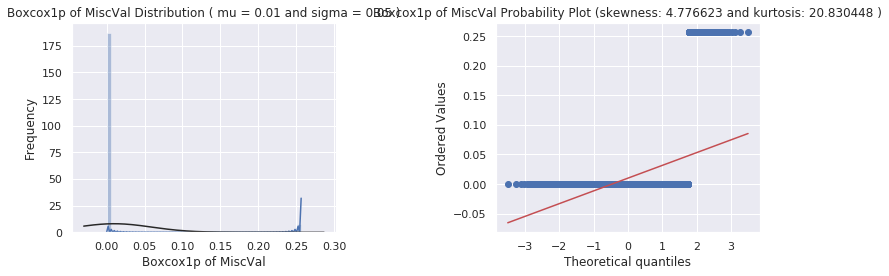

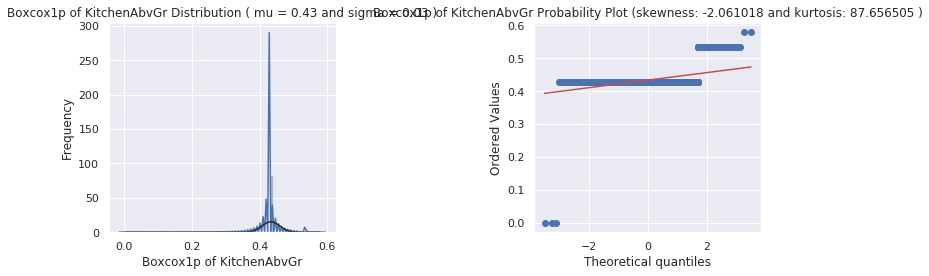

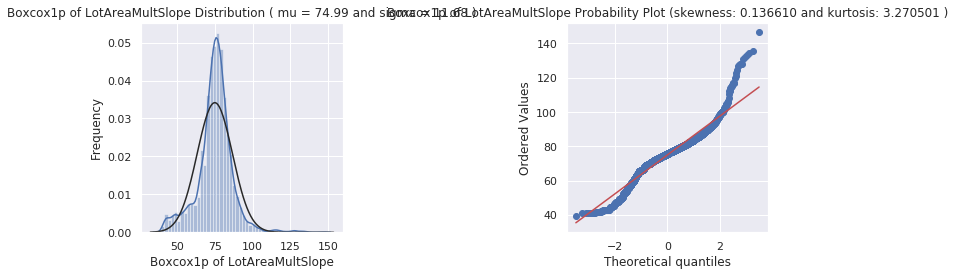

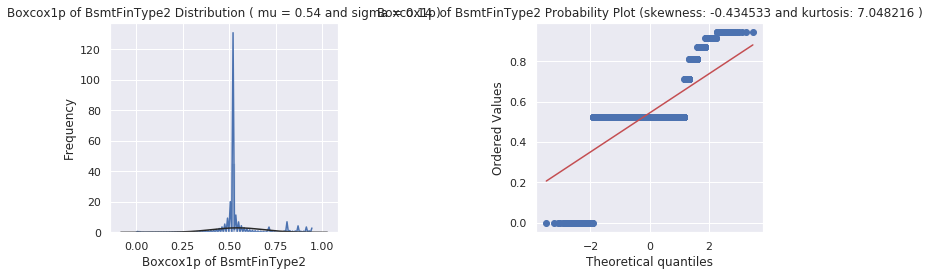

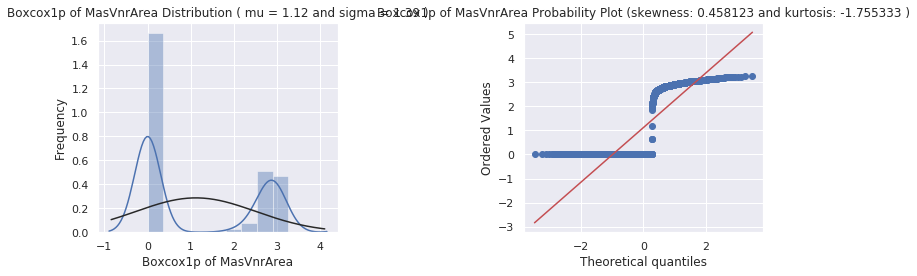

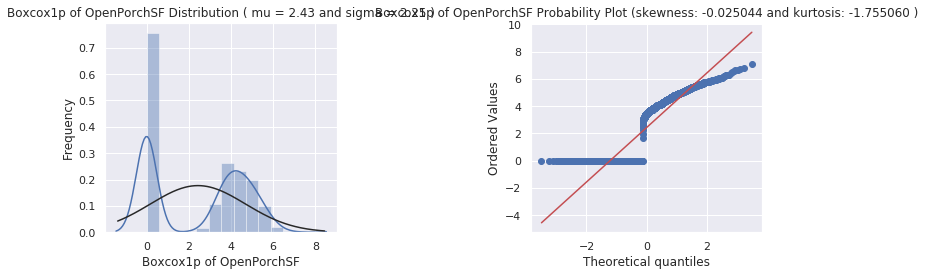

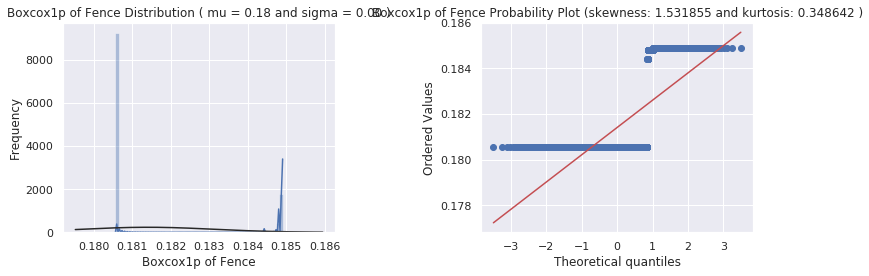

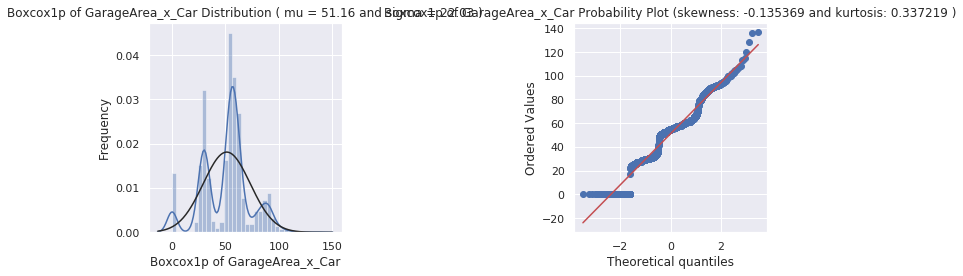

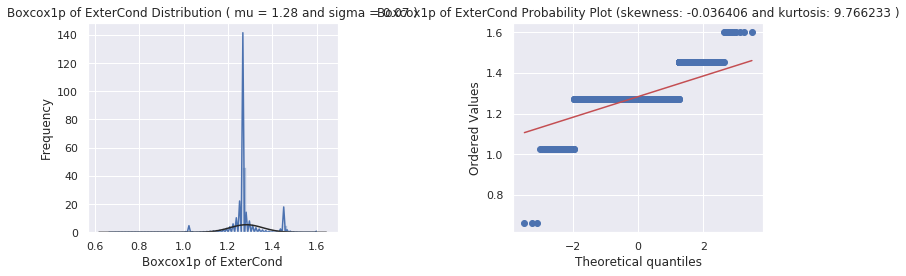

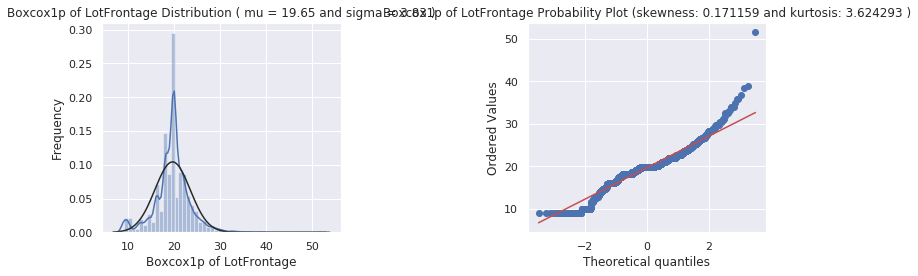

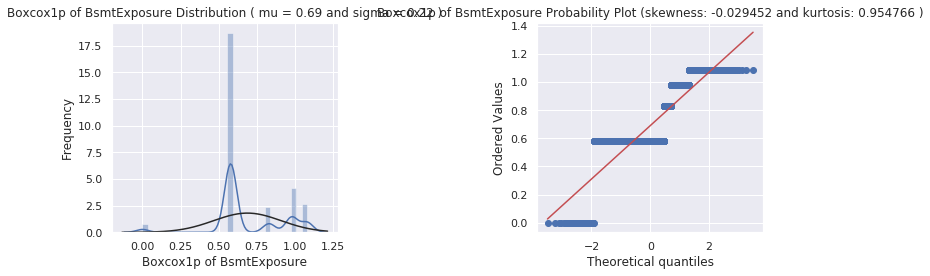

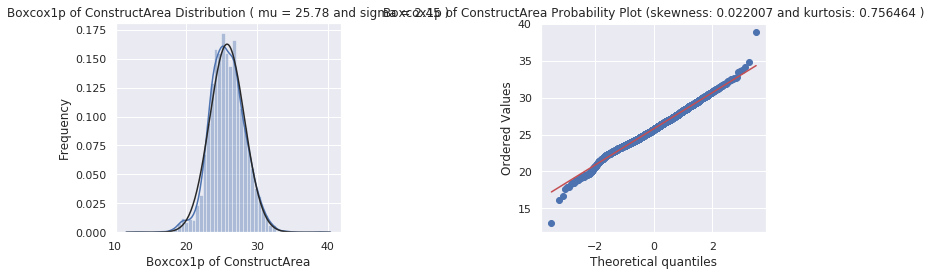

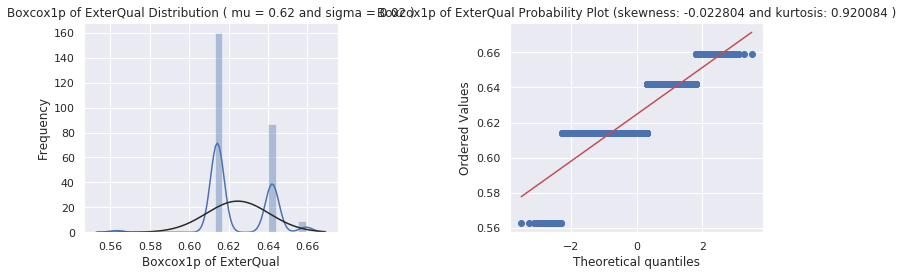

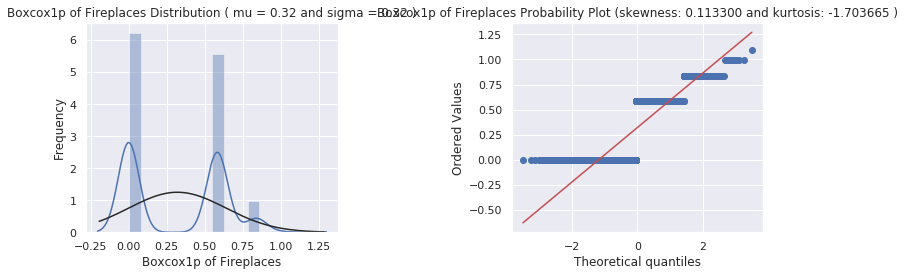

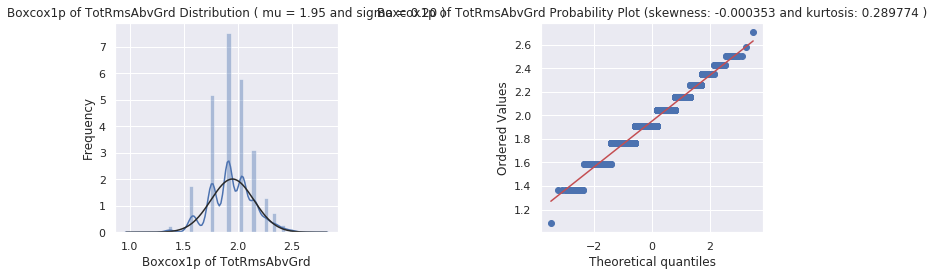

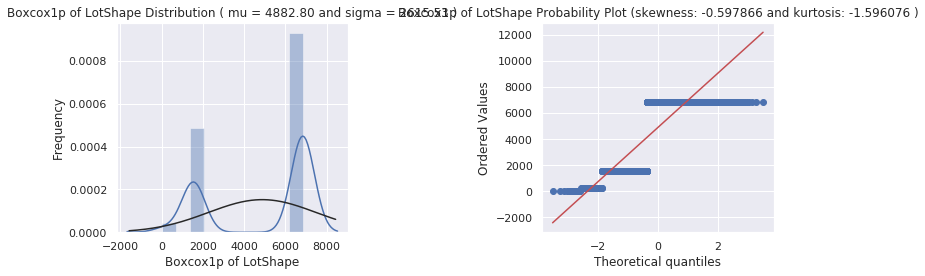

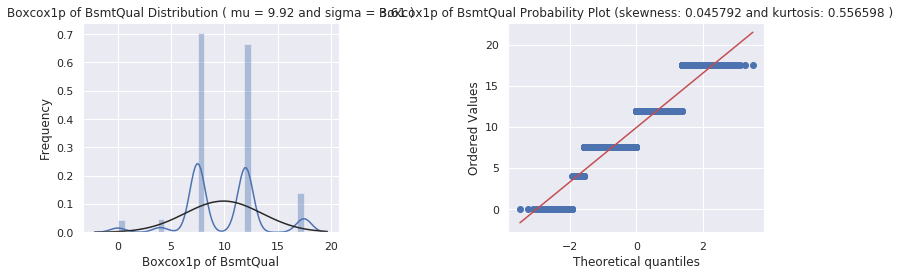

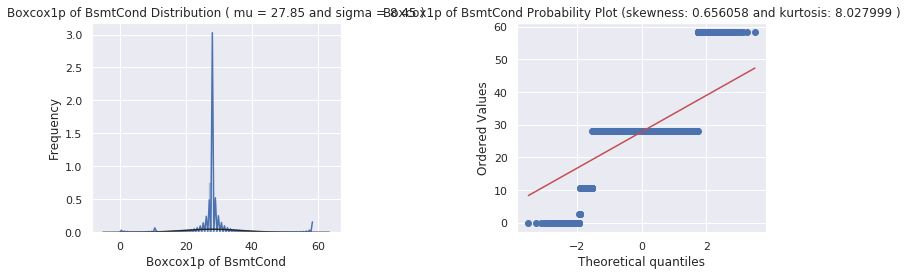

In [158]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.\
                   format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()
    
for feat in skewness.index:
    QQ_plot(all_data[feat], ('Boxcox1p of {}'.format(feat)))

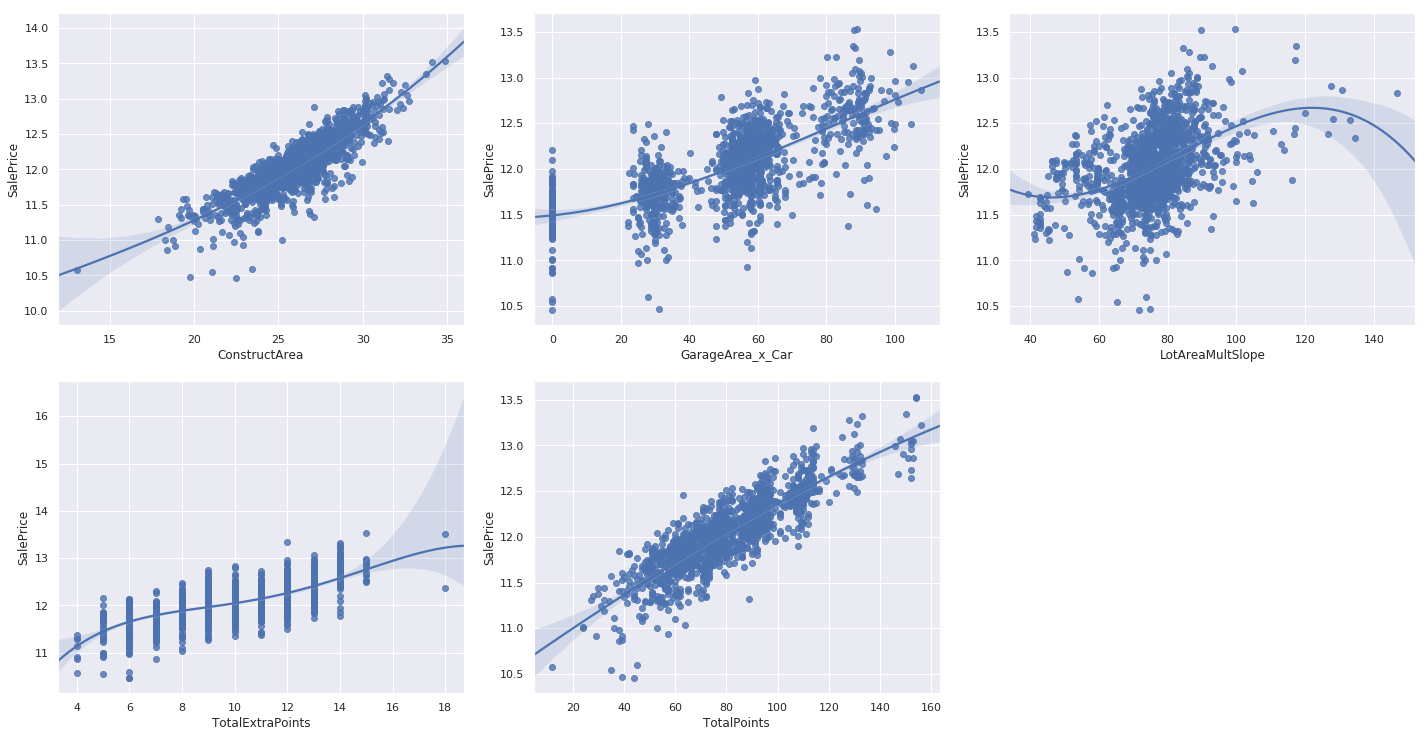

In [159]:
fig = plt.figure(figsize=(20,15)) 
ax = fig.add_subplot(331); g = sns.regplot(y='SalePrice', x='ConstructArea', data = all_data[all_data.SalePrice>0], order=3) 
ax = fig.add_subplot(332); g = sns.regplot(y='SalePrice', x='GarageArea_x_Car', data = all_data[all_data.SalePrice>0], order=3)
ax = fig.add_subplot(333); g = sns.regplot(y='SalePrice', x='LotAreaMultSlope', data = all_data[all_data.SalePrice>0], order=3) 
ax = fig.add_subplot(334); g = sns.regplot(y='SalePrice', x='TotalExtraPoints', data = all_data[all_data.SalePrice>0], order=4) 
ax = fig.add_subplot(335); g = sns.regplot(y='SalePrice', x='TotalPoints', data = all_data[all_data.SalePrice>0], order=3) 

plt.tight_layout() 

In [0]:
def poly(X, y, feat=''):

    # Initializatin of regression models
    regr = LinearRegression()
    regr = regr.fit(X, y)
    y_lin_fit = regr.predict(X)
    linear_r2 = r2_score(y, regr.predict(X))

    # create polynomial features
    quadratic = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
    cubic = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
    fourth = PolynomialFeatures(degree=4, interaction_only=False, include_bias=False)
    fifth = PolynomialFeatures(degree=5, interaction_only=False, include_bias=False)
    X_quad = quadratic.fit_transform(X)
    X_cubic = cubic.fit_transform(X)
    X_fourth = fourth.fit_transform(X)
    X_fifth = fifth.fit_transform(X)

    # quadratic fit
    regr = regr.fit(X_quad, y)
    y_quad_fit = regr.predict(quadratic.fit_transform(X))
    quadratic_r2 = r2_score(y, y_quad_fit)

    # cubic fit
    regr = regr.fit(X_cubic, y)
    y_cubic_fit = regr.predict(cubic.fit_transform(X))
    cubic_r2 = r2_score(y, y_cubic_fit)

    # Fourth fit
    regr = regr.fit(X_fourth, y)
    y_fourth_fit = regr.predict(fourth.fit_transform(X))
    four_r2 = r2_score(y, y_fourth_fit)

    # Fifth fit
    regr = regr.fit(X_fifth, y)
    y_fifth_fit = regr.predict(fifth.fit_transform(X))
    five_r2 = r2_score(y, y_fifth_fit)
    
    if len(feat)>0:
        fig = plt.figure(figsize=(20,5))
        # Plot lowest Polynomials
        fig1 = fig.add_subplot(121)
        plt.scatter(X[feat], y, label='training points', color='lightgray')
        plt.plot(X[feat], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, color='blue', lw=0.5, linestyle=':')
        plt.plot(X[feat], y_quad_fit, label='quadratic (d=2), $R^2=%.3f$' % quadratic_r2, color='red', lw=0.5, linestyle='-')
        plt.plot(X[feat], y_cubic_fit, label='cubic (d=3), $R^2=%.3f$' % cubic_r2,  color='green', lw=0.5, linestyle='--')

        plt.xlabel(feat)
        plt.ylabel('Sale Price')
        plt.legend(loc='upper left')

        # Plot higest Polynomials
        fig2 = fig.add_subplot(122)
        plt.scatter(X[feat], y, label='training points', color='lightgray')
        plt.plot(X[feat], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, color='blue', lw=2, linestyle=':')
        plt.plot(X[feat], y_fifth_fit, label='Fifth (d=5), $R^2=%.3f$' % five_r2, color='yellow', lw=2, linestyle='-')
        plt.plot(X[feat], y_fifth_fit, label='Fourth (d=4), $R^2=%.3f$' % four_r2, color='red', lw=2, linestyle=':')

        plt.xlabel(feat)
        plt.ylabel('Sale Price')
        plt.legend(loc='upper left')
    else:
        # Plot initialisation
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], y, s=40)

        # make lines of the regressors:
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_lin_fit, label='linear (d=1), $R^2=%.3f$' % linear_r2, 
                 color='blue', lw=2, linestyle=':')
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_quad_fit, label='quadratic (d=2), $R^2=%.3f$' % quadratic_r2, 
                 color='red', lw=0.5, linestyle='-')
        plt.plot(X.iloc[:, 0], X.iloc[:, 1], y_cubic_fit, label='cubic (d=3), $R^2=%.3f$' % cubic_r2, 
                 color='green', lw=0.5, linestyle='--')
        # label the axes
        ax.set_xlabel(X.columns[0])
        ax.set_ylabel(X.columns[1])
        ax.set_zlabel('Sales Price')
        ax.set_title("Poly up to 3 degree")
        plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

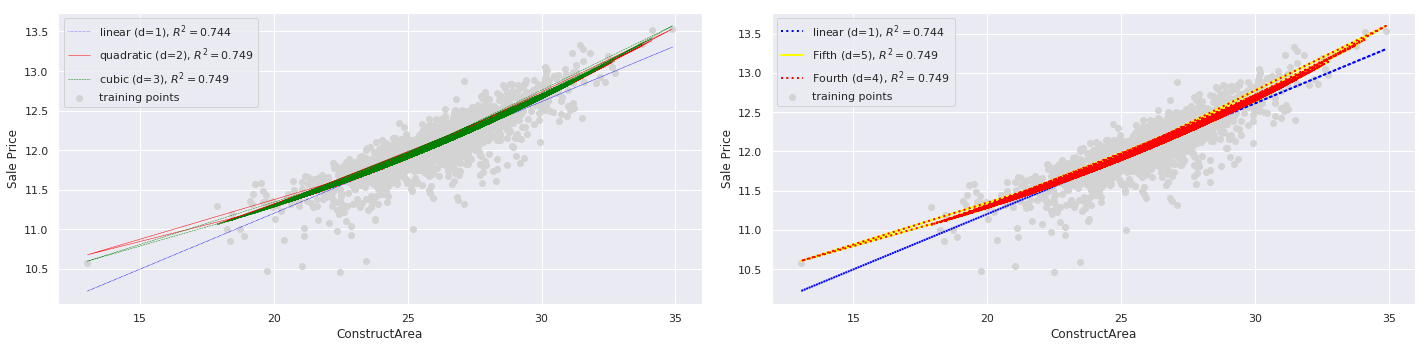

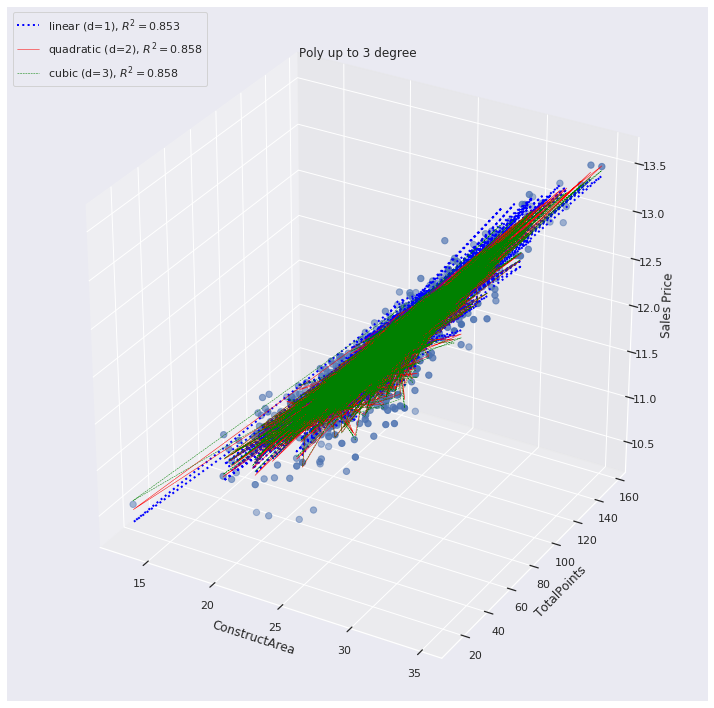

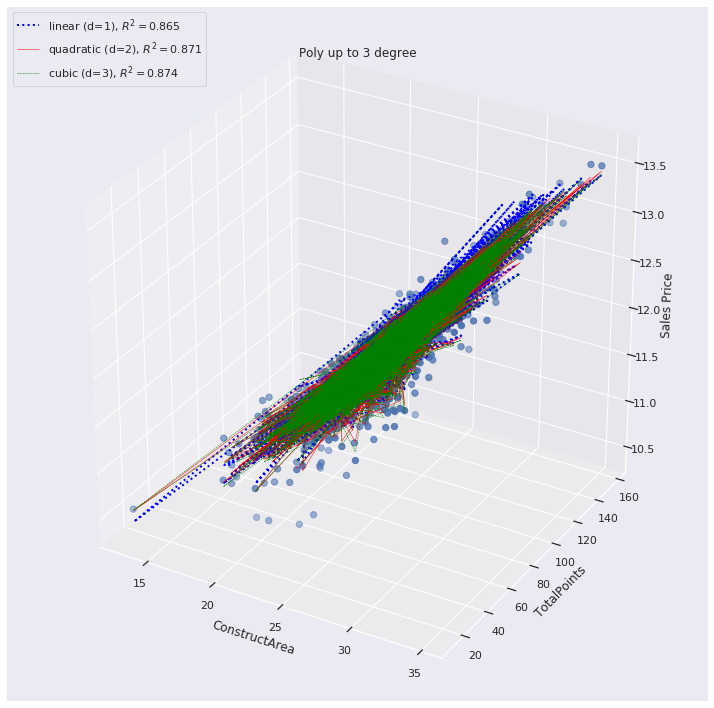

In [161]:
y = all_data.SalePrice[all_data.SalePrice>0]
X = all_data.loc[all_data.SalePrice>0, ['ConstructArea']] 
poly(X, y, 'ConstructArea')

X = all_data.loc[all_data.SalePrice>0, ['ConstructArea', 'TotalPoints']] 
poly(X, y)

X = all_data.loc[all_data.SalePrice>0, ['ConstructArea', 'TotalPoints', 'LotAreaMultSlope',  'GarageArea_x_Car']] 
poly(X, y)

In [162]:
poly_cols = ['ConstructArea', 'TotalPoints', 'LotAreaMultSlope',  'GarageArea_x_Car']

pf = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
res = pf.fit_transform(all_data.loc[:, poly_cols])

target_feature_names = [feat.replace(' ','_') for feat in pf.get_feature_names(poly_cols)]
output_df = pd.DataFrame(res, columns = target_feature_names,  index=all_data.index).iloc[:, len(poly_cols):]
print('Polynomial Features included:', output_df.shape[1])
display(output_df.head())
all_data = pd.concat([all_data, output_df], axis=1)
print('Total Features after Polynomial Features included:', all_data.shape[1])
colsP = output_df.columns

del output_df, target_feature_names, res, pf

Polynomial Features included: 30


ConstructArea^2  ...  GarageArea_x_Car^3
0          691.343  ...          206682.712
1          680.815  ...          158852.520
2          708.453  ...          241545.857
3          665.075  ...          480194.601
4          845.991  ...          711165.782

[5 rows x 30 columns]

Total Features after Polynomial Features included: 257


In [0]:
y_train = (all_data.SalePrice[all_data.SalePrice>0].reset_index(drop=True, inplace=False))

# Data with Polynomials
train = all_data.loc[(all_data.SalePrice>0), cols].reset_index(drop=True, inplace=False)
test = all_data.loc[(all_data.SalePrice==0), cols].reset_index(drop=True, inplace=False)

In [0]:
scale = RobustScaler()
# Data without Polynomials
df = pd.DataFrame(scale.fit_transform(train[cols]), columns= cols)

In [165]:
ln_model=sm.OLS(y_train,df)
result=ln_model.fit()
print(result.summary2())

                     Results: Ordinary least squares
Model:                 OLS                Adj. R-squared:       0.929     
Dependent Variable:    SalePrice          AIC:                  -2211.6771
Date:                  2019-07-29 15:13   BIC:                  -1219.0356
No. Observations:      1451               Log-Likelihood:       1293.8    
Df Model:              187                F-statistic:          102.5     
Df Residuals:          1263               Prob (F-statistic):   0.00      
R-squared:             0.938              Scale:                0.011305  
--------------------------------------------------------------------------
                       Coef.   Std.Err.     t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------
LotFrontage             0.0088   0.0042    2.1079 0.0352   0.0006   0.0171
Street                  0.1510   0.0572    2.6417 0.0084   0.0389   0.2632
LotShape                0.0050   0.0073    0.69

In [167]:
pv_cols = cols.values

def backwardElimination(x, Y, sl, columns):
    ini = len(columns)
    numVars = x.shape[1]
    for i in range(0, numVars):
        regressor = sm.OLS(Y, x).fit()
        maxVar = max(regressor.pvalues) #.astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor.pvalues[j].astype(float) == maxVar):
                    columns = np.delete(columns, j)
                    x = x.loc[:, columns]
                    
    print('\nSelect {:d} features from {:d} by best p-values.'.format(len(columns), ini))
    print('The max p-value from the features selecte is {:.3f}.'.format(maxVar))
    print(regressor.summary())
    
    # odds ratios and 95% CI
    conf = np.exp(regressor.conf_int())
    conf['Odds Ratios'] = np.exp(regressor.params)
    conf.columns = ['2.5%', '97.5%', 'Odds Ratios']
    display(conf)
    
    return columns, regressor

SL = 0.051

pv_cols, LR = backwardElimination(df, y_train, SL, pv_cols)


Select 65 features from 188 by best p-values.
The max p-value from the features selecte is 0.045.
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     299.8
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:14:23   Log-Likelihood:                 1231.3
No. Observations:                1451   AIC:                            -2333.
Df Residuals:                    1386   BIC:                            -1989.
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------

2.5%           97.5%     Odds Ratios
LotFrontage                     1.001           1.015           1.008
Street                          1.020           1.245           1.127
LandSlope                       0.935           0.979           0.957
OverallCond                     1.028           1.043           1.035
YearBuilt                       0.900           0.941           0.920
YearRemodAdd                    0.960           0.992           0.975
MasVnrArea                      0.874           0.965           0.918
BsmtFinType1                    1.004           1.042           1.023
BsmtFinType2                    0.850           0.947           0.897
CentralAir                      1.029           1.090           1.059
BsmtFullBath          22667912446.866 25091290079.034 23848839944.334
BsmtHalfBath               147034.945      157851.568      152347.289
FullBath              22567270998.536 27080869858.652 24721272802.513
HalfBath                   153570.681      162419.401      157933.081
KitchenQual                     1.008           1.035           1.022
TotRmsAbvGrd                    1.008           1.033           1.021
Functional                      1.016           1.034           1.025
Fireplaces                      1.007           1.033           1.020
YrSold                          1.002           1.020           1.011
TotalPoints                     1.124           1.163           1.143
ConstructArea                   1.224           1.267           1.245
LotAreaMultSlope                1.032           1.048           1.040
TotBathrooms                    0.000           0.000           0.000
MSSubClass_20                   1.011           1.053           1.032
MSSubClass_50                   1.013           1.066           1.039
MSSubClass_60                   1.020           1.074           1.047
MSSubClass_70                   1.022           1.100           1.060
MSSubClass_75                   1.002           1.130           1.064
MSZoning_FV                     1.043           1.107           1.075
LotConfig_CulDSac               1.008           1.058           1.032
...                               ...             ...             ...
Neighborhood_MeadowV            0.877           0.981           0.928
Neighborhood_NPkVill            1.008           1.169           1.086
Neighborhood_NoRidge            1.049           1.130           1.089
Neighborhood_NridgHt            1.044           1.110           1.077
Neighborhood_SWISU              1.014           1.114           1.063
Neighborhood_StoneBr            1.117           1.226           1.170
Condition1_Artery               0.907           0.971           0.938
Condition1_Feedr                0.928           0.975           0.951
Condition1_RRAe                 0.826           0.940           0.881
HouseStyle_15Unf                1.003           1.133           1.066
HouseStyle_SFoyer               1.006           1.091           1.047
HouseStyle_SLvl                 1.020           1.088           1.053
Exterior1st_BrkComm             0.657           0.893           0.766
Exterior1st_BrkFace             1.033           1.104           1.068
Exterior1st_HdBoard             0.956           0.990           0.973
Exterior1st_WdSdng              0.924           0.988           0.955
Exterior2nd_WdSdng              1.002           1.071           1.036
MasVnrType_BrkFace              1.006           1.112           1.057
MasVnrType_Stone                1.040           1.158           1.098
Foundation_BrkTil               0.950           0.998           0.974
Foundation_PConc                1.006           1.044           1.025
Foundation_Slab                 1.060           1.183           1.120
Heating_GasW                    1.019           1.136           1.076
Heating_Grav                    0.825           0.980           0.899
GarageType_NA                   1.002           1.059           1.030
MoSold_11                       0.951      

Fvalue: 299.830011
MSE total on the train data: 0.1593


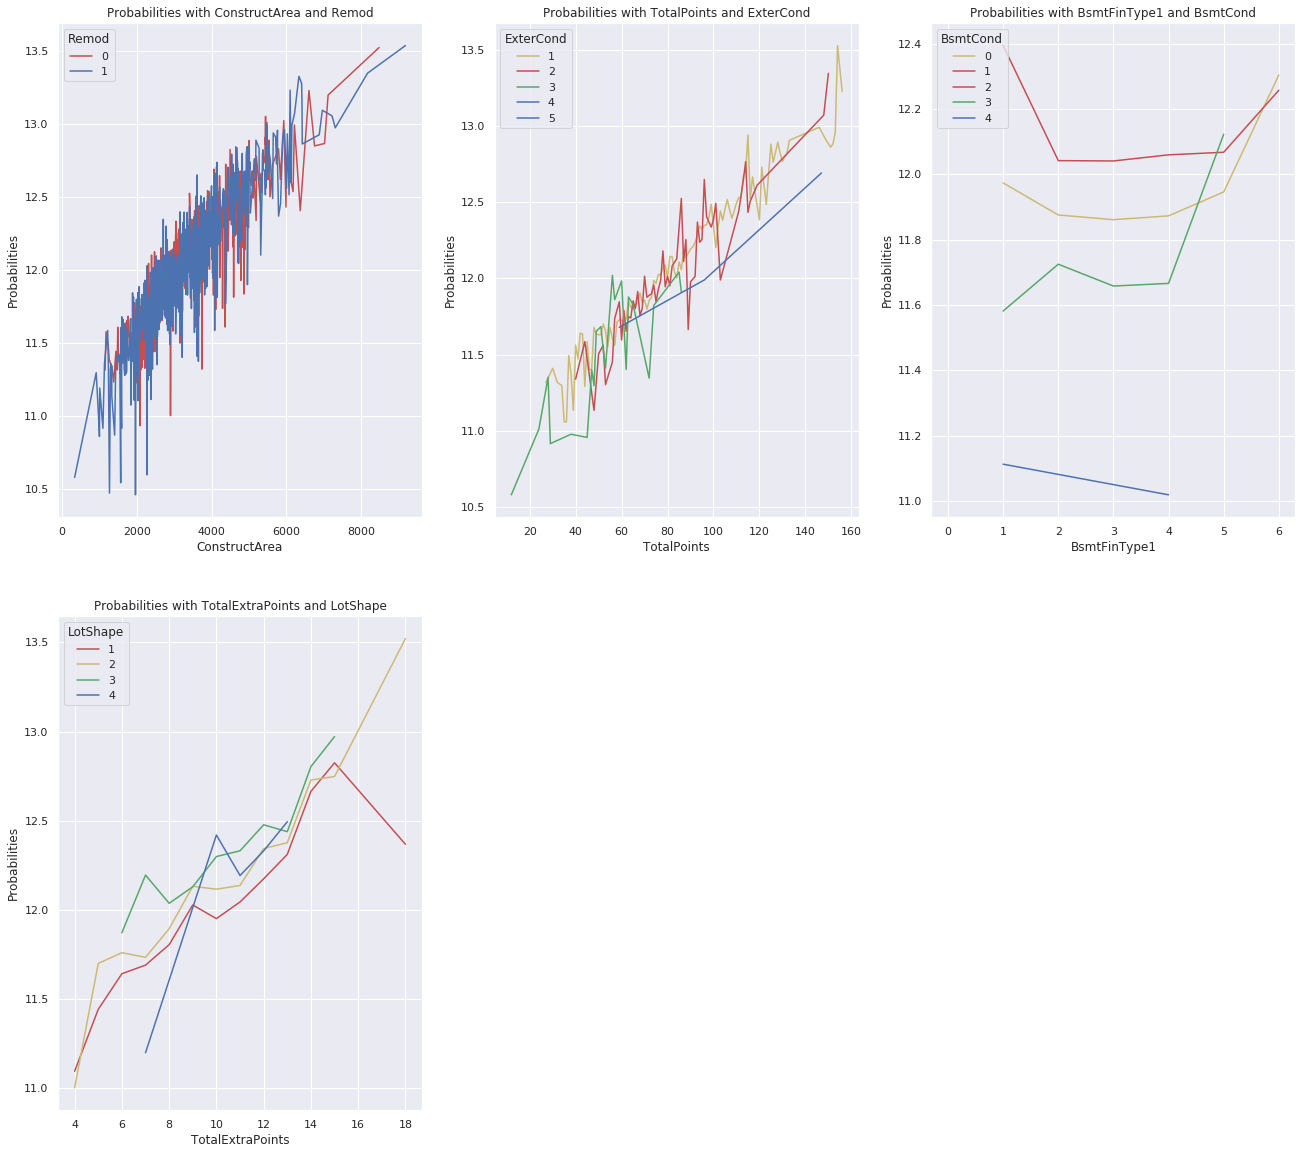

In [168]:
pred = LR.predict(df[pv_cols])

df_copy['proba'] = pred

y_pred = pred.apply(lambda x: 1 if x > 0.5 else 0)

print('Fvalue: {:.6f}'.format(LR.fvalue))
print('MSE total on the train data: {:.4f}'.format(LR.mse_total))
def plot_proba(continous, predict, discret, data):
    grouped = pd.pivot_table(data, values=[predict], index=[continous, discret], aggfunc=np.mean)
    colors = 'rbgyrbgy'
    for col in data[discret].unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        plt.plot(plt_data.index.get_level_values(0), plt_data[predict], color=colors[int(col)])
    plt.xlabel(continous)
    plt.ylabel("Probabilities")
    plt.legend(np.sort(data[discret].unique()), loc='upper left', title=discret)
    plt.title("Probabilities with " + continous + " and " + discret)

fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(241); plot_proba('ConstructArea', 'SalePrice', 'Remod', df_copy)
ax = fig.add_subplot(242); plot_proba('TotalPoints', 'SalePrice', 'ExterCond', df_copy)
ax = fig.add_subplot(243); plot_proba('BsmtFinType1', 'SalePrice', 'BsmtCond', df_copy)
ax = fig.add_subplot(245); plot_proba('TotalExtraPoints', 'SalePrice', 'LotShape', df_copy)

plt.show()
del df_copy

In [169]:
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)
rfecv = RFECV(estimator=ls, n_jobs = -1, step=1, scoring = 'neg_mean_squared_error' ,cv=5)
rfecv.fit(df, y_train)

select_features_rfecv = rfecv.get_support()
RFEcv = cols[select_features_rfecv]
print('{:d} Features Select by RFEcv:\n{:}'.format(rfecv.n_features_, RFEcv.values))

68 Features Select by RFEcv:
['LotFrontage' 'LandSlope' 'OverallCond' 'YearBuilt' 'YearRemodAdd'
 'MasVnrArea' 'BsmtQual' 'BsmtFinType1' 'BsmtFinType2' 'HeatingQC'
 'CentralAir' 'BsmtHalfBath' 'HalfBath' 'BedroomAbvGr' 'KitchenQual'
 'TotRmsAbvGrd' 'Functional' 'Fireplaces' 'GarageFinish' 'PavedDrive'
 'OpenPorchSF' 'EnclosedPorch' 'YrSold' 'TotalPoints' 'ConstructArea'
 'LotAreaMultSlope' 'TotBathrooms' 'MSSubClass_30' 'MSSubClass_60'
 'MSSubClass_70' 'MSZoning_FV' 'MSZoning_RM' 'Alley_Pave'
 'LotConfig_CulDSac' 'LotConfig_FR2' 'Neighborhood_BrkSide'
 'Neighborhood_ClearCr' 'Neighborhood_CollgCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_IDOTRR' 'Neighborhood_MeadowV'
 'Neighborhood_Mitchel' 'Neighborhood_NoRidge' 'Neighborhood_NridgHt'
 'Neighborhood_OldTown' 'Neighborhood_StoneBr' 'Condition1_Artery'
 'Condition1_Norm' 'Condition1_RRAe' 'Exterior1st_BrkFace'
 'Exterior1st_HdBoard' 'Exterior1st_WdSdng' 'Exterior2nd_MetalSd'
 'MasVnrType_Stone' 'Foundation_BrkTil' '

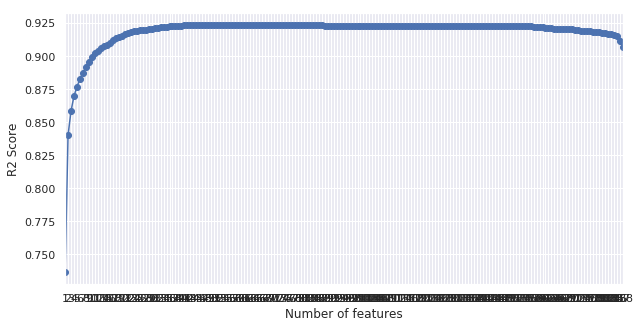

Best Score: 92.34%

Best score with:79.


Best score with 79 features:
['OverallCond', 'YearRemodAdd', 'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'CentralAir', 'BsmtFullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'GarageFinish', 'PavedDrive', 'YrSold', 'TotalPoints', 'ConstructArea', 'Garage_Newest', 'LotAreaMultSlope', 'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_60', 'MSSubClass_75', 'MSSubClass_85', 'Alley_Pave', 'LandContour_Lvl', 'LotConfig_CulDSac', 'LotConfig_FR2', 'Neighborhood_Blmngtn', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NoRidge', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Condition1_Norm', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition2_Norm', 'HouseStyle_15Unf', 'HouseStyle

In [170]:
from itertools import combinations
class SBS():
    def __init__(self, estimator, k_features, scoring=r2_score, test_size=0.25, random_state=101):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = list(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, list(p))
                scores.append(score)
                subsets.append(list(p))
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        return X.iloc[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train.iloc[:, indices], y_train)
        y_pred = self.estimator.predict(X_test.iloc[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

score = r2_score
ls = Lasso(alpha = 0.0005, max_iter = 161, selection = 'cyclic', tol = 0.002, random_state = 101)
sbs = SBS(ls, k_features=1, scoring= score)
sbs.fit(df, y_train)

k_feat = [len(k) for k in sbs.subsets_]
fig = plt.figure(figsize=(10,5))
plt.plot(k_feat, sbs.scores_, marker='o')
plt.xlim([1, len(sbs.subsets_)])
plt.xticks(np.arange(1, len(sbs.subsets_)+1))
plt.ylabel('R2 Score')
plt.xlabel('Number of features')
plt.grid(b=1)
plt.show()

print('Best Score: {:2.2%}\n'.format(max(sbs.scores_)))
print('Best score with:{0:2d}.\n'.\
      format(len(list(df.columns[sbs.subsets_[np.argmax(sbs.scores_)]]))))
SBS = list(df.columns[list(sbs.subsets_[max(np.arange(0, len(sbs.scores_))[(sbs.scores_==max(sbs.scores_))])])])
print('\nBest score with {0:2d} features:\n{1:}'.format(len(SBS), SBS))

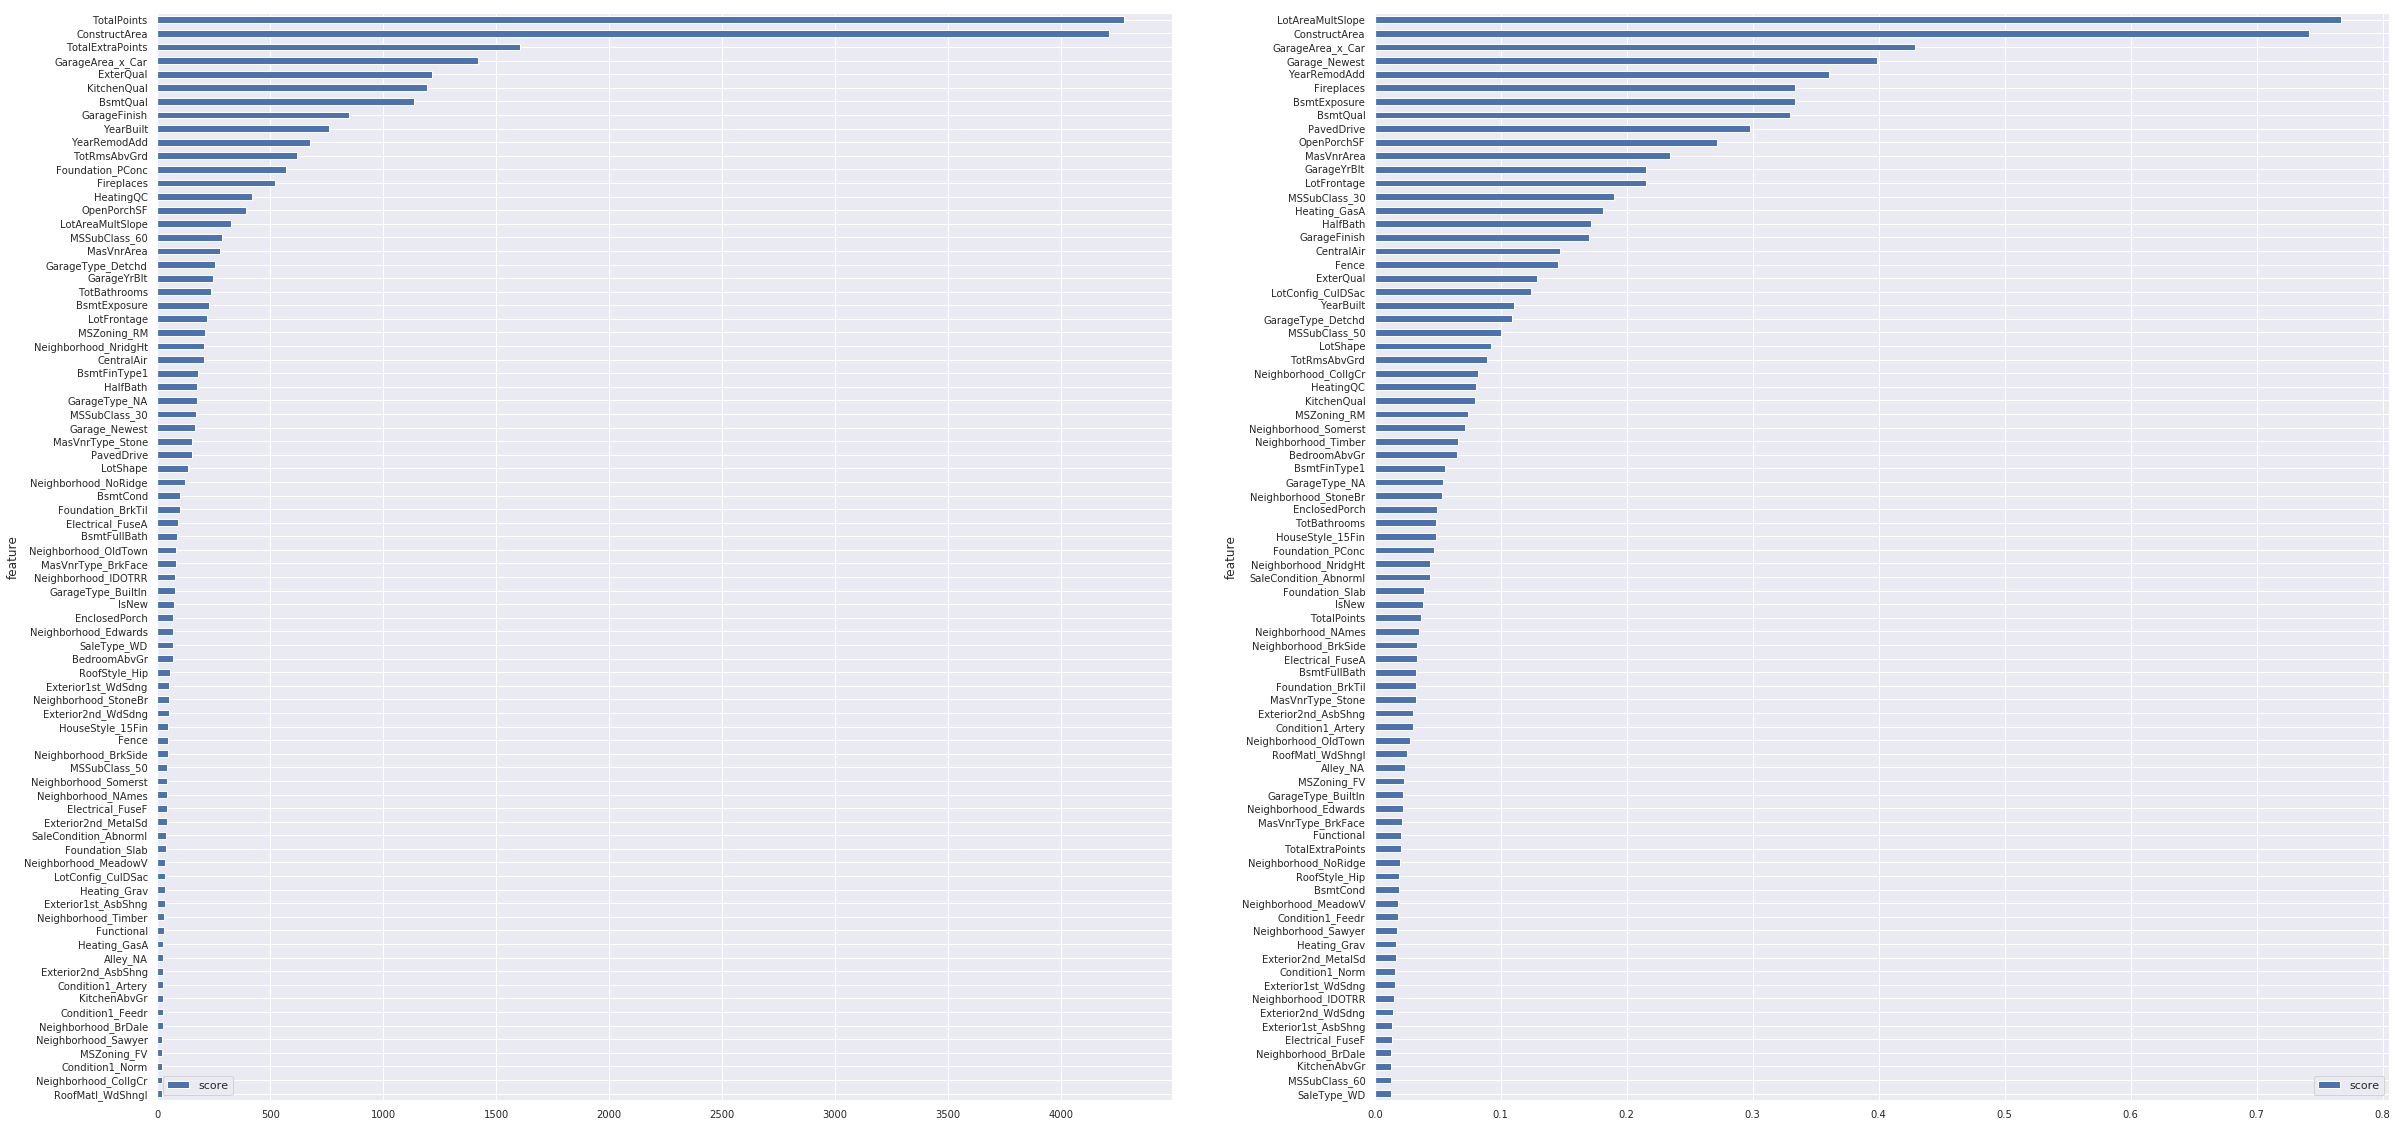

In [171]:
skb = SelectKBest(score_func=f_regression, k=80)
skb.fit(df, y_train)
select_features_kbest = skb.get_support()
kbest_FR = cols[select_features_kbest]
scores = skb.scores_[select_features_kbest]
feature_scores = pd.DataFrame([(item, score) for item, score in zip(kbest_FR, scores)], columns=['feature', 'score'])
fig = plt.figure(figsize=(40,20))
f1 = fig.add_subplot(121)
feature_scores.sort_values(by='score', ascending=True).plot(y = 'score', x = 'feature', kind='barh', 
                                                            ax = f1, fontsize=10, grid=True) 

skb = SelectKBest(score_func=mutual_info_regression, k=80)
skb.fit(df, y_train)
select_features_kbest = skb.get_support()
kbest_MIR = cols[select_features_kbest]
scores = skb.scores_[select_features_kbest]
feature_scores = pd.DataFrame([(item, score) for item, score in zip(kbest_FR, scores)], columns=['feature', 'score'])
f2 = fig.add_subplot(122)
feature_scores.sort_values(by='score', ascending=True).plot(y = 'score', x = 'feature', kind='barh', 
                                                            ax = f2, fontsize=10, grid=True) 
plt.show()

Thresh=0.000, n=188, R2: 49.40% with MSE: 0.0849
Thresh=0.001, n=85, R2: 49.40% with MSE: 0.0849
Thresh=0.001, n=84, R2: 49.40% with MSE: 0.0849
Thresh=0.001, n=83, R2: 49.86% with MSE: 0.0841
Thresh=0.002, n=82, R2: 49.16% with MSE: 0.0853
Thresh=0.002, n=81, R2: 49.16% with MSE: 0.0853
Thresh=0.002, n=80, R2: 49.48% with MSE: 0.0847
Thresh=0.002, n=79, R2: 49.48% with MSE: 0.0847
Thresh=0.002, n=78, R2: 49.48% with MSE: 0.0847
Thresh=0.002, n=77, R2: 49.86% with MSE: 0.0841
Thresh=0.002, n=76, R2: 49.86% with MSE: 0.0841
Thresh=0.002, n=75, R2: 49.29% with MSE: 0.0850
Thresh=0.002, n=74, R2: 49.45% with MSE: 0.0848
Thresh=0.003, n=73, R2: 50.00% with MSE: 0.0839
Thresh=0.003, n=72, R2: 49.48% with MSE: 0.0847
Thresh=0.003, n=71, R2: 49.48% with MSE: 0.0847
Thresh=0.003, n=70, R2: 50.03% with MSE: 0.0838
Thresh=0.003, n=69, R2: 49.57% with MSE: 0.0846
Thresh=0.003, n=68, R2: 49.57% with MSE: 0.0846
Thresh=0.003, n=67, R2: 49.48% with MSE: 0.0847
Thresh=0.003, n=66, R2: 49.48% with MSE

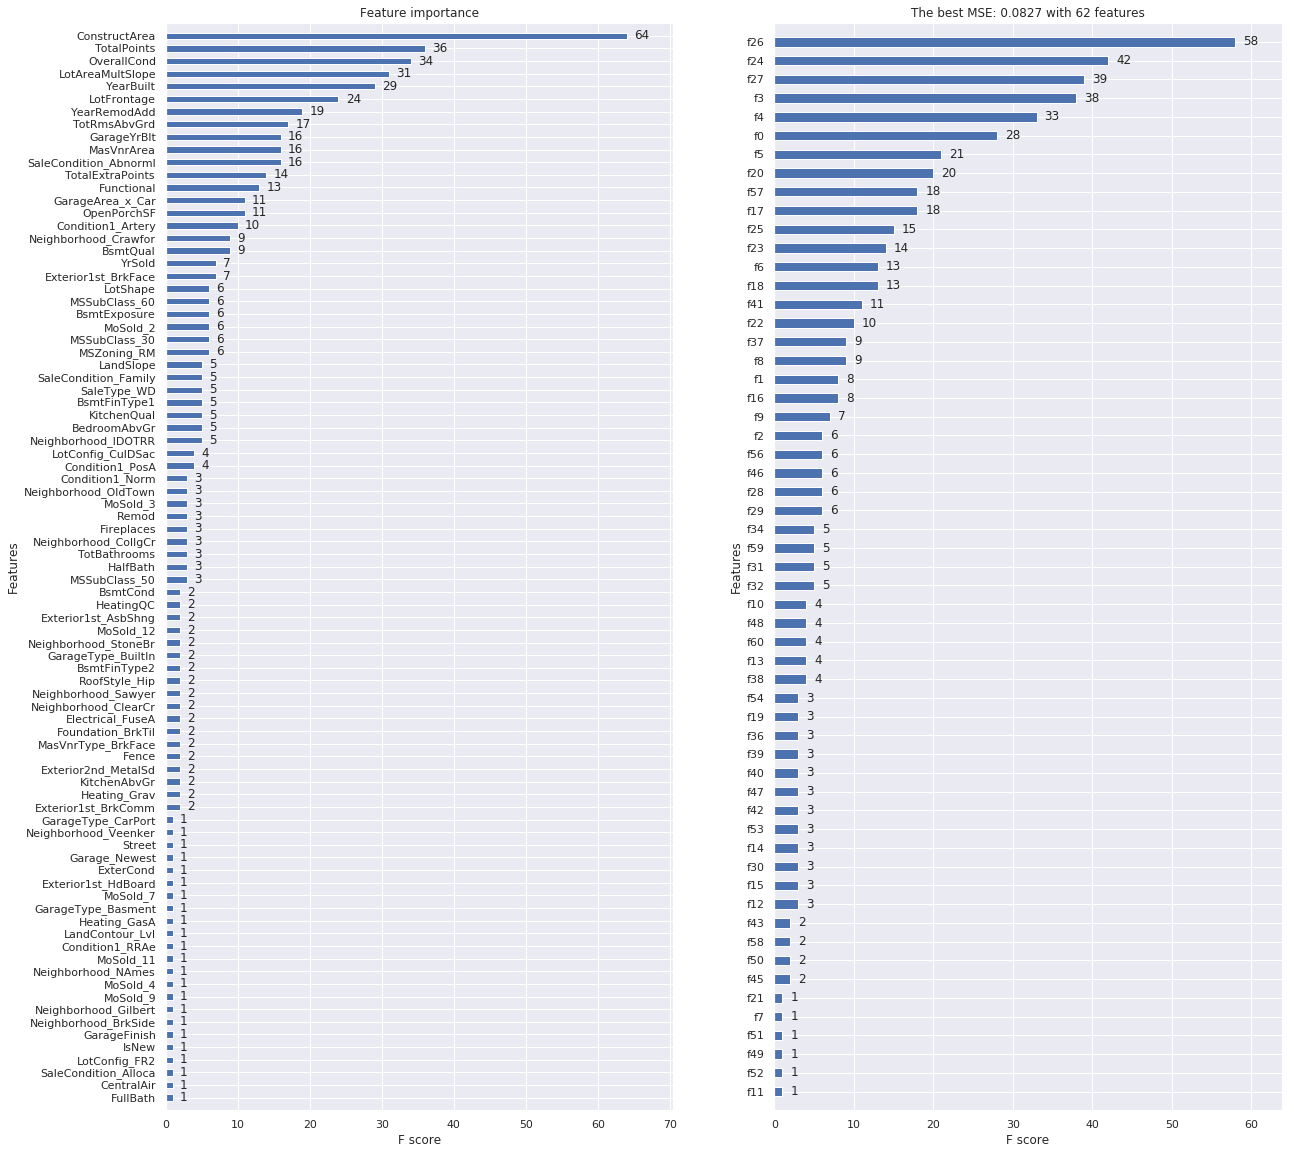

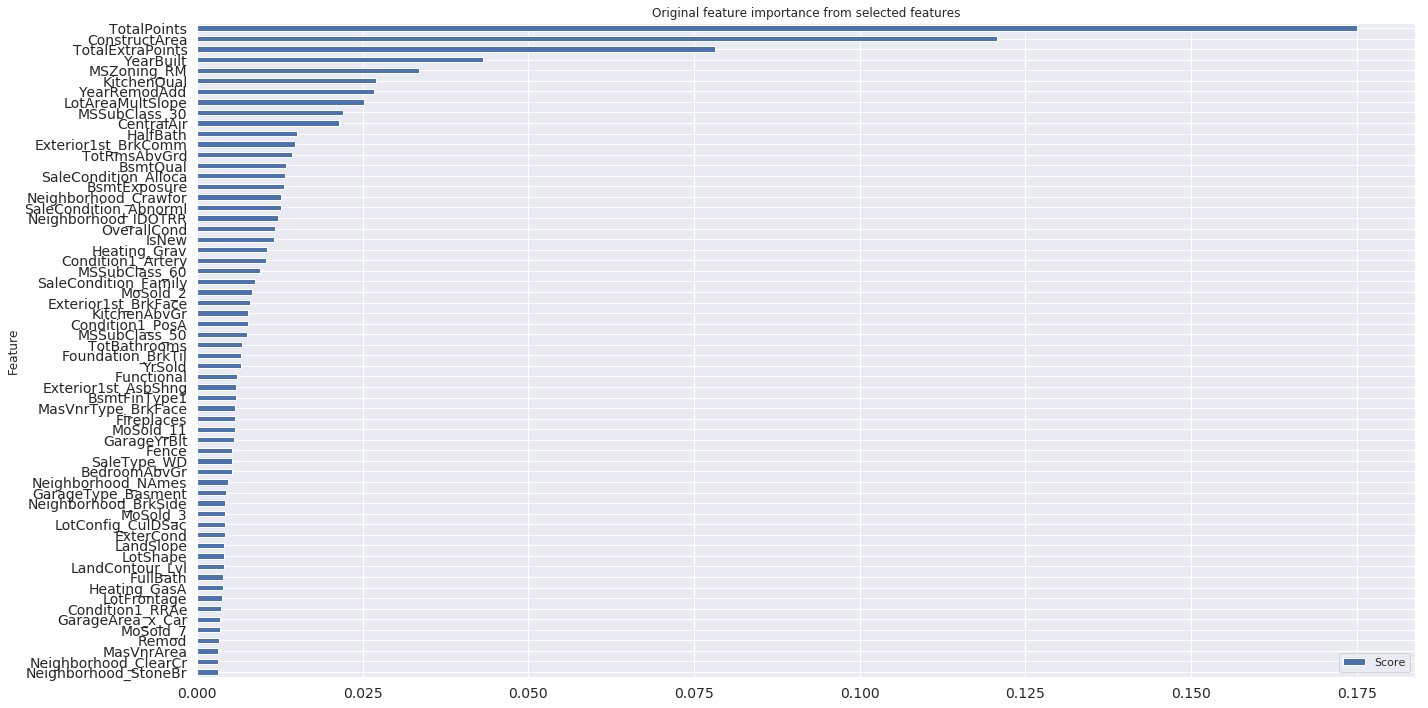

In [172]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# split data into train and test sets
X_train, X_test, y, y_test = train_test_split(df, y_train, test_size=0.30, random_state=101)

# fit model on all training data
#importance_type='gain'
model =  XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, max_delta_step=0, 
                      random_state=101, min_child_weight=1, missing=None, n_jobs=4,  
                      scale_pos_weight=1, seed=None, silent=True, subsample=1)


model.fit(X_train, y)
fig=plt.figure(figsize=(20,20))
ax = fig.add_subplot(121)
g = plot_importance(model, height=0.5, ax=ax)

# Using each unique importance as a threshold
thresholds = np.sort(np.unique(model.feature_importances_)) 
best = 1e36
colsbest = 31
my_model = model
threshold = 0

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model =  XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, max_delta_step=0, 
                                    random_state=101, min_child_weight=1, missing=None, n_jobs=4, 
                                    scale_pos_weight=1, seed=None, silent=True, subsample=1)
    selection_model.fit(select_X_train, y)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    print("Thresh={:1.3f}, n={:d}, R2: {:2.2%} with MSE: {:.4f}".format(thresh, select_X_train.shape[1], r2, mse))
    if (best >= mse):
        best = mse
        colsbest = select_X_train.shape[1]
        my_model = selection_model
        threshold = thresh
        
ax = fig.add_subplot(122)
g = plot_importance(my_model,height=0.5, ax=ax, 
                    title='The best MSE: {:1.4f} with {:d} features'.\
                    format(best, colsbest))

feature_importances = [(score, feature) for score, feature in zip(model.feature_importances_, cols)]
XGBest = pd.DataFrame(sorted(sorted(feature_importances, reverse=True)[:colsbest]), columns=['Score', 'Feature'])
g = XGBest.plot(x='Feature', kind='barh', figsize=(20,10), fontsize=14, grid= True,
     title='Original feature importance from selected features')
plt.tight_layout(); plt.show()
XGBestCols = XGBest.iloc[:, 1].tolist()

In [173]:
bcols = set(pv_cols).union(set(RFEcv)).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(XGBestCols)).union(set(SBS))
print('Features Selected by Filter Methods:\n')
print("Extra features select by Kbest_FR:", set(kbest_FR).\
     difference(set(pv_cols).union(set(RFEcv)).union(set(kbest_MIR)).union(set(XGBestCols)).union(set(SBS))), '\n')
print("Extra features select by Kbest_MIR:", set(kbest_MIR).\
      difference(set(pv_cols).union(set(RFEcv)).union(set(kbest_FR)).union(set(XGBestCols)).union(set(SBS))), '\n')
print('_'*75,'\nFeatures Selected by Wrappers Methods:\n')
print("Extra features select by pv_cols:", set(pv_cols).\
      difference(set(SBS).union(set(RFEcv)).union(set(kbest_MIR)).union(set(kbest_FR)).union(set(XGBestCols))),'\n')
print("Extra features select by RFEcv:", set(RFEcv).\
      difference(set(pv_cols).union(set(kbest_FR)).union(set(kbest_MIR)).union(set(XGBestCols)).union(set(SBS))), '\n')
print("Extra features select by SBS:", set(SBS).\
      difference(set(pv_cols).union(set(RFEcv)).union(set(kbest_MIR)).union(set(kbest_FR)).union(set(XGBestCols))), '\n')
print('_'*75,'\nFeatures Selected by Embedded Methods:\n')
print("Extra features select by XGBestCols:", set(XGBestCols).\
      difference(set(pv_cols).union(set(RFEcv)).union(set(kbest_MIR)).union(set(kbest_FR)).union(set(SBS))), '\n')
print('_'*75,'\nIntersection Features Selected:')
intersection = set(SBS).intersection(set(kbest_MIR)).intersection(set(RFEcv)).intersection(set(pv_cols)).\
               intersection(set(kbest_FR)).intersection(set(XGBestCols))
print(intersection, '\n')
print('_'*75,'\nUnion All Features Selected:')
print('Total number of features selected:', len(bcols))
print('\n{0:2d} features removed if use the union of selections: {1:}'.\
      format(len(cols.difference(bcols)), cols.difference(bcols)))

Features Selected by Filter Methods:

Extra features select by Kbest_FR: {'RoofMatl_WdShngl', 'Exterior2nd_AsbShng', 'Alley_NA'} 

Extra features select by Kbest_MIR: {'Exterior1st_CemntBd', 'Neighborhood_SawyerW', 'MSSubClass_120', 'MSSubClass_80'} 

___________________________________________________________________________ 
Features Selected by Wrappers Methods:

Extra features select by pv_cols: {'Neighborhood_NPkVill', 'Street'} 

Extra features select by RFEcv: set() 

Extra features select by SBS: {'MSSubClass_85', 'RoofStyle_Gambrel', 'Exterior1st_Plywood', 'MoSold_6', 'Condition2_Norm', 'MoSold_12', 'Foundation_Stone', 'Condition1_RRAn'} 

___________________________________________________________________________ 
Features Selected by Embedded Methods:

Extra features select by XGBestCols: {'GarageType_Basment', 'MoSold_3', 'SaleCondition_Alloca', 'Remod', 'Condition1_PosA'} 

___________________________________________________________________________ 
Intersection Features S

In [0]:
totalCols = list(bcols.union(set(colsP)))
train = all_data.loc[all_data.SalePrice>0 , list(totalCols)].reset_index(drop=True, inplace=False)
y_train = all_data.SalePrice[all_data.SalePrice>0].reset_index(drop=True, inplace=False)
test = all_data.loc[all_data.SalePrice==0 , list(totalCols)].reset_index(drop=True, inplace=False)

In [0]:
class select_fetaures(object): # BaseEstimator, TransformerMixin, 
    def __init__(self, select_cols):
        self.select_cols_ = select_cols
    
    def fit(self, X, Y ):
        print('Recive {0:2d} features...'.format(X.shape[1]))
        return self

    def transform(self, X):
        print('Select {0:2d} features'.format(X.loc[:, self.select_cols_].shape[1]))
        return X.loc[:, self.select_cols_]    

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        df = self.transform(X)
        return df 
        #X.loc[:, self.select_cols_]    

    def __getitem__(self, x):
        return self.X[x], self.Y[x]
        

In [176]:
scale = RobustScaler() 
df = scale.fit_transform(train)

pca = PCA().fit(df) # whiten=True
print('With only 120 features: {:6.4%}'.format(sum(pca.explained_variance_ratio_[:120])),"%\n")

print('After PCA, {:3} features only not explained {:6.4%} of variance ratio from the original {:3}'.format(120,
                                                                                    (sum(pca.explained_variance_ratio_[120:])),
                                                                                    df.shape[1]))
del df,all_data

With only 120 features: 99.9509% %

After PCA, 120 features only not explained 0.0491% of variance ratio from the original 165


In [0]:
def get_results(model, name='NAN', log=False):
    
    rcols = ['Name','Model', 'BestParameters', 'Scorer', 'Index', 'BestScore', 'BestScoreStd', 'MeanScore', 
             'MeanScoreStd', 'Best']
    res = pd.DataFrame(columns=rcols)
    
    results = gs.cv_results_
    modelo = gs.best_estimator_

    scoring = {'MEA': 'neg_mean_absolute_error', 'R2': 'r2', 'RMSE': 'neg_mean_squared_error'}

    for scorer in sorted(scoring):
        best_index = np.nonzero(results['rank_test_%s' % scoring[scorer]] == 1)[0][0]
        if scorer == 'RMSE': 
            best = np.sqrt(-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = np.sqrt(results['std_test_%s' % scoring[scorer]][best_index])
            scormean = np.sqrt(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = np.sqrt(results['std_test_%s' % scoring[scorer]].mean())
            if log:
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        elif scorer == 'MEA':
            best = (-results['mean_test_%s' % scoring[scorer]][best_index])
            best_std = results['std_test_%s' % scoring[scorer]][best_index]
            scormean =(-results['mean_test_%s' % scoring[scorer]].mean())
            stdmean = results['std_test_%s' % scoring[scorer]].mean()
            if log:
                best = np.expm1(best)
                best_std = np.expm1(best_std)
                scormean = np.expm1(scormean)
                stdmean = np.expm1(stdmean)
        else:
            best = results['mean_test_%s' % scoring[scorer]][best_index]*100
            best_std = results['std_test_%s' % scoring[scorer]][best_index]*100
            scormean = results['mean_test_%s' % scoring[scorer]].mean()*100
            stdmean = results['std_test_%s' % scoring[scorer]].mean()*100
        
        r1 = pd.DataFrame([(name, modelo, gs.best_params_, scorer, best_index, best, best_std, scormean, 
                            stdmean, gs.best_score_)],
                          columns = rcols)
        res = res.append(r1)
        
    if log:
        bestscore = np.expm1(np.sqrt(-gs.best_score_))
    else:
        bestscore = np.sqrt(-gs.best_score_)
        
    print("Best Score: {:.6f}".format(bestscore))
    print('---------------------------------------')
    print('Best Parameters:')
    print(gs.best_params_)
    
    return res

In [0]:
def resilduals_plots(lr, X, Y, log=False):
    y_pred = lr.predict(X)
    residual = pd.DataFrame()
    residual['Predict'] = y_pred
    residual['Residual'] = Y - y_pred
    residual['Predicted'] = np.expm1(residual.Predict)
    residual['StdResidual'] = np.expm1(Y) - residual.Predicted
    residual.StdResidual = residual.StdResidual / residual.StdResidual.std()
    residual['IDX'] = X.index
    
    if log:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(121)
        g = sns.regplot(y='Residual', x='Predict', data = residual, order=1, ax = ax) 
        plt.xlabel('Log Predicted Values')
        plt.ylabel('Log Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

        ax = fig.add_subplot(122)
        g = sns.regplot(y='StdResidual', x='Predicted', data = residual, order=1, ax = ax) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=np.expm1(min(Y))-1, xmax=np.expm1(max(Y))+1, lw=2, color='red')
        plt.xlim([np.expm1(min(Y))-1, np.expm1(max(Y))+1])
    else:
        residual.StdResidual = residual.Residual / residual.Residual.std()
        residual.drop(['Residual', 'Predicted'], axis = 1, inplace=True)
        g = sns.regplot(y='StdResidual', x='Predict', data = residual, order=1) 
        plt.xlabel('Predicted Values')
        plt.ylabel('Standardized Residuals')
        plt.hlines(y=0, xmin=min(Y)-1, xmax=max(Y)+1, lw=2, color='red')
        plt.xlim([min(Y)-1, max(Y)+1])

    plt.show()  

    return residual

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   21.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   36.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:   54.4s


Best Score: 0.117313
---------------------------------------
Best Parameters:
{'model__alpha': 0.0007, 'model__max_iter': 5, 'model__selection': 'cyclic', 'model__tol': 0.002, 'pca__n_components': 98, 'pca__whiten': True}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:  1.0min finished


Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     2      0.081         0.003      0.152         0.006
0     R2    53     92.248         0.167     69.872         0.732
0   RMSE    77      0.117         0.030      0.245         0.065

Select 98 features


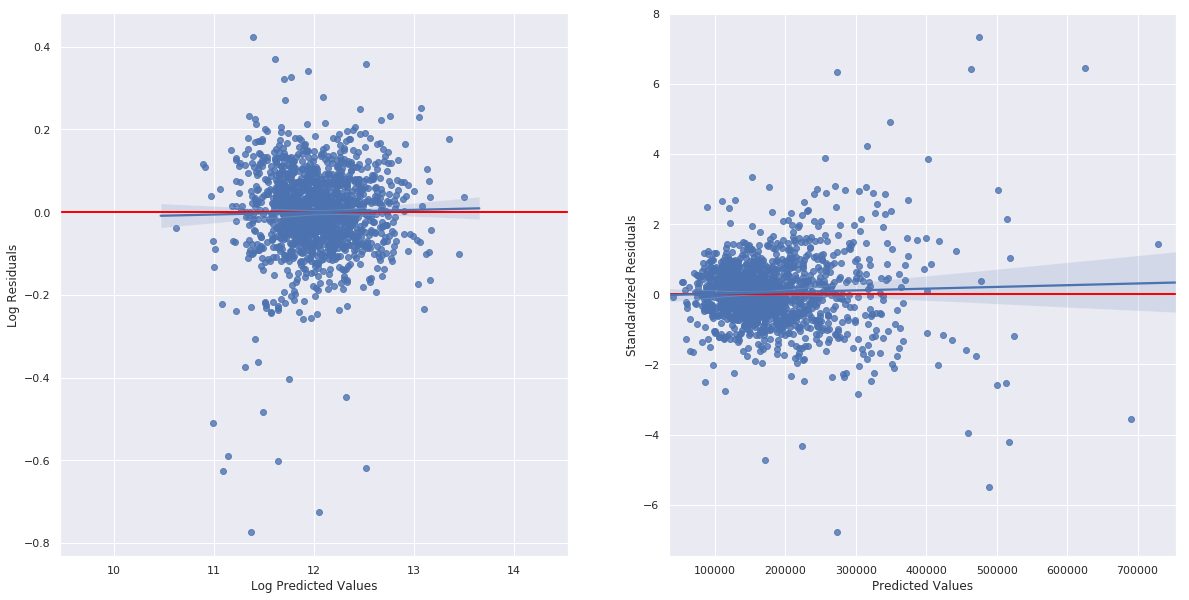

In [179]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', Lasso(random_state = 101))]) 

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-5, len(SEL)-3, len(SEL)] 
whiten = [False, True]
max_iter = [5] #, 10, 100, 200, 300, 400, 500, 600]  
alpha = [0.0003, 0.0007, 0.0005, 0.05, 0.5, 1.0]
selection = ['random', 'cyclic'] 
tol = [2e-03, 0.003, 0.001, 0.0005]
param_grid =\
            dict(
                  model__alpha = alpha
                  ,model__max_iter = max_iter
                  ,model__selection = selection
                  ,model__tol = tol
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error' #, iid=False
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)

lasso = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)), 
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

lasso.fit(train,y_train)

results = get_results(lasso, 'lasso Lg1', log=True)
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = resilduals_plots(lasso, train, y_train, log=True)

Outliers removed: 19
Recive 165 features...
Select 98 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   28.7s


Best Score: 0.095045
---------------------------------------
Best Parameters:
{'model__alpha': 0.0007, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 98, 'pca__whiten': True}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:   56.3s finished


Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA    77      0.072         0.003      0.145         0.005
0     R2    53     94.477         0.323     71.519         0.607
0   RMSE    53      0.095         0.018      0.229         0.059

Select 98 features


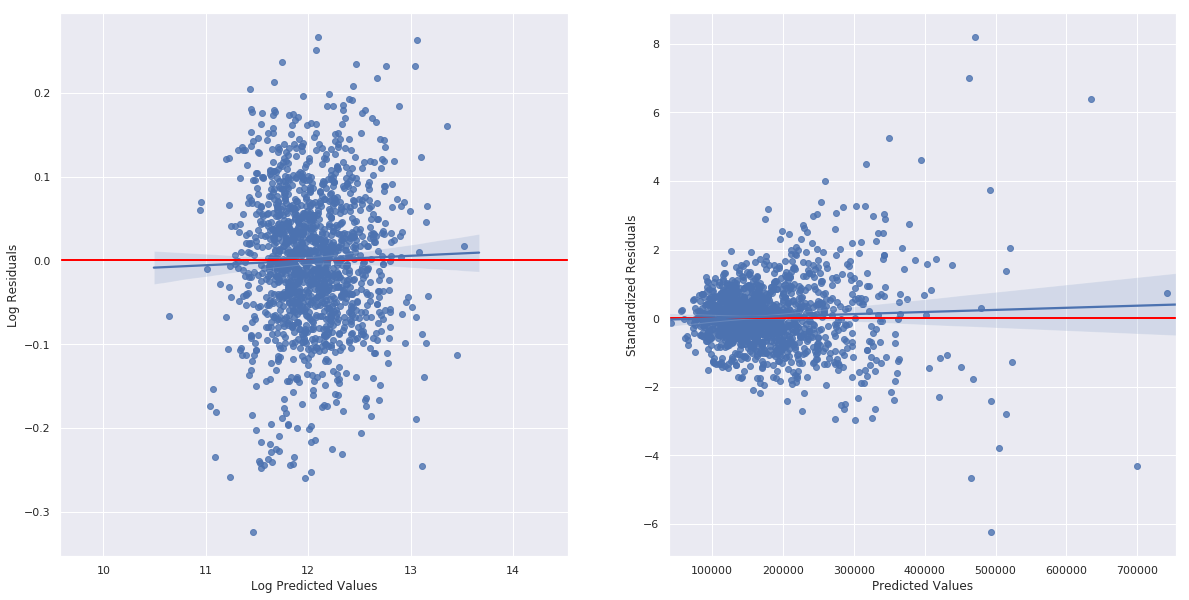

In [180]:
fica =  list(r.IDX[abs(r.Residual)<=0.3])
print('Outliers removed:', r.shape[0]-len(fica))
t = train.iloc[fica, :].reset_index(drop=True, inplace=False)
y_t = y_train.iloc[fica].reset_index(drop=True, inplace=False)

lasso.fit(t, y_t)
results = get_results(lasso, 'lasso Lg2', log=True)
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = resilduals_plots(lasso, t, y_t, log=True)
del  t, y_t, fica

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    6.4s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   30.7s


Best Score: 21288.145603
---------------------------------------
Best Parameters:
{'model__alpha': 1.0, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 93, 'pca__whiten': False}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:   57.6s finished


Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA   242  14493.976       834.268  14585.337       877.404
0     R2   240     92.740         0.570     92.630         0.495
0   RMSE   240  21288.146      7170.799  21454.325      7068.924

Select 98 features


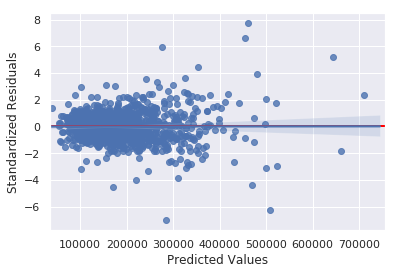

In [181]:
y = np.expm1(y_train)
lasso.fit(train, y)
results = get_results(lasso, 'lasso N1')
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = resilduals_plots(lasso, train, y)

Outliers removed: 22
Recive 165 features...
Select 98 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   34.6s


Best Score: 17566.981140
---------------------------------------
Best Parameters:
{'model__alpha': 1.0, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 98, 'pca__whiten': False}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:   55.9s finished


Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA   242  12921.907       927.246  12989.374       955.517
0     R2   242     94.285         0.689     94.217         0.700
0   RMSE   244  17566.981      6228.431  17682.294      6530.005

Select 98 features


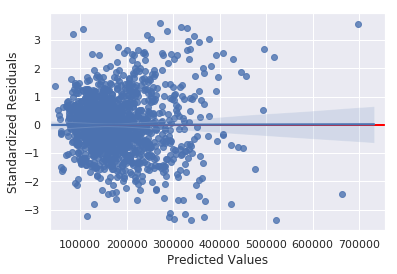

In [182]:
fica =  list(r.IDX[abs(r.StdResidual)<3]) # =2.7
print('Outliers removed:', r.shape[0]-len(fica))
t = train.iloc[fica, :].reset_index(drop=True, inplace=False)
y_l = y_train.iloc[fica].reset_index(drop=True, inplace=False)
y_n = np.expm1(y_l)

lasso.fit(t, y_n)
results = get_results(lasso, 'lasso N2')
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r2 = resilduals_plots(lasso, t, y_n)
del fica, r2

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    6.2s
[Parallel(n_jobs=4)]: Done 744 tasks      | elapsed:   30.1s


Best Score: 21288.145603
---------------------------------------
Best Parameters:
{'model__alpha': 1.0, 'model__max_iter': 5, 'model__selection': 'random', 'model__tol': 0.002, 'pca__n_components': 93, 'pca__whiten': False}


[Parallel(n_jobs=4)]: Done 1440 out of 1440 | elapsed:   57.9s finished


Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA   242  14493.976       834.268  14585.337       877.404
0     R2   240     92.740         0.570     92.630         0.495
0   RMSE   240  21288.146      7170.799  21454.325      7068.924

Select 98 features


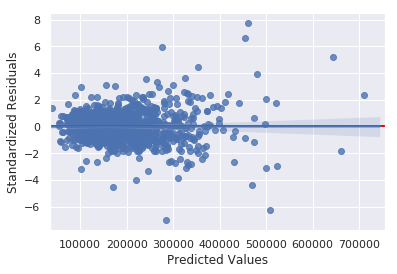

In [183]:
y_log = y_train.copy()
y_train = np.expm1(y_train)

lasso.fit(train, y_train)

results = get_results(lasso, 'lasso', log=False)
display(results.loc[:, 'Scorer' : 'MeanScoreStd'])
r = resilduals_plots(lasso, train, y_train, log=False)

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   22.7s finished


Best Score: 20367.349302
---------------------------------------
Best Parameters:
{'model__booster': 'gblinear', 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 3500, 'model__objective': 'reg:tweedie', 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'pca__n_components': 90, 'pca__whiten': True}
Select 98 features


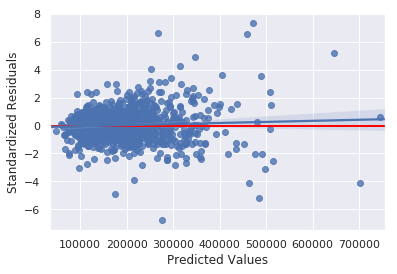

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     0  13595.098       734.516  13595.098       734.516
0     R2     0     93.348         0.569     93.348         0.569
0   RMSE     0  20367.349      6708.664  20367.349      6708.664

In [184]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', XGBRegressor(random_state=101, silent=False))])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [90] # [len(SEL)-18, len(SEL)-19, len(SEL)-20] 
whiten = [True] #, False]
n_est = [3500] # [500, 750, 1000, 2000, 2006] # np.arange(1997, 2009, 3) # 
max_depth = [3] #, 4]
learning_rate = [0.01] #, 0.03] #, 0.1, 0.05
reg_lambda = [1] #0.1, 1e-06, 1e-04, 1e-03, 1e-02, 1e-05, 1, 0.0] 
reg_alpha= [1] # , 0.5, 1, 0.0]
booster = ['gblinear'] #'dart', 'gbtree']  
objective = ['reg:tweedie'] #, 'reg:linear', 'reg:gamma']

param_grid =\
            dict(
                  pca__n_components = n_components,
                  pca__whiten = whiten, 
                  model__n_estimators= n_est
                  ,model__booster = booster
                  ,model__objective = objective
                  ,model__learning_rate = learning_rate
                  ,model__reg_lambda = reg_lambda
                  ,model__reg_alpha = reg_alpha
                  ,model__max_depth = max_depth
                ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
XGBR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

XGBR.fit(train, y_train)

res = get_results(XGBR, 'XGBRegressor', log=False)
resilduals_plots(XGBR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 92 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  2.3min finished


Best Score: 23476.608972
---------------------------------------
Best Parameters:
{'model__alpha': 0.8, 'model__criterion': 'friedman_mse', 'model__learning_rate': 0.05, 'model__loss': 'huber', 'model__max_depth': 3, 'model__max_features': 'auto', 'model__min_samples_leaf': 3, 'model__min_samples_split': 3, 'model__n_estimators': 3000, 'pca__whiten': True}
Select 92 features


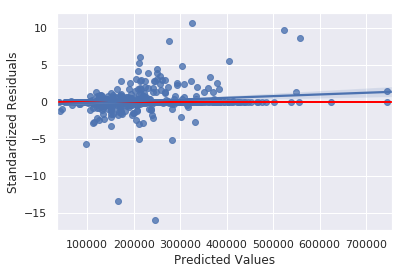

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     0  15527.568       427.507  15527.568       427.507
0     R2     0     91.160         0.956     91.160         0.956
0   RMSE     0  23476.609      8289.013  23476.609      8289.013

In [185]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', GradientBoostingRegressor(random_state=101))])

SEL = list(set(XGBestCols).union(set(colsP)))
# n_components = [len(SEL)] 
whiten = [True] #, False]
n_est = [3000]
learning_rate = [0.05] #, 0.01, 0.1, 0.005]
loss = ['huber'] #, 'ls', 'lad', 'quantile']
max_features = ['auto'] #, 'sqrt', 'log2']
max_depth = [3] #, 2] # , 5]
min_samples_split = [3] #, 4] 
min_samples_leaf = [3] # , 3, 2 ,4 ]
criterion = ['friedman_mse'] #, 'mse', 'mae']
alpha = [0.8] #, 0.75, 0.9, 0.7] 

param_grid =\
            dict(
                  #pca__n_components = n_components,
                  pca__whiten = whiten, 
                   model__n_estimators= n_est 
                  ,model__learning_rate = learning_rate
                  ,model__loss = loss
                  ,model__criterion = criterion
                  ,model__max_depth = max_depth
                  ,model__alpha = alpha
                  ,model__max_features = max_features
                  ,model__min_samples_split = min_samples_split
                  ,model__min_samples_leaf = min_samples_leaf
                   )

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                  , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                  ,cv=5, verbose=1, n_jobs=4)
 
GBR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

GBR.fit(train, y_train)
res = get_results(GBR, 'GBR' , log=False)
resilduals_plots(GBR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.7s finished


Best Score: 21241.559827
---------------------------------------
Best Parameters:
{'model__alpha': 1e-05, 'model__l1_ratio': 3e-05, 'model__max_iter': 5, 'model__selection': 'cyclic', 'pca__n_components': 98, 'pca__whiten': False}
Select 98 features


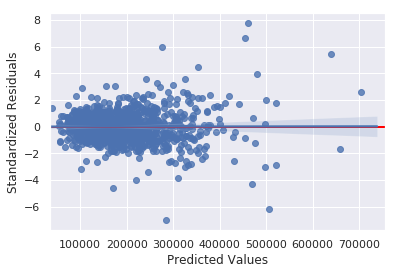

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     2  14466.162       846.847  14471.475       846.522
0     R2     2     92.774         0.565     92.772         0.570
0   RMSE     2  21241.560      7251.747  21244.814      7258.767

In [186]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', ElasticNet(random_state=101))])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-5, len(SEL)-3, len(SEL)] 
whiten = [False] #, True]
max_iter = [5] #, 100] 
alpha = [1e-05] #, 0.001, 0.01, 0.003, 0.00001] 
l1_ratio =  [0.00003] 
selection = ['cyclic'] #, 'random', 'cyclic']

param_grid =\
            dict(
                  model__max_iter= max_iter
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                  ,model__alpha = alpha
                  ,model__l1_ratio = l1_ratio
                  ,model__selection = selection
               ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
ELA = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

ELA.fit(train, y_train)

res = get_results(ELA, 'ELA', log=False)
resilduals_plots(ELA, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.4s finished


Best Score: 21218.180929
---------------------------------------
Best Parameters:
{'model__alpha_1': 1e-06, 'model__alpha_2': 0.1, 'model__lambda_1': 0.001, 'model__lambda_2': 0.01, 'model__n_iter': 36, 'pca__n_components': 89, 'pca__whiten': True}
Select 98 features


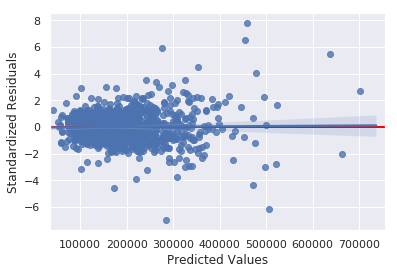

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     0  14484.989       810.638  14484.989       810.638
0     R2     0     92.787         0.561     92.787         0.561
0   RMSE     0  21218.181      7149.118  21218.181      7149.118

In [187]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', BayesianRidge())]) #compute_score=False, fit_intercept=True, normalize=False

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-9] #, len(SEL)-8, len(SEL)-7] 
whiten = [True] # , False]
n_iter=  [36] # np.arange(36, 45) # [40, 35, 45, 70, 100, 200, 300, 500, 700, 1000] #  
alpha_1 = [1e-06] #0.1, 1e-04, 1e-03, 1e-02, 1e-05]
alpha_2 = [0.1] # 1e-06 , , 1e-02, 1e-04, 1e-03]
lambda_1 = [0.001] # 0.1, 1e-06, 1e-04, 1e-02, 1e-05] 
lambda_2 = [0.01] # 0.1, 1e-06, 1e-04, 1e-03, 1e-05]

param_grid =\
            dict(
                   model__n_iter = n_iter
                  ,model__alpha_1 = alpha_1
                  ,model__alpha_2 = alpha_2
                  ,model__lambda_1 = lambda_1
                  ,model__lambda_2 = lambda_2
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
              ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
BayR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

BayR.fit(train, y_train)
res = get_results(BayR, 'BayR', log=False)
resilduals_plots(BayR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.5s finished


Best Score: 21221.254855
---------------------------------------
Best Parameters:
{'pca__n_components': 89, 'pca__whiten': True}
Select 98 features


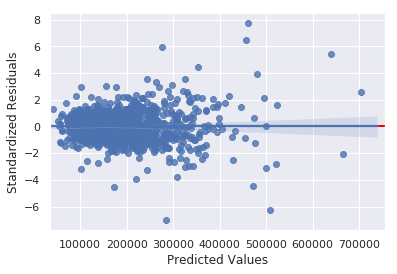

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     4  14508.021       823.044  14594.307       790.645
0     R2     4     92.785         0.577     92.689         0.541
0   RMSE     4  21221.255      7148.518  21367.266      7243.398

In [188]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', LinearRegression())])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-10, len(SEL)-11, len(SEL)-9] 
whiten = [True, False]

param_grid =\
            dict(
                   pca__n_components = n_components,
                   pca__whiten = whiten
               ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
LR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

LR.fit(train, y_train)

res = get_results(LR, 'LR', log=False)
resilduals_plots(LR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

In [214]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', OrthogonalMatchingPursuit())])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [100] # [len(SEL)-11, len(SEL)-10, len(SEL)-9] 
whiten = [False]
tol = [5e-05] # [None, 0.00005, 0.0001, 0.00000, 0.002]

param_grid =\
            dict(
                   model__tol = tol
                   ,model__n_nonzero_coefs = [2] # range(2, 6) # [10, 20, 30, 40, 50, 60, 70, 80, 90, None] # 
                   ,pca__n_components = n_components
                   ,pca__whiten = whiten
                   ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
ORT = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
])

ORT.fit(train, y_train)
res = get_results(ORT, 'ORT', log=False)
resilduals_plots(ORT, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ValueError: ignored

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    7.1s finished


Best Score: 21237.796873
---------------------------------------
Best Parameters:
{'model__alpha': 0.0001, 'model__epsilon': 1.005, 'model__max_iter': 2000, 'model__tol': 0.1, 'pca__n_components': 89, 'pca__whiten': True}
Select 98 features


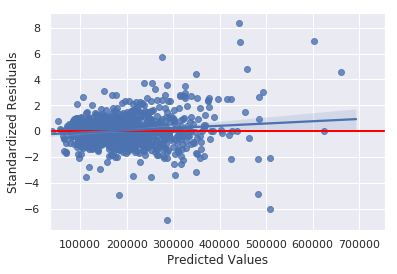

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     0  13998.781       609.618  13998.781       609.618
0     R2     0     92.778         0.604     92.778         0.604
0   RMSE     0  21237.797      7589.912  21237.797      7589.912

In [195]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', HuberRegressor())])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-9] #, len(SEL)-8, len(SEL)-7, len(SEL)-1] 
whiten = [True] #, False]
max_iter = [2000] 
alpha = [0.0001] #, 5e-05, 0.01, 0.00005, 0.0005, 0.5, 0.001] 
epsilon = [1.005] #, 1.05, 1.01, 1.001] 
tol = [1e-01, 1e-02] #, 2e-01, 3e-01, 4e-01, 5e-01, 6e-01] 

param_grid =\
            dict(
                  model__max_iter= max_iter
                  ,pca__n_components = n_components
                  ,pca__whiten = whiten 
                  ,model__alpha = alpha
                  ,model__epsilon = epsilon
                  ,model__tol = tol
               ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=3)
 
Hub = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

Hub.fit(train, y_train)

res = get_results(Hub, 'Hub', log=False)
resilduals_plots(Hub, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.2s finished


Best Score: 21492.851716
---------------------------------------
Best Parameters:
{'model__C': 0.001, 'model__epsilon': 1e-05, 'model__loss': 'squared_epsilon_insensitive', 'model__max_iter': 1000, 'model__tol': 0.001, 'pca__n_components': 89, 'pca__whiten': True}
Select 98 features


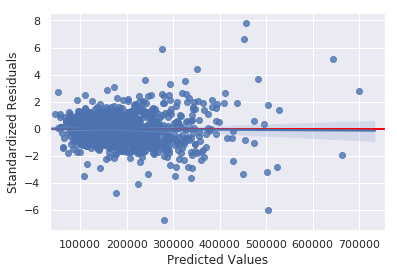

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     0  14772.952       983.570  14788.291      1016.561
0     R2     0     92.616         0.437     92.525         0.439
0   RMSE     0  21492.852      7473.224  21625.191      7457.299

In [196]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', PassiveAggressiveRegressor(random_state = 101))])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-9, len(SEL)-8, len(SEL)-7, len(SEL)-1] 
whiten = [True] #, False]
loss = ['squared_epsilon_insensitive'] #, 'epsilon_insensitive']
C = [0.001] #, 0.005, 0.003]
max_iter = [1000] 
epsilon = [0.00001] # , 0.00005
tol = [1e-03] #, 1e-05,1e-02, 1e-01, 1e-04, 1e-06]

param_grid =\
            dict(
                  pca__n_components = n_components,
                  pca__whiten = whiten, 
                  model__loss = loss
                  ,model__epsilon = epsilon
                  ,model__C = C
                  ,model__tol = tol
                  ,model__max_iter = max_iter
               ) 
 
gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
PassR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

PassR.fit(train, y_train)
res = get_results(PassR, 'PassR', log=False)
resilduals_plots(PassR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    7.0s finished


Best Score: 21219.829954
---------------------------------------
Best Parameters:
{'model__alpha': 0.001, 'model__epsilon': 0.1, 'model__eta0': 0.01, 'model__l1_ratio': 0.7, 'model__learning_rate': 'invscaling', 'model__loss': 'squared_loss', 'model__penalty': 'l2', 'model__power_t': 0.5, 'model__tol': 0.001, 'pca__n_components': 89, 'pca__whiten': True}
Select 98 features


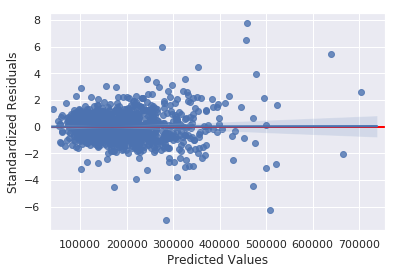

Scorer Index  BestScore  BestScoreStd  MeanScore  MeanScoreStd
0    MEA     1  14502.894       853.729  14529.324       851.650
0     R2     0     92.786         0.574     92.709         0.550
0   RMSE     0  21219.830      7148.243  21332.076      7068.170

In [197]:
model = Pipeline([
        ('pca', PCA(random_state = 101)),
        ('model', SGDRegressor(random_state = 101))])

SEL = list(set(RFEcv).union(set(colsP)))
n_components = [len(SEL)-9, len(SEL)-8, len(SEL)-7, len(SEL)-1] 
whiten = [True] #, False]
loss = ['squared_loss'] #, 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive']
penalty = ['l2'] #, 'elasticnet', 'l1']
l1_ratio = [0.7] #, 0.8] #[0.2, 0.5, 0.03]
learning_rate = ['invscaling'] #, 'constant', 'optimal']
alpha = [0.001] # [1e-01, 1e-2, 1e-03, 1e-4, 1e-05]
epsilon =  [1e-01] #, 1e-2, 1e-03, 1e-4, 1e-05]
tol = [0.001] #, 0.003] 
eta0 = [0.01] #, 1e-1, 1e-03, 1e-4, 1e-05] 
power_t = [0.5]
 
param_grid =\
            dict(
                   pca__n_components = n_components
                   ,pca__whiten = whiten, 
                   model__penalty = penalty
                   ,model__l1_ratio = l1_ratio
                   ,model__loss = loss
                   ,model__alpha = alpha
                   ,model__epsilon = epsilon
                   ,model__tol = tol
                   ,model__eta0 = eta0
                   ,model__power_t = power_t
                   ,model__learning_rate = learning_rate
               ) 

gs = GridSearchCV(estimator = model, param_grid = param_grid, refit = 'neg_mean_squared_error'
                   , scoring=list(['neg_mean_squared_error' , 'neg_mean_absolute_error', 'r2']) 
                   ,cv=5, verbose=1, n_jobs=4)
 
SGDR = Pipeline([
        ('sel', select_fetaures(select_cols=SEL)),
        ('scl', RobustScaler()),
        ('gs', gs)
 ])

SGDR.fit(train, y_train)
res = get_results(SGDR, 'SGDR', log=False)
resilduals_plots(SGDR, train, y_train, log=False)
results = pd.concat([results, res], axis=0)
res.loc[:, 'Scorer' : 'MeanScoreStd']

In [203]:
results.loc[results.Scorer=='RMSE', ['Name','BestScore', 'BestScoreStd']].sort_values(by='BestScore', ascending=True)

Name  BestScore  BestScoreStd
0  XGBRegressor  20367.349      6708.664
0          BayR  21218.181      7149.118
0          SGDR  21219.830      7148.243
0            LR  21221.255      7148.518
0           Hub  21237.797      7589.912
0           ELA  21241.560      7251.747
0         lasso  21288.146      7170.799
0         PassR  21492.852      7473.224
0           GBR  23476.609      8289.013

In [204]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)   

#defining RMSLE evaluation function
def RMSLE (y, y_pred):
    return (np.sqrt(mean_squared_error(y, y_pred)))

# Averaged base models score
averaged_models = AveragingModels(models = (XGBR, BayR, PassR)) # Hub, ELA,  lasso, ARDR, LGBM, GBR

averaged_models.fit(train, y_train) 
stacked_train_pred = averaged_models.predict(train)

stacked_pred = (averaged_models.predict(test))
rmsle = RMSLE(y_train,stacked_train_pred)

print('RMSLE score on the train data: {:.4f}'.format(rmsle))

print('Accuracy score: {:.6%}'.format(averaged_models.score(train, y_train)))

Recive 165 features...
Select 98 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   26.9s finished


Recive 165 features...
Select 98 features
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Recive 165 features...
Select 98 features
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Select 98 features
Select 98 features
Select 98 features
Select 98 features
Select 98 features
Select 98 features
RMSLE score on the train data: 19074.5622
Select 98 features
Select 98 features
Select 98 features
Accuracy score: 94.222484%


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.9s finished


In [205]:
ensemble = stacked_pred *1
submit = pd.DataFrame()
submit['id'] = test_ID
submit['SalePrice'] = ensemble
# ----------------------------- Create File to Submit --------------------------------
submit.to_csv('SalePrice_N_submission.csv', index = False)
submit.head()

id  SalePrice
0  1461 122837.473
1  1462 162555.895
2  1463 183929.250
3  1464 200202.835
4  1465 198275.185